# Predcition of Hospital Admission Related to Infections

In this notebook, we develop a Cox proportional hazard regression model to predict the risk of hospital admission for common infections including urinary tract infection (urti), upper respiratory tract infection (URTI), lower respiratory tract infection (LRTI), sinusitis, otitis media or middle ear infection (ot media), and ear infection or otitis externa (ot externa).

In [1]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import os
import glob
import gzip
from matplotlib.ticker import PercentFormatter
from patsy import dmatrices
from lifelines import CoxPHFitter
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
import pickle
from sklearn.preprocessing import PolynomialFeatures
from lifelines.utils import k_fold_cross_validation
from lifelines.utils import concordance_index
from lifelines.calibration import survival_probability_calibration
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import brier_score_loss
from sklearn.calibration import CalibrationDisplay
from sklearn.preprocessing import OneHotEncoder
from datetime import date
from operator import attrgetter
import io
import sys
from contextlib import redirect_stdout
# %matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
print("No Warning Shown")

No Warning Shown


## 0- Functions

In [3]:
def create_histplot(title, df, ax):
    ax.hist(df, color = 'purple', edgecolor = 'black', bins=20)
    ax.set_title(title)
    ax.set_ylabel('Frequency')
    ax.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=0)

In [4]:
# def create_lineplot(data, var, title, legend_title, ax1):
def create_lineplot(data, var, title, ax1):
    a = data.groupby(['date', var]).size().reset_index()
    a.columns = ['date', var, 'Freq']
    a.Freq = a.Freq*1000
    sns.lineplot(x='date', y='Freq', 
            hue=var, 
            data=a,
            ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('Count in 1000 patients')
    ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
#     ax1.legend(title=legend_title)
    ax1.grid()
    ax1.axvline(x="2020-01", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2020-04", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2021-04", color='black', ls='--', lw=1.5)

In [5]:
# function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [6]:
def ConvertColumns(InfectionKey, NumSets):
    for i in range(1, NumSets+1):        
        arrayKey1 = 'admitted_'+InfectionKey+'_date_'+str(i)
        #arrayKey2 = InfectionKey+'_date_'+str(i)
        data[arrayKey1] = data[arrayKey1].astype('datetime64[ns]')

## 1- Data Preparation

In [7]:
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation.csv.gz')
data_bmi = pd.read_csv(f'../output/hospitalisation_data/input_bmi.csv.gz')

data.shape

(200000, 79)

In [8]:
data.describe(include='all')

,deregistered_date,died_date,bmi_date_measured,smoking_status_date,most_recent_unclear_smoking_cat_date,flu_vaccine_med,flu_vaccine_clinical,admitted_date,urti_date_1,urti_date_2,...,hemiplegia_comor,hiv_comor,metastatic_cancer_comor,mild_liver_comor,mod_severe_liver_comor,mod_severe_renal_comor,mi_comor,peptic_ulcer_comor,peripheral_vascular_comor,patient_id
count,10000,20000,150000,20000,20000,20000,20000,60000,20000,20000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,2.000000e+05
unique,1241,701,41,41,41,13,13,1241,1241,1241,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2019-05-22,2022-05-11,2020-08,2021-07,2020-01,2018-08,2018-12,2019-01-16,2021-12-29,2021-12-22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,17,173,3910,559,540,1764,1761,73,33,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,9.992257e+05
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.300001,0.300001,0.300001,0.300001,0.300001,0.300001,0.300001,0.300001,0.300001,5.775408e+05
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000e+00
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.978402e+05
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000539e+06
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.496852e+06


In [9]:
data_bmi.describe(include='all')

,deregistered_date,died_date,bmi_date_measured,age,sex,bmi,ethnicity,patient_id
count,10000,20000,150000,200000.000000,200000,200000.000000,150000.000000,2.000000e+05
unique,1241,699,41,NaN,2,NaN,NaN,NaN
top,2022-02-04,2022-05-26,2019-03,NaN,F,NaN,NaN,NaN
freq,20,187,3856,NaN,101879,NaN,NaN,NaN
mean,NaN,NaN,NaN,40.303210,NaN,26.246483,1.597560,9.994461e+05
std,NaN,NaN,NaN,23.780437,NaN,17.454486,1.277174,5.775588e+05
min,NaN,NaN,NaN,0.000000,NaN,-8.108555,1.000000,1.300000e+01
25%,NaN,NaN,NaN,21.000000,NaN,0.000000,1.000000,4.980862e+05
50%,NaN,NaN,NaN,40.000000,NaN,30.681247,1.000000,9.983685e+05
75%,NaN,NaN,NaN,59.000000,NaN,39.314359,1.000000,1.499399e+06


### 1-2- Additional variables
#### 1-2-1- Calculating CHarlson Comorbidity Index
Based on https://www.nature.com/articles/4500889.pdf?origin=ppub

In [10]:
data['CCI'] = np.nan
col0 = data.columns.get_loc('CCI')

col1 = data.columns.get_loc('cancer_comor')
col2 = data.columns.get_loc('cardiovascular_comor')
col3 = data.columns.get_loc('chronic_obstructive_pulmonary_comor') ##
col4 = data.columns.get_loc('heart_failure_comor') ##
col5 = data.columns.get_loc('connective_tissue_comor')
col6 = data.columns.get_loc('dementia_comor')
col7 = data.columns.get_loc('diabetes_comor')
col8 = data.columns.get_loc('diabetes_complications_comor')
col9 = data.columns.get_loc('hemiplegia_comor')
col10 = data.columns.get_loc('hiv_comor')
col11 = data.columns.get_loc('metastatic_cancer_comor')
col12 = data.columns.get_loc('mild_liver_comor')
col13 = data.columns.get_loc('mod_severe_liver_comor')
col14 = data.columns.get_loc('mod_severe_renal_comor')
col15 = data.columns.get_loc('mi_comor')
col16 = data.columns.get_loc('peptic_ulcer_comor')
col17 = data.columns.get_loc('peripheral_vascular_comor')
# col18 = data.columns.get_loc('age')


for idx, x in enumerate(data['CCI']):
    n=0
    #comorbidity component
    if data.iat[idx, col15] == 1: # mi_comor
        n=n+1
    if data.iat[idx, col2] == 1: # cardiovascular_comor
        n=n+1 
    if data.iat[idx, col17] == 1: # peripheral_vascular_comor
        n=n+1 
    if data.iat[idx, col3] == 1: # chronic_obstructive_pulmonary_comor
        n=n+1
    # if data.iat[idx, col4] == 1: # heart_failure_comor############################
    #     n=n+1
    if data.iat[idx, col7] == 1: # diabetes_comor
        n=n+1
    if data.iat[idx, col6] == 1: # dementia_comor
        n=n+1
    if data.iat[idx, col16] == 1: # peptic_ulcer_comor
        n=n+1
    if data.iat[idx, col5] == 1: # connective_tissue_comor
        n=n+1
    if data.iat[idx, col12] == 1: # mild_liver_comor
        n=n+1
    
    if data.iat[idx, col9] == 1: # hemiplegia_comor
        n=n+2
    if data.iat[idx, col14] == 1: # mod_severe_renal_comor
        n=n+2
    if data.iat[idx, col8] == 1: # diabetes_complications_comor
        n=n+2
    if data.iat[idx, col1] == 1: # cancer_comor
        n=n+2
    #if data.iat[idx, col5] == 1: # Leukaemia#########################################
    #    n=n+2
    #if data.iat[idx, col12] == 1: # Lymphoma#########################################
    #    n=n+2

    if data.iat[idx, col13] == 1: # mod_severe_liver_comor
        n=n+3

    if data.iat[idx, col11] == 1: # metastatic_cancer_comor
        n=n+6
    if data.iat[idx, col10] == 1: # hiv_comor
        n=n+6

    # #age component
    # if data.iat[idx, col18] <= 40:
    #     n=n+0
    # if data.iat[idx, col18] > 40 and data.iat[idx, col18] <= 50:
    #     n=n+1
    # if data.iat[idx, col18] > 50 and data.iat[idx, col18] <= 60:
    #     n=n+2
    # if data.iat[idx, col18] > 60 and data.iat[idx, col18] <= 70:
    #     n=n+3
    # if data.iat[idx, col18] > 70:# and data.iat[idx, col18] <= 80:
    #     n=n+4
    
    data.iat[idx, col0]=n

data.CCI.value_counts()

0.0     37106
1.0     36711
2.0     33179
3.0     24901
4.0     14800
6.0     12396
7.0     10047
5.0      8435
8.0      7973
9.0      5737
10.0     3401
11.0     1899
12.0     1301
13.0      807
14.0      562
15.0      380
16.0      172
17.0      110
18.0       53
19.0       21
21.0        4
20.0        4
22.0        1
Name: CCI, dtype: int64

#### 1-2-2- Calculating all meds except abs

In [11]:
#generate meds_noabs in the one month before
data['meds_nonabs'] = data['all_meds'] - data['antibacterial_brit']

# assign zero for any row with negative values which could be the case because of using dummy data and/or the inconsistency of the two codelists of all_meds and antibacterial_brit
data['meds_nonabs'][data['meds_nonabs'] < 0] = 0

data['meds_nonabs'].value_counts()
# data[['all_meds_one_month', 'antibacterial_brit_one_month', 'meds_nonabs']]

0    132914
2     22441
3     18793
1     17513
4      7116
5      1153
6        69
7         1
Name: meds_nonabs, dtype: int64

### 1-3- Handling variables with missing values
#### 1-3-1- Drop variables with many missing values
We drop colmns with more than 50 percent missing values as they may not be usable in the prediction model, nor they can be imputed properly.

In [12]:
# #dropping any variable with more than 50 percent missing values
# perc = 50.0
# data[['age', 'sex + CCI + bmi + antibacterial_brit + gp_count + imd', 'meds_nonabs', 'region']] = data[['age', 'sex', 'CCI', 'bmi', 'antibacterial_brit', 'gp_count', 'imd', 'meds_nonabs', 'region']].loc[:, data[['age', 'sex', 'CCI', 'bmi', 'antibacterial_brit', 'gp_count', 'imd', 'meds_nonabs', 'region']].isnull().mean() < perc]
# data.shape

In [13]:
# fig, ax = plt.subplots(figsize=(10, 8))
# sns.heatmap(data[['age', 'bmi', 'CCI', 'antibacterial_brit', 'gp_count', 'imd', 'meds_nonabs']].corr(), 
#             annot=True, fmt=".2f", annot_kws={"size":12},
#             vmin=-1.0, vmax=1.0)

# ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions', 'GP consultations' , 'IMD', 'All medicines except antibacterials'], rotation=90, fontsize=12)
# ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions', 'GP consultations' , 'IMD', 'All medicines except antibacterials'], rotation=0, fontsize=12)                        
# plt.tight_layout()
# plt.savefig('../output/hospitalisation_prediction_urti/corr_urti.jpg')
# plt.show()

#### 1-3-2- Imputation of missing values
We impute variables with missing values that at most 50 pecent of their values are missing.

### 1-5- Polynomial featuring

In [14]:
# X = data[['age']]
# X.head()

In [15]:
# poly = PolynomialFeatures(degree=5, include_bias=False, interaction_only=False)
# # poly.fit_transform(X)
# poly_features = poly.fit_transform(X)
# poly_features = pd.DataFrame(poly_features)
# poly_features

## 2- Plots
### 2-1- Continuous factors

In [16]:
# fig, axes = plt.subplots(3,2, 
#                         figsize=(15, 15)
#                         )
# create_histplot('BMI', data['bmi'], axes[0,0])
# create_histplot('Age', data['age'], axes[0,1])
# create_histplot('Count of GP consultation', data['gp_count'], axes[1,0])
# create_histplot('Practice', data['practice'], axes[1,1])
# create_histplot('CCI', data['CCI'], axes[2,0])
# fig.delaxes(ax=axes[2,1])

# fig.suptitle('Risk Factors', fontsize=16)
# fig.tight_layout(rect=[0, 0.03, 1, 0.98])
# #plt.tight_layout()
# plt.savefig('../output/hospitalisation_prediction_urti/risk_factors_cont.jpg')
# plt.show()

In [17]:
# p = sns.pairplot(data, vars=['age', 'bmi', 'gp_count', 'CCI'#, 'practice'
#                              ], 
#                 hue = 'admitted', # 'antibacterial_brit', 
# #                kind='reg', 
#                 #markers=["o", "s"], 
#                 diag_kind="kde",#"hist"
# #                plot_kws={#'line_kws':{'color':'red'}, 
#                 plot_kws={'alpha':0.3},
#                 height = 3)

# p.axes[0,2].set_xlim((0,20))
# p.axes[0,2].set_ylim((0,100))

# p.axes[1,1].set_xlim((0,75))
# p.axes[1,1].set_ylim((0,75))

# p.axes[2,0].set_xlim((0,100))
# p.axes[2,0].set_ylim((0,20))

# p.axes[0,3].set_xlim((0,20))
# p.axes[3,0].set_ylim((0,20))

# plt.suptitle('Pairplot of continuous factors', fontsize=16, y=1.05)
# plt.savefig('../output/hospitalisation_prediction_urti/risk_factors_cont_pairplot.jpg')
# plt.show()

### 2-2- Categorical factors

In [18]:
# fig, axes = plt.subplots(7,2,
#                         figsize=(15, 10)
#                         )
# create_lineplot(data, 'sex', 'Sex', 'Sex', axes[0,0])
# create_lineplot(data, 'age_cat', 'Age category', 'Age category', axes[0,1])
# create_lineplot(data, 'imd_imp', 'IMD', 'IMD', axes[1,0])
# create_lineplot(data, 'ethnicity_imp', 'Ethnicity', 'Ethnicity', axes[1,1])
# create_lineplot(data, 'smoking_status_imp', 'Smoking status', 'Smoking status', axes[2,0])
# create_lineplot(data, 'bmi_imp_cat', 'BMI', 'BMI', axes[2,1])
# create_lineplot(data, 'CCI_cat', 'CCI', 'CCI', axes[1,0])
# create_lineplot(data, 'gp_count_imp_cat', 'GP consultation', 'GP consultation', axes[3,1])
# create_lineplot(data, 'region', 'Region', 'Region', axes[4,0])
# create_lineplot(data, 'flu_vaccine', 'Flu vaccine', 'Flu vaccine', axes[4,1])
# create_lineplot(data, 'antibacterial_brit_imp', 'Antibacterial prescriptions', 'Antibacterial prescriptions', axes[5,0])
# create_lineplot(data, 'msoa', 'msoa', 'MSOA', axes[5,1])
# create_lineplot(data, 'meds_nonabs', 'Medicines excpet antibacterials', 'Medicines excpet antibacterials', axes[6,0])
# fig.delaxes(ax=axes[6,1])

# fig.suptitle('Risk Factors', fontsize=16)
# fig.tight_layout(rect=[0, 0.03, 1, 0.98])
# #plt.tight_layout()
# plt.savefig('../output/hospitalisation_prediction_urti/risk_factors_cat.jpg')
# plt.show()

## 3- Data preparation
This includes data type conversion and exclusion of cases that are not considered in the infection-related hospital admission, i.e. those who were diagnosed with Covid19 three months (=90 days) before and one month (=30 days) after hospital admission.

### 3-1- URTI

#### URTI-1

In [19]:
data_urti_1 = data[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi', 'gp_count', 'imd', 'ethnicity', 
                    'antibacterial_brit', 'region', 'hx_hosp', 'CCI', 'meds_nonabs', 
                    'died_date', 'deregistered_date', 'gp_cons_urti_1', 'gp_cons_urti_ab_1',
                    'urti_date_1', 'incdt_urti_date_1', 'admitted_urti_date_1', 'sgss_gp_cov_urti_date_1']]

data_urti_1 = data_urti_1[data_urti_1['urti_date_1'].notnull()]

data_urti_1.shape

(20000, 22)

In [20]:
# exclusion of covid positive 90 days before and 30 days after dx with urti_1
data_urti_1 = data_urti_1[data_urti_1['sgss_gp_cov_urti_date_1'] == 0]
data_urti_1.shape

(17946, 22)

In [21]:
data_urti_1.columns

Index(['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi',
       'gp_count', 'imd', 'ethnicity', 'antibacterial_brit', 'region',
       'hx_hosp', 'CCI', 'meds_nonabs', 'died_date', 'deregistered_date',
       'gp_cons_urti_1', 'gp_cons_urti_ab_1', 'urti_date_1',
       'incdt_urti_date_1', 'admitted_urti_date_1', 'sgss_gp_cov_urti_date_1'],
      dtype='object')

In [22]:
# drop rows with no gp_cons_urti_1 records
data_urti_1 = data_urti_1.dropna(subset=['gp_cons_urti_1'])
data_urti_1.shape

(1837, 22)

#### URTI-2

In [23]:
data_urti_2 = data[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi', 'gp_count', 'imd', 'ethnicity', 
                    'antibacterial_brit', 'region', 'hx_hosp', 'CCI', 'meds_nonabs',
                    'died_date', 'deregistered_date', 'gp_cons_urti_2', 'gp_cons_urti_ab_2',
                    'urti_date_2', 'incdt_urti_date_2', 'admitted_urti_date_2', 'sgss_gp_cov_urti_date_2']]

data_urti_2 = data_urti_2[data_urti_2['urti_date_2'].notnull()]

data_urti_2.shape

(20000, 22)

In [24]:
# exclusion of covid positive 90 days before and 30 days after dx with urti_2
data_urti_2 = data_urti_2[data_urti_2['sgss_gp_cov_urti_date_2'] == 0]
data_urti_2.shape

(18043, 22)

In [25]:
data_urti_2.columns

Index(['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi',
       'gp_count', 'imd', 'ethnicity', 'antibacterial_brit', 'region',
       'hx_hosp', 'CCI', 'meds_nonabs', 'died_date', 'deregistered_date',
       'gp_cons_urti_2', 'gp_cons_urti_ab_2', 'urti_date_2',
       'incdt_urti_date_2', 'admitted_urti_date_2', 'sgss_gp_cov_urti_date_2'],
      dtype='object')

In [26]:
# drop rows with no gp_cons_urti_2 records
data_urti_2 = data_urti_2.dropna(subset=['gp_cons_urti_2'])
data_urti_2.shape

(1844, 22)

#### URTI_3

In [27]:
data_urti_3 = data[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi', 'gp_count', 'imd', 'ethnicity', 
                    'antibacterial_brit', 'region', 'hx_hosp', 'CCI', 'meds_nonabs',
                    'died_date', 'deregistered_date', 'gp_cons_urti_3', 'gp_cons_urti_ab_3',
                    'urti_date_3', 'incdt_urti_date_3', 'admitted_urti_date_3', 'sgss_gp_cov_urti_date_3']]

data_urti_3 = data_urti_3[data_urti_3['urti_date_3'].notnull()]

data_urti_3.shape

(20000, 22)

In [28]:
# exclusion of covid positive 90 days before and 30 days after dx with urti_3
data_urti_3 = data_urti_3[data_urti_3['sgss_gp_cov_urti_date_3'] == 0]
data_urti_3.shape

(18028, 22)

In [29]:
data_urti_3.columns

Index(['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi',
       'gp_count', 'imd', 'ethnicity', 'antibacterial_brit', 'region',
       'hx_hosp', 'CCI', 'meds_nonabs', 'died_date', 'deregistered_date',
       'gp_cons_urti_3', 'gp_cons_urti_ab_3', 'urti_date_3',
       'incdt_urti_date_3', 'admitted_urti_date_3', 'sgss_gp_cov_urti_date_3'],
      dtype='object')

In [30]:
# drop rows with no gp_cons_urti_3 records
data_urti_3 = data_urti_3.dropna(subset=['gp_cons_urti_3'])
data_urti_3.shape

(1850, 22)

#### URTI_4

In [31]:
data_urti_4 = data[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi', 'gp_count', 'imd', 'ethnicity', 
                    'antibacterial_brit', 'region', 'hx_hosp', 'CCI', 'meds_nonabs',
                    'died_date', 'deregistered_date', 'gp_cons_urti_4', 'gp_cons_urti_ab_4',
                    'urti_date_4', 'incdt_urti_date_4', 'admitted_urti_date_4', 'sgss_gp_cov_urti_date_4']]

data_urti_4 = data_urti_4[data_urti_4['urti_date_4'].notnull()]

data_urti_4.shape

(20000, 22)

In [32]:
# exclusion of covid positive 90 days before and 30 days after dx with urti_4
data_urti_4 = data_urti_4[data_urti_4['sgss_gp_cov_urti_date_4'] == 0]
data_urti_4.shape

(17981, 22)

In [33]:
data_urti_4.columns

Index(['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi',
       'gp_count', 'imd', 'ethnicity', 'antibacterial_brit', 'region',
       'hx_hosp', 'CCI', 'meds_nonabs', 'died_date', 'deregistered_date',
       'gp_cons_urti_4', 'gp_cons_urti_ab_4', 'urti_date_4',
       'incdt_urti_date_4', 'admitted_urti_date_4', 'sgss_gp_cov_urti_date_4'],
      dtype='object')

In [34]:
data_urti_4.shape

(17981, 22)

In [35]:
# data_urti_4.gp_cons_urti_4.value_counts()#isnull().sum()
data_urti_4.gp_cons_urti_4.isnull().sum()

16290

In [36]:
# drop rows with no gp_cons_urti_4 records
data_urti_4 = data_urti_4.dropna(subset=['gp_cons_urti_4'])
data_urti_4.shape

(1691, 22)

#### Combining URTI_1, URTI_2, URTI_3, and URTI_4

In [37]:
data_urti_1.rename(columns={'urti_date_1': 'urti_date',
                           'gp_cons_urti_1': 'gp_cons_urti', 'gp_cons_urti_ab_1': 'gp_cons_urti_ab',
                           'incdt_urti_date_1': 'incdt_urti_date', #'prevl_urti_date_1': 'prevl_urti_date',
                           'admitted_urti_date_1': 'admitted_urti_date',
                           'sgss_gp_cov_urti_date_1': 'sgss_gp_cov_urti_date'},
                inplace=True)
data_urti_2.rename(columns={'urti_date_2': 'urti_date',
                           'gp_cons_urti_2': 'gp_cons_urti', 'gp_cons_urti_ab_2': 'gp_cons_urti_ab',
                           'incdt_urti_date_2': 'incdt_urti_date', #'prevl_urti_date_2': 'prevl_urti_date', 
                           'admitted_urti_date_2': 'admitted_urti_date',
                           'sgss_gp_cov_urti_date_2': 'sgss_gp_cov_urti_date'},
                inplace=True)
data_urti_3.rename(columns={'urti_date_3': 'urti_date',
                           'gp_cons_urti_3': 'gp_cons_urti', 'gp_cons_urti_ab_3': 'gp_cons_urti_ab',
                           'incdt_urti_date_3': 'incdt_urti_date', #'prevl_urti_date_3': 'prevl_urti_date', 
                           'admitted_urti_date_3': 'admitted_urti_date',
                           'sgss_gp_cov_urti_date_3': 'sgss_gp_cov_urti_date'},
                 inplace=True)
data_urti_4.rename(columns={'urti_date_4': 'urti_date', 
                           'gp_cons_urti_4': 'gp_cons_urti', 'gp_cons_urti_ab_4': 'gp_cons_urti_ab',
                           'incdt_urti_date_4': 'incdt_urti_date', #'prevl_urti_date_4': 'prevl_urti_date',
                           'admitted_urti_date_4': 'admitted_urti_date',
                           'sgss_gp_cov_urti_date_4': 'sgss_gp_cov_urti_date'}, 
                 inplace=True)

data_urti = pd.concat([data_urti_1, data_urti_2, data_urti_3, data_urti_4])
data_urti.reset_index(inplace=True, drop=True)
data_urti.shape

(7222, 22)

In [38]:
data_urti['urti_date'] = data_urti['urti_date'].astype('datetime64[ns]')
data_urti['gp_cons_urti'] = data_urti['gp_cons_urti'].astype('datetime64[ns]')
data_urti['admitted_urti_date'] = data_urti['admitted_urti_date'].astype('datetime64[ns]')
data_urti.died_date = data_urti.died_date.astype('datetime64[ns]')
data_urti.deregistered_date = data_urti.deregistered_date.astype('datetime64[ns]')
data_urti.shape

(7222, 22)

In [39]:
# data_urti['imd'] = data_urti['imd'].astype('object')
# data_urti['imd']

In [40]:
data_urti.columns

Index(['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi',
       'gp_count', 'imd', 'ethnicity', 'antibacterial_brit', 'region',
       'hx_hosp', 'CCI', 'meds_nonabs', 'died_date', 'deregistered_date',
       'gp_cons_urti', 'gp_cons_urti_ab', 'urti_date', 'incdt_urti_date',
       'admitted_urti_date', 'sgss_gp_cov_urti_date'],
      dtype='object')

In [41]:
#add a variable called date using gp consultation dates
data_urti['date'] = data_urti['gp_cons_urti']
data_urti['date'] = data_urti['date'].dt.strftime('%Y-%m')

In [42]:
#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')
# today_date_y_m

#drop any records of data_urti with today's date in year and month
data_urti = data_urti[data_urti['date'] != today_date_y_m]
data_urti['date']

0       2022-01
1       2019-01
2       2020-11
3       2020-11
4       2020-09
         ...   
7217    2020-12
7218    2020-07
7219    2022-01
7220    2020-06
7221    2019-07
Name: date, Length: 7222, dtype: object

In [43]:
#add a variable called season based on the month of urti records
data_urti['season'] = np.nan
data_urti['date_month'] = pd.DatetimeIndex(data_urti['date']).month

conditions = [
    (data_urti['date_month'] >= 3) & (data_urti['date_month'] <= 5),
    (data_urti['date_month'] >= 6) & (data_urti['date_month'] <= 8),
    (data_urti['date_month'] >= 9) & (data_urti['date_month'] <= 11),]
choices = ['Spring', 'Summer', 'Autumn']
data_urti['season'] = np.select(conditions, choices, default='Winter')

data_urti['season'].value_counts()

Spring    2139
Winter    1883
Autumn    1626
Summer    1574
Name: season, dtype: int64

In [44]:
# fig, axes = plt.subplots(6,2,
#                         figsize=(20, 40)
#                         )
# create_lineplot(data_urti, 'sex', 'Sex', axes[0,0])
# create_lineplot(data_urti, 'age_cat', 'Age category', axes[0,1])
# create_lineplot(data_urti, 'imd_imp', 'IMD', axes[1,0])
# create_lineplot(data_urti, 'ethnicity_imp', 'Ethnicity', axes[1,1])
# create_lineplot(data_urti, 'smoking_status_imp', 'Smoking status', axes[2,0])
# create_lineplot(data_urti, 'bmi_imp_cat', 'BMI', axes[2,1])
# create_lineplot(data_urti, 'CCI_cat', 'CCI', axes[3,0])
# create_lineplot(data_urti, 'gp_count_imp_cat', 'GP consultation', axes[3,1])
# create_lineplot(data_urti, 'region_imp', 'Region', axes[4,0])
# create_lineplot(data_urti, 'flu_vaccine', 'Flu vaccine', axes[4,1])
# create_lineplot(data_urti, 'antibacterial_brit_cat', 'Antibacterial prescriptions', axes[5,0])
# create_lineplot(data_urti, 'meds_nonabs_cat', 'Medicines excpet antibacterials', axes[5,1])
# # fig.delaxes(ax=axes[6,1])

# fig.suptitle('Risk Factors of URTI patients', fontsize=16)
# fig.tight_layout(rect=[0, 0.03, 1, 0.98])
# #plt.tight_layout()
# plt.savefig('../output/hospitalisation_prediction_urti/risk_factors_cat_urti.jpg')
# plt.show()

#### Adding event and duration columns

In [45]:
#scenario 1
#not hosped (nothing happened)
#data_urti = data_urti[data_urti['admitted_urti_date'].notnull()]
data_urti.loc[data_urti['admitted_urti_date'].isnull(), 'event_urti_admitted'] = 0
data_urti['event_urti_admitted'].value_counts()

0.0    4996
Name: event_urti_admitted, dtype: int64

In [46]:
#scenario 2 
# become a case (uncensoring)
#calculating days between infection gp consultation and hosp
# data_urti['delta_urti_admitted'] = (data_urti['admitted_urti_date'] - data_urti['urti_date']).dt.days
data_urti['delta_urti_admitted'] = (data_urti['admitted_urti_date'] - data_urti['gp_cons_urti']).dt.days
data_urti.loc[((data_urti['delta_urti_admitted'] >= 0) & (data_urti['delta_urti_admitted'] <= 30)), 'event_urti_admitted'] = 1
data_urti['event_urti_admitted'].value_counts()

0.0    4996
1.0      52
Name: event_urti_admitted, dtype: int64

In [47]:
#scenario 2
#drop whoever was admitted before urti consultation, i.e. negative value for delta_urti_admitted
data_urti = data_urti[~(data_urti['delta_urti_admitted'] < 0)]
data_urti['delta_urti_admitted'].value_counts()

245.0    6
193.0    6
417.0    5
136.0    5
26.0     5
        ..
586.0    1
553.0    1
103.0    1
410.0    1
733.0    1
Name: delta_urti_admitted, Length: 652, dtype: int64

In [48]:
# data_urti['event_urti_admitted'].value_counts()
data_urti['event_urti_admitted'].isnull().sum()

1040

In [49]:
#scenario 3
#censor died patients
data_urti['delta_admitted_died'] = (data_urti['died_date'] - data_urti['admitted_urti_date']).dt.days
data_urti.loc[data_urti['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
# data_urti.loc[data_urti['delta_admitted_died'] >= 0, 'event_urti_admitted'] = 0
data_urti.loc[((data_urti['delta_admitted_died'] >= 0) & (data_urti['delta_admitted_died'] <= 30)), 'event_urti_admitted'] = 0
data_urti['event_urti_admitted'].value_counts()

0.0    5000
1.0      52
Name: event_urti_admitted, dtype: int64

In [50]:
#scenario 3
#censor deregistered patients
data_urti['delta_admitted_deregistered'] = (data_urti['deregistered_date'] - data_urti['admitted_urti_date']).dt.days
data_urti.loc[data_urti['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
# data_urti.loc[data_urti['delta_admitted_deregistered'] >= 0, 'event_urti_admitted'] = 0
data_urti.loc[((data_urti['delta_admitted_deregistered'] > 0) & (data_urti['delta_admitted_deregistered'] <= 30)), 'event_urti_admitted'] = 0
data_urti['event_urti_admitted'].value_counts()

0.0    5000
1.0      52
Name: event_urti_admitted, dtype: int64

In [51]:
#agg scenario 3s
data_urti['delta_admitted_died_deregistered'] = data_urti['delta_admitted_deregistered'].combine_first(data_urti['delta_admitted_died'])
data_urti.loc[data_urti['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN
data_urti['delta_admitted_died_deregistered'].isnull().sum()#.value_counts()

5973

In [52]:
data_urti['delta_admitted_died_deregistered'].value_counts()

70.0     2
709.0    2
339.0    2
628.0    1
39.0     1
        ..
603.0    1
144.0    1
127.0    1
163.0    1
257.0    1
Name: delta_admitted_died_deregistered, Length: 112, dtype: int64

In [53]:
#censor patients that had a history of hospital admission
# data_urti.loc[data_urti['hx_hosp'] == 1, 'event_urti_admitted'] = 0

In [54]:
#scenario 1
#any other patients (nothing happened)
data_urti['event_urti_admitted'] = data_urti['event_urti_admitted'].replace(np.NaN, 0)
data_urti['event_urti_admitted'].value_counts()

0.0    6036
1.0      52
Name: event_urti_admitted, dtype: int64

In [55]:
#assign values for duration column
data_urti['duration_urti_admitted'] = data_urti['delta_urti_admitted'].combine_first(data_urti['delta_admitted_died_deregistered'])
data_urti['duration_urti_admitted'] = data_urti['duration_urti_admitted'].replace(np.NaN, 30)
data_urti.loc[(data_urti['duration_urti_admitted'] > 30), 'duration_urti_admitted'] = 30
data_urti['duration_urti_admitted'].value_counts()

30.0    6037
26.0       5
24.0       4
17.0       4
2.0        3
1.0        3
25.0       3
19.0       3
16.0       2
9.0        2
3.0        2
29.0       2
5.0        2
11.0       2
4.0        2
15.0       2
13.0       2
14.0       2
0.0        1
10.0       1
22.0       1
6.0        1
23.0       1
18.0       1
Name: duration_urti_admitted, dtype: int64

In [56]:
# give value 1 to event_urti_admitted if duration_urti_admitted is greater or equal to 0 and less than 30
data_urti.loc[((data_urti['duration_urti_admitted'] >= 0) & (data_urti['duration_urti_admitted'] < 30)), 'event_urti_admitted'] = 1
data_urti['event_urti_admitted'].value_counts()

0.0    6036
1.0      52
Name: event_urti_admitted, dtype: int64

In [57]:
#drop any rows with value 0 in duration column
data_urti = data_urti[~(data_urti['duration_urti_admitted'] == 0)]

In [58]:
data_urti[data_urti['duration_urti_admitted']==0][['delta_urti_admitted', 'urti_date', 'gp_cons_urti', 'admitted_urti_date', 'delta_urti_admitted', 'delta_admitted_died_deregistered', 'event_urti_admitted', 'duration_urti_admitted']]

,delta_urti_admitted,urti_date,gp_cons_urti,admitted_urti_date,delta_urti_admitted,delta_admitted_died_deregistered,event_urti_admitted,duration_urti_admitted


In [59]:
#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_urti.loc[((data_urti['delta_urti_admitted'] > 0) & (data_urti['delta_urti_admitted'] < 30)), 'event_urti_admitted'] = 1

In [60]:
# data_urti.loc[151:200, ['event_urti_admitted', 'duration_urti_admitted']]
# data_urti.loc[201:250, ['event_urti_admitted', 'duration_urti_admitted']].sort_values(by=['duration_urti_admitted'])
data_urti[['event_urti_admitted', 'duration_urti_admitted']].sort_values(by=['duration_urti_admitted'])

,event_urti_admitted,duration_urti_admitted
6268,1.0,1.0
5375,1.0,1.0
5284,1.0,1.0
267,1.0,2.0
6276,1.0,2.0
...,...,...
2394,0.0,30.0
2393,0.0,30.0
2392,0.0,30.0
2403,0.0,30.0


## 3- Dealing with missing values

In [61]:
# #dropping any variable with more than 50 percent missing values
# perc = 50.0
# data_urti[['age', 'sex', 'CCI', 'bmi', 'antibacterial_brit', 'gp_count', 'imd', 'meds_nonabs', 'region']] = data_urti[['age', 'sex', 'CCI', 'bmi', 'antibacterial_brit', 'gp_count', 'imd', 'meds_nonabs', 'region']].loc[:, data_urti[['age', 'sex', 'CCI', 'bmi', 'antibacterial_brit', 'gp_count', 'imd', 'meds_nonabs', 'region']].isnull().mean() < perc]
# data_urti.shape

In [62]:
# prep before plot
data_urti['age'][data_urti['age'] < 0] = np.nan

## remove died cases
#data_urti.died_date.value_counts()

# remove cases with bmi equal 0
data_urti['bmi'][data_urti['bmi'] <= 0] = 0

# remove cases with negative gp_count
data_urti['gp_count'][data_urti['gp_count'] < 0] = np.nan

# remove cases with negative antibacterial_brit
data_urti['antibacterial_brit'][data_urti['antibacterial_brit'] < 0] = np.nan

In [63]:
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_urti = data_urti.replace({"sex": dict_sex})
data_bmi = data_bmi.replace({"sex": dict_sex})
data_urti = data_urti.replace({"smoking_status": dict_smoking})

In [64]:
if ('region' in data_urti.columns) and (data_urti['region'].isnull().sum() > 0):
    # drop region value missing
    # data_urti['region_imp'] = data_urti['region']
    print(f'Cound of missing values in variable region before dropping rows with possible missing values: {data_urti.region.isnull().sum()}')
    data_urti = data_urti[data_urti['region'].notna()]

print(f'Cound of missing values in variable region: {data_urti.region.isnull().sum()}')
print(f'Count of categories of variable region: \n{data_urti.region.value_counts()}')

Cound of missing values in variable region: 0
Count of categories of variable region: 
London                      1214
South West                   646
East Midlands                642
East                         632
West Midlands                625
South East                   586
North East                   584
North West                   581
Yorkshire and The Humber     577
Name: region, dtype: int64


In [65]:
if ('gp_count' in data_urti.columns) and (data_urti['gp_count'].isnull().sum() > 0):
    print(f'Cound of missing values in variable gp_count before changing NAN to zeros: {data_urti.gp_count.isnull().sum()}')
    print(f'Mean of gp_count values before changing NAN to zeros: {data_urti.gp_count.mean():.3f}')
    data_urti['gp_count'] = data_urti['gp_count'].fillna(0)
    # data_urti['gp_count'] = data_urti['gp_count'].replace({'0':np.nan, 0:np.nan})

print(f'\nCound of missing values in variable gp_count after changing NANs to zeros: {data_urti.gp_count.isnull().sum()}')
print(f'Mean of gp_count values after changing NANs to zeros: {data_urti.gp_count.mean():.3f}')

Cound of missing values in variable gp_count before changing NAN to zeros: 25
Mean of gp_count values before changing NAN to zeros: 3.277

Cound of missing values in variable gp_count after changing NANs to zeros: 0
Mean of gp_count values after changing NANs to zeros: 3.263


In [66]:
if ('antibacterial_brit' in data_urti.columns) and (data_urti['antibacterial_brit'].isnull().sum() > 0):
    print(f'Cound of missing values in variable antibacterial_brit before changing NANs to zeros: {data_urti.antibacterial_brit.isnull().sum()}')
    print(f'Mean of antibacterial_brit values before changing NAN to zeros: {data_urti.antibacterial_brit.mean():.3f}')
    data_urti['antibacterial_brit'] = data_urti['antibacterial_brit'].fillna(0)
    # data_urti['antibacterial_brit'] = data_urti['antibacterial_brit'].replace({'0':np.nan, 0:np.nan})

print(f'\nCound of missing values in variable antibacterial_brit after changing NANs to zeros: {data_urti.antibacterial_brit.isnull().sum()}')
print(f'Mean of antibacterial_brit values after changing NANs to zeros: {data_urti.antibacterial_brit.mean():.3f}')


Cound of missing values in variable antibacterial_brit after changing NANs to zeros: 0
Mean of antibacterial_brit values after changing NANs to zeros: 1.285


In [67]:
if ('meds_nonabs' in data_urti.columns) and (data_urti['meds_nonabs'].isnull().sum() > 0):
    print(f'Cound of missing values in variable meds_nonabs before changing NANs to zeros: {data_urti.meds_nonabs.isnull().sum()}')
    print(f'Mean of meds_nonabs values before changing NAN to zeros: {data_urti.meds_nonabs.mean():.3f}')
    data_urti['meds_nonabs'] = data_urti['meds_nonabs'].fillna(0)
    # data_urti['meds_nonabs'] = data_urti['meds_nonabs'].replace({'0':np.nan, 0:np.nan})

print(f'\nCound of missing values in variable meds_nonabs after changing NANs to zeros: {data_urti.meds_nonabs.isnull().sum()}')
print(f'Mean of meds_nonabs values after changing NANs to zeros: {data_urti.meds_nonabs.mean():.3f}')


Cound of missing values in variable meds_nonabs after changing NANs to zeros: 0
Mean of meds_nonabs values after changing NANs to zeros: 0.756


In [68]:
if ('hx_hosp' in data_urti.columns) and (data_urti['hx_hosp'].isnull().sum() > 0):
    print(f'Cound of missing values in variable hx_hosp before changing NANs to zeros: {data_urti.hx_hosp.isnull().sum()}')
    print(f'Mean of hx_hosp values before changing NAN to zeros: {data_urti.hx_hosp.mean():.3f}')
    data_urti['hx_hosp'] = data_urti['hx_hosp'].fillna(0)
    # data_urti['hx_hosp'] = data_urti['hx_hosp'].replace({'0':np.nan, 0:np.nan})

print(f'\nCound of missing values in variable hx_hosp after changing NANs to zeros: {data_urti.hx_hosp.isnull().sum()}')
print(f'Mean of hx_hosp values after changing NANs to zeros: {data_urti.hx_hosp.mean():.3f}')


Cound of missing values in variable hx_hosp after changing NANs to zeros: 0
Mean of hx_hosp values after changing NANs to zeros: 0.442


In [69]:
if ('ethnicity' in data_urti.columns) and (data_urti['ethnicity'].isnull().sum() > 0):
    print(f'Count of missing values in variable ethnicity before changing them to Unknown category: {data_urti.ethnicity.isnull().sum()}')
    print(f'Count of categories of variable ethnicity before changing them to Unknown category: \n{data_urti.ethnicity.value_counts()}')
    # data_urti['ethnicity'] = data_urti['ethnicity'].astype(str)
    data_urti['ethnicity'] = data_urti['ethnicity'].fillna(0)

print(f'\nCound of missing values in variable ethnicity after changing NANs to Unknown category: {data_urti.ethnicity.isnull().sum()}')
print(f'Count of categories of variable ethnicity after changing NANs to Unknown category: \n{data_urti.ethnicity.value_counts()}')

Count of missing values in variable ethnicity before changing them to Unknown category: 1467
Count of categories of variable ethnicity before changing them to Unknown category: 
1.0    3671
5.0     493
3.0     456
Name: ethnicity, dtype: int64

Cound of missing values in variable ethnicity after changing NANs to Unknown category: 0
Count of categories of variable ethnicity after changing NANs to Unknown category: 
1.0    3671
0.0    1467
5.0     493
3.0     456
Name: ethnicity, dtype: int64


In [70]:
if ('smoking_status' in data_urti.columns) and (data_urti['smoking_status'].isnull().sum() > 0):
    print(f'Count of missing values in variable smoking_status before changing them to Unknown category: {data_urti.smoking_status.isnull().sum()}')
    print(f'Count of categories of variable smoking_status before changing them to Unknown category: \n{data_urti.smoking_status.value_counts()}')
    # data_urti['smoking_status'] = data_urti['smoking_status'].astype(str)
    data_urti['smoking_status'] = data_urti['smoking_status'].fillna(0)

print(f'\nCound of missing values in variable smoking_status after changing NANs to Unknown category: {data_urti.smoking_status.isnull().sum()}')
print(f'Count of categories of variable smoking_status after changing NANs to Unknown category: \n{data_urti.smoking_status.value_counts()}')

Count of missing values in variable smoking_status before changing them to Unknown category: 2553
Count of categories of variable smoking_status before changing them to Unknown category: 
1.0    2372
3.0     753
2.0     409
Name: smoking_status, dtype: int64

Cound of missing values in variable smoking_status after changing NANs to Unknown category: 0
Count of categories of variable smoking_status after changing NANs to Unknown category: 
0.0    2553
1.0    2372
3.0     753
2.0     409
Name: smoking_status, dtype: int64


In [71]:
if ('imd' in data_urti.columns) and (data_urti['imd'].isnull().sum() > 0):
    print(f'Count of missing values in variable imd before changing them to Unknown category: {data_urti.imd.isnull().sum()}')
    print(f'Count of categories of variable imd before changing them to Unknown category: \n{data_urti.imd.value_counts()}')
    # data_urti['imd'] = data_urti['imd'].astype(str)
    data_urti['imd'] = data_urti['imd'].fillna(0)

print(f'\nCound of missing values in variable imd after changing NANs to Unknown category: {data_urti.imd.isnull().sum()}')
print(f'Count of categories of variable imd after changing NANs to Unknown category: \n{data_urti.imd.value_counts()}')


Cound of missing values in variable imd after changing NANs to Unknown category: 0
Count of categories of variable imd after changing NANs to Unknown category: 
5    1228
1    1176
2    1138
3    1133
4    1095
0     317
Name: imd, dtype: int64


In [72]:
# data_urti.smoking_status = data_urti.smoking_status.astype('str')
# data_urti.smoking_status#.value_counts()

In [73]:
# data_urti.ethnicity = data_urti.ethnicity.astype('str')
# data_urti.ethnicity#.value_counts()

In [74]:
# dict_region = {'London': 1, 'North East': 2, 'North West': 3, 'East': 4, 'West Midlands': 5, 'Yorkshire and The Humber': 6, 'South East': 7, 'East Midlands': 8, 'South West': 9}
# data_urti = data_urti.replace({"region": dict_region})

# data_urti.region = data_urti.region.astype('str')
# data_urti.region.value_counts()

In [75]:
# dict_season = {'Spring': '1', 'Summer': '2', 'Autumn': '3', 'Winter': '4'}
# data_urti = data_urti.replace({"season": dict_season})
# data_urti.season.value_counts()

In [76]:
# assign 0 (missingness) to all bmi values less than 10
data_urti['bmi'][data_urti['bmi'] < 10] = 0

# replace 0s with nans
data_urti['bmi'] = data_urti['bmi'].replace({0:np.nan})

In [77]:
data_urti.sex.value_counts()

0    3064
1    3023
Name: sex, dtype: int64

In [78]:
# # data_urti['bmi_cat'] = np.nan
# data_urti['bmi_cat'] = 5
# # data_urti['bmi_cat'] = data_urti['bmi_cat'].astype(str)
# col_bmi_cat = data_urti.columns.get_loc('bmi_cat')

# col_sex = data_urti.columns.get_loc('sex')
# col_age = data_urti.columns.get_loc('age')
# col_bmi = data_urti.columns.get_loc('bmi')

# for idx, x in enumerate(data_urti['bmi_cat']):
#     if data_urti.iat[idx, col_age] >= 18: # 18 or older adults
#         if data_urti.iat[idx, col_bmi] >= 30:
#             data_urti.iat[idx, col_bmi_cat] = 1 #'Obese'
#         if (data_urti.iat[idx, col_bmi] >= 25) and (data_urti.iat[idx, col_bmi] < 30):
#             data_urti.iat[idx, col_bmi_cat] = 2 #'Overweight'
#         if (data_urti.iat[idx, col_bmi] >= 18.5) and (data_urti.iat[idx, col_bmi] < 25):
#             data_urti.iat[idx, col_bmi_cat] = 3 #'Healthy weight'
#         if data_urti.iat[idx, col_bmi] < 18.5:
#             data_urti.iat[idx, col_bmi_cat] = 4 #'Underweight'
#     if data_urti.iat[idx, col_age] < 18: # 2 to 17 year old children
#         if data_urti.iat[idx, col_sex] == 0:
#             for i in range(2, 18):         
#                 if data_urti.iat[idx, col_bmi] >= np.percentile(data_bmi[(data_bmi['age'] == i) & (data_bmi['sex'] == 0)]['bmi'].dropna(inplace=False), 98):
#                     data_urti.iat[idx, col_bmi_cat] = 1 #'Obese'
#                 if data_urti.iat[idx, col_bmi] >= np.percentile(data_bmi[(data_bmi['age'] == i) & (data_bmi['sex'] == 0)]['bmi'].dropna(inplace=False), 91):
#                     data_urti.iat[idx, col_bmi_cat] = 2 #'Overweight'
#                 if data_urti.iat[idx, col_bmi] >= np.percentile(data_bmi[(data_bmi['age'] == i) & (data_bmi['sex'] == 0)]['bmi'].dropna(inplace=False), 2):
#                     data_urti.iat[idx, col_bmi_cat] = 3 #'Healthy weight'
#                 if data_urti.iat[idx, col_bmi] < np.percentile(data_bmi[(data_bmi['age'] == i) & (data_bmi['sex'] == 0)]['bmi'].dropna(inplace=False), 2):
#                     data_urti.iat[idx, col_bmi_cat] = 4 #'Underweight'
#         if data_urti.iat[idx, col_sex] == 1:
#             for i in range(2, 18):         
#                 if data_urti.iat[idx, col_bmi] >= np.percentile(data_bmi[(data_bmi['age'] == i) & (data_bmi['sex'] == 1)]['bmi'].dropna(inplace=False), 98) :
#                     data_urti.iat[idx, col_bmi_cat] = 1 #'Obese'
#                 if data_urti.iat[idx, col_bmi] >= np.percentile(data_bmi[(data_bmi['age'] == i) & (data_bmi['sex'] == 1)]['bmi'].dropna(inplace=False), 91) :
#                     data_urti.iat[idx, col_bmi_cat] = 2 #'Overweight'
#                 if data_urti.iat[idx, col_bmi] >= np.percentile(data_bmi[(data_bmi['age'] == i) & (data_bmi['sex'] == 1)]['bmi'].dropna(inplace=False), 2) :
#                     data_urti.iat[idx, col_bmi_cat] = 3 #'Healthy weight'
#                 if data_urti.iat[idx, col_bmi] < np.percentile(data_bmi[(data_bmi['age'] == i) & (data_bmi['sex'] == 1)]['bmi'].dropna(inplace=False), 2) :
#                     data_urti.iat[idx, col_bmi_cat] = 4 #'Underweight'
#     if data_urti.iat[idx, col_age] == 1: # 1 year old babies
#         data_urti.iat[idx, col_bmi_cat] = 3 #'Healthy weight'

# data_urti['bmi_cat'].value_counts()

In [79]:
# data_urti['bmi_cat'] = np.nan
data_urti['bmi_cat'] = 5
# data_urti['bmi_cat'] = data_urti['bmi_cat'].astype(str)
col_bmi_cat = data_urti.columns.get_loc('bmi_cat')

col_sex = data_urti.columns.get_loc('sex')
col_age = data_urti.columns.get_loc('age')
col_bmi = data_urti.columns.get_loc('bmi')

for idx, x in enumerate(data_urti['bmi_cat']):
    # if data_urti.iat[idx, col_age] >= 18: # 18 or older adults
    if data_urti.iat[idx, col_bmi] >= 30:
        data_urti.iat[idx, col_bmi_cat] = 1 #'Obese'
    if (data_urti.iat[idx, col_bmi] >= 25) and (data_urti.iat[idx, col_bmi] < 30):
        data_urti.iat[idx, col_bmi_cat] = 2 #'Overweight'
    if (data_urti.iat[idx, col_bmi] >= 18.5) and (data_urti.iat[idx, col_bmi] < 25):
        data_urti.iat[idx, col_bmi_cat] = 3 #'Healthy weight'
    if data_urti.iat[idx, col_bmi] < 18.5:
        data_urti.iat[idx, col_bmi_cat] = 4 #'Underweight'
    # if data_urti.iat[idx, col_age] < 18: # 2 to 17 year old children
    #     if data_urti.iat[idx, col_sex] == 0:
    #         for i in range(2, 18):         
    #             if data_urti.iat[idx, col_bmi] >= np.percentile(data_bmi[(data_bmi['age'] == i) & (data_bmi['sex'] == 0)]['bmi'].dropna(inplace=False), 98):
    #                 data_urti.iat[idx, col_bmi_cat] = 1 #'Obese'
    #             if data_urti.iat[idx, col_bmi] >= np.percentile(data_bmi[(data_bmi['age'] == i) & (data_bmi['sex'] == 0)]['bmi'].dropna(inplace=False), 91):
    #                 data_urti.iat[idx, col_bmi_cat] = 2 #'Overweight'
    #             if data_urti.iat[idx, col_bmi] >= np.percentile(data_bmi[(data_bmi['age'] == i) & (data_bmi['sex'] == 0)]['bmi'].dropna(inplace=False), 2):
    #                 data_urti.iat[idx, col_bmi_cat] = 3 #'Healthy weight'
    #             if data_urti.iat[idx, col_bmi] < np.percentile(data_bmi[(data_bmi['age'] == i) & (data_bmi['sex'] == 0)]['bmi'].dropna(inplace=False), 2):
    #                 data_urti.iat[idx, col_bmi_cat] = 4 #'Underweight'
    #     if data_urti.iat[idx, col_sex] == 1:
    #         for i in range(2, 18):         
    #             if data_urti.iat[idx, col_bmi] >= np.percentile(data_bmi[(data_bmi['age'] == i) & (data_bmi['sex'] == 1)]['bmi'].dropna(inplace=False), 98) :
    #                 data_urti.iat[idx, col_bmi_cat] = 1 #'Obese'
    #             if data_urti.iat[idx, col_bmi] >= np.percentile(data_bmi[(data_bmi['age'] == i) & (data_bmi['sex'] == 1)]['bmi'].dropna(inplace=False), 91) :
    #                 data_urti.iat[idx, col_bmi_cat] = 2 #'Overweight'
    #             if data_urti.iat[idx, col_bmi] >= np.percentile(data_bmi[(data_bmi['age'] == i) & (data_bmi['sex'] == 1)]['bmi'].dropna(inplace=False), 2) :
    #                 data_urti.iat[idx, col_bmi_cat] = 3 #'Healthy weight'
    #             if data_urti.iat[idx, col_bmi] < np.percentile(data_bmi[(data_bmi['age'] == i) & (data_bmi['sex'] == 1)]['bmi'].dropna(inplace=False), 2) :
    #                 data_urti.iat[idx, col_bmi_cat] = 4 #'Underweight'
    # if data_urti.iat[idx, col_age] == 1: # 1 year old babies
    #     data_urti.iat[idx, col_bmi_cat] = 3 #'Healthy weight'

data_urti['bmi_cat'].value_counts()

1    3205
5    1516
2     655
3     512
4     199
Name: bmi_cat, dtype: int64

In [80]:
if ('bmi_cat' in data_urti.columns) and (data_urti['bmi_cat'].isnull().sum() > 0):
    print(f'Count of missing values in variable bmi_cat before changing them to Unknown category: {data_urti.bmi_cat.isnull().sum()}')
    print(f'Count of categories of variable bmi_cat before changing them to Unknown category: \n{data_urti.bmi_cat.value_counts()}')
    # data_urti['bmi_cat'] = data_urti['bmi_cat'].astype(str)
    data_urti['bmi_cat'] = data_urti['bmi_cat'].fillna(0)

print(f'\nCound of missing values in variable bmi_cat after changing NANs to Unknown category: {data_urti.bmi_cat.isnull().sum()}')
print(f'Count of categories of variable bmi_cat after changing NANs to Unknown category: \n{data_urti.bmi_cat.value_counts()}')


Cound of missing values in variable bmi_cat after changing NANs to Unknown category: 0
Count of categories of variable bmi_cat after changing NANs to Unknown category: 
1    3205
5    1516
2     655
3     512
4     199
Name: bmi_cat, dtype: int64


In [81]:
# if ('bmi' in data_urti.columns) and (data_urti['bmi'].eq(0).count() > 0):
#     print(f'Count of missing values in variable bmi before imputation: {data_urti.loc[data_urti.bmi == 0].bmi.count()}')
#     print(f'Mean of bmi values before imputation: {data_urti.bmi.mean():.3f}')
#     print(f'Max of bmi values before imputation: {data_urti.bmi.max():.3f}')
#     print(f'Min of bmi values before imputation: {data_urti.bmi.min():.3f}')
#     # # iterative imputation with sklearn package
#     imputer = IterativeImputer(max_iter=100, random_state=0, missing_values=0)
#     # imputer.fit(data_urti[['age', 'sex', 'bmi']])
#     imputer.fit(data_urti[['age', 'sex', 'CCI', 'flu_vaccine','smoking_status',  'gp_count', 'imd', 'ethnicity',  'antibacterial_brit', 'meds_nonabs', 'hx_hosp', 'region', 'season', 'event_urti_admitted', 'duration_urti_admitted', 'bmi']])
#     # imputer.fit(data_urti[['age', 'sex', 'CCI', 'flu_vaccine', 'smoking_status', 'gp_count', 'imd', 'ethnicity', 'antibacterial_brit', 'meds_nonabs', 'hx_hosp', 'region', 'bmi']])
#     # data_urti['bmi_imp'] = np.nan
#     # data_urti['bmi_imp'] = np.round(imputer.transform(data_urti[['age', 'sex', 'bmi']]))[:,2]
#     data_urti['bmi_imput'] = imputer.transform(data_urti[['age', 'sex', 'CCI', 'flu_vaccine', 'smoking_status', 'gp_count', 'imd', 'ethnicity',  'antibacterial_brit', 'meds_nonabs', 'hx_hosp', 'region', 'season', 'event_urti_admitted', 'duration_urti_admitted', 'bmi']])[:,14]
#     # data_urti['bmi_imp'] = np.round(imputer.transform(data_urti[['age', 'sex', 'CCI', 'flu_vaccine', 'smoking_status', 'gp_count', 'imd', 'ethnicity', 'antibacterial_brit', 'meds_nonabs', 'hx_hosp', 'region', 'event_urti_admitted', 'duration_urti_admitted', 'bmi']]))[:,14]
# # elif ('bmi' in data_urti.columns) and (data_urti['bmi'].isnull().sum() == 0):
# #     data_urti['bmi_imp'] = data_urti['bmi']

# print(f'Count of missing values in variable bmi after imputation: {data_urti.loc[data_urti.bmi_imput == 0].bmi_imput.count()}')
# print(f'Mean of bmi values after imputation: {data_urti.bmi_imput.mean():.3f}')
# print(f'Max of bmi values after imputation: {data_urti.bmi_imput.max():.3f}')
# print(f'Min of bmi values after imputation: {data_urti.bmi_imput.min():.3f}')

In [82]:
# data_urti['bmi_imp'] = np.nan
# col0 = data_urti.columns.get_loc('bmi_imp')
# col1 = data_urti.columns.get_loc('bmi')
# col2 = data_urti.columns.get_loc('bmi_imput')

# for idx, x in enumerate(data_urti['bmi']):
#     if data_urti.iat[idx, col1] == 0:
#         data_urti.iat[idx, col0] = data_urti.iat[idx, col2] 
#     elif data_urti.iat[idx, col1] != 0:
#         data_urti.iat[idx, col0] = data_urti.iat[idx, col1]
    
# print(f'Max of bmi values after imputation: {data_urti.bmi_imp.max():.3f}')
# print(f'Min of bmi values after imputation: {data_urti.bmi_imp.min():.3f}')
# print(f'Count of categories of variable bmi_imp after imputation: \n{data_urti.bmi_imp.value_counts()}')

In [83]:
# data_urti['bmi_cat'] = data_urti['bmi_cat'].astype(str)

In [84]:
# define dictionaries
dict_sex = {0: 'Female', 1: 'Male'}
dict_ethnicity = {1.0: 'White', 2.0: 'Mixed', 3.0: 'Asian', 4.0: 'Black', 5.0: 'Other', 0: 'Unknown'}
dict_smoking = {1.0:'Smoker', 2.0:'Ex_smoker', 3.0:'Never_smoked', 0: 'Unknown'}
dict_imd = {1:'Very_affluent', 2:'Affluent', 3:'Medium', 4:'Unaffluent', 5:'Very_unUnaffluent', 0:'Unknown'}
dict_bmi = {1:'Obese', 2:'Overweight', 3:'Healthy_weight', 4:'Underweight', 5:'Unknown', 0:'Unknown'}
dict_flu = {0: 'No', 1: 'Yes'}
dict_region = {'London': 'London', 'North East': 'North_East', 'North West': 'North_West', 'East': 'East', 'West Midlands': 'West_Midlands', 'Yorkshire and The Humber': 'Yorkshire_and_Humber', 'South East': 'South_East', 'East Midlands': 'East_Midlands', 'South West': 'South_West'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_or_more'}
# dict_season = {'1':'Spring', '2':'Summer', '3':'Autumn', '4': 'Winter'}

In [85]:
# reoplace values of dictionaries with existing ones
data_urti = data_urti.replace({"sex": dict_sex})
data_urti = data_urti.replace({"ethnicity": dict_ethnicity})
data_urti = data_urti.replace({"smoking_status": dict_smoking})
data_urti = data_urti.replace({"imd": dict_imd})
data_urti = data_urti.replace({"bmi_cat": dict_bmi})
data_urti = data_urti.replace({"flu_vaccine": dict_flu})
data_urti = data_urti.replace({"region": dict_region})
data_urti = data_urti.replace({"age_cat": dict_age})
# data_urti = data_urti.replace({"season": dict_season})

In [86]:
# categorising
data_urti['CCI_cat'] = pd.cut(data_urti['CCI'], right=False, bins=[0,2,3,4,5,10000000000], labels=['Very_low', 'Low', 'Medium', 'High', 'Very_high'])
data_urti['CCI_cat'].value_counts()

Very_low     2236
Very_high    1616
Low          1009
Medium        775
High          451
Name: CCI_cat, dtype: int64

In [87]:
# sns.distplot(data_urti['meds_nonabs'],bins=10,kde=False)
# plt.hist(data_urti['AGE_cat'].sort_values())

In [88]:
data_urti['gp_count_cat'] = pd.cut(data_urti['gp_count'], 5, labels=['Very_low', 'Low', 'Medium', 'High', 'Very_high'])
data_urti['gp_count_cat'].value_counts()

Very_low     3387
Low          1404
Medium       1119
High          165
Very_high      12
Name: gp_count_cat, dtype: int64

In [89]:
data_urti[['gp_count', 'gp_count_cat']]

,gp_count,gp_count_cat
0,3.0,Very_low
1,7.0,Medium
3,5.0,Low
4,7.0,Medium
5,2.0,Very_low
...,...,...
7217,6.0,Low
7218,0.0,Very_low
7219,0.0,Very_low
7220,1.0,Very_low


In [90]:
data_urti['antibacterial_brit_cat'] = pd.cut(data_urti['antibacterial_brit'], 5, labels=['Very_low', 'Low', 'Medium', 'High', 'Very_high'])
data_urti['antibacterial_brit_cat'].value_counts()

Very_low     3476
Medium       1088
Low          1007
High          451
Very_high      65
Name: antibacterial_brit_cat, dtype: int64

In [91]:
data_urti[['antibacterial_brit', 'antibacterial_brit_cat']]

,antibacterial_brit,antibacterial_brit_cat
0,0,Very_low
1,2,Low
3,0,Very_low
4,0,Very_low
5,0,Very_low
...,...,...
7217,2,Low
7218,2,Low
7219,3,Medium
7220,2,Low


In [92]:
data_urti['meds_nonabs_cat'] = pd.cut(data_urti['meds_nonabs'], 5, labels=['Very_low', 'Low', 'Medium', 'High', 'Very_high'])
data_urti['meds_nonabs_cat'].value_counts()

Very_low     4575
Low           683
Medium        589
High          209
Very_high      31
Name: meds_nonabs_cat, dtype: int64

In [93]:
data_urti['hx_hosp_cat'] = pd.cut(data_urti['hx_hosp'], 5, labels=['Very_low', 'Low', 'Medium', 'High', 'Very_high'])
data_urti['hx_hosp_cat'].value_counts()

# data_urti['hx_hosp_cat'] = pd.cut(data_urti['hx_hosp'], right=False, bins=[0,1,10000000000], labels=['Very low', 'Low', 'Medium', 'High', 'Very high'])
# data_urti['hx_hosp_cat'].value_counts()

Very_low     5495
Medium        282
High          197
Very_high     104
Low             9
Name: hx_hosp_cat, dtype: int64

In [94]:
# # assign 0 (missingness) to all bmi_imp values less than 10
# data_urti['bmi_imp'][data_urti['bmi_imp'] < 10] = 0

# # categorise BMI values
# data_urti['bmi_imp_cat'] = pd.cut(data_urti['bmi_imp'], right=False, bins=[0,18.5,25,30,10000000000], labels=['Underweight', 'Healthy weight', 'Overweight', 'Obese'])
# data_urti['bmi_imp_cat'].value_counts()

In [95]:
data_urti = data_urti[['age_cat', 'sex', 'CCI_cat', 'gp_count_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 
                        'smoking_status', 'season', 'antibacterial_brit_cat', 'meds_nonabs_cat', 'hx_hosp_cat',
                        'event_urti_admitted', 'duration_urti_admitted',
                        'gp_cons_urti_ab', 'incdt_urti_date']]

data_urti.shape

(6087, 18)

## Separate data of URTI
We separate data of urti to form four sub-datasets for 1) no antibiotics and incident admission, 2) with antibiotics and incident admission, 3) no antibiotics and prevalent admission, and 4) with antiobiotics and prevalent admission.

In [96]:
# no antibiotics and incident hospital admission
data_urti_no_abs_incdt = data_urti[data_urti['gp_cons_urti_ab'].isnull()]
data_urti_no_abs_incdt = data_urti_no_abs_incdt[data_urti_no_abs_incdt['incdt_urti_date'] == 0]

# with antibiotics and incident hospital admission
data_urti_abs_incdt = data_urti[data_urti['gp_cons_urti_ab'].notnull()]
data_urti_abs_incdt = data_urti_abs_incdt[data_urti_abs_incdt['incdt_urti_date'] == 0]

# no antibiotics and prevalent hospital admission
data_urti_no_abs_prevl = data_urti[data_urti['gp_cons_urti_ab'].isnull()]
data_urti_no_abs_prevl = data_urti_no_abs_prevl[data_urti_no_abs_prevl['incdt_urti_date'] == 1]

# with antibiotics and prevalent hospital admission
data_urti_abs_prevl = data_urti[data_urti['gp_cons_urti_ab'].notnull()]
data_urti_abs_prevl = data_urti_abs_prevl[data_urti_abs_prevl['incdt_urti_date'] == 1]

print(f'shape of data_urti_no_abs_incdt: {data_urti_no_abs_incdt.shape}')
print(f'shape of data_urti_abs_incdt: {data_urti_abs_incdt.shape}')
print(f'shape of data_urti_no_abs_prevl: {data_urti_no_abs_prevl.shape}')
print(f'shape of data_urti_abs_prevl: {data_urti_abs_prevl.shape}')

shape of data_urti_no_abs_incdt: (4906, 18)
shape of data_urti_abs_incdt: (545, 18)
shape of data_urti_no_abs_prevl: (566, 18)
shape of data_urti_abs_prevl: (70, 18)


In [97]:
data_urti.region.value_counts()

London                  1214
South_West               646
East_Midlands            642
East                     632
West_Midlands            625
South_East               586
North_East               584
North_West               581
Yorkshire_and_Humber     577
Name: region, dtype: int64

## 4- Cox modelling for hospital admissions related to infections 
### 4-1- URTI
#### 4-1-1- Incident hospital admission related to URTI with no antibiotics

In [98]:
data_urti_no_abs_incdt.columns

Index(['age_cat', 'sex', 'CCI_cat', 'gp_count_cat', 'flu_vaccine', 'bmi_cat',
       'region', 'imd', 'ethnicity', 'smoking_status', 'season',
       'antibacterial_brit_cat', 'meds_nonabs_cat', 'hx_hosp_cat',
       'event_urti_admitted', 'duration_urti_admitted', 'gp_cons_urti_ab',
       'incdt_urti_date'],
      dtype='object')

In [99]:
data_urti_no_abs_incdt.shape

(4906, 18)

In [100]:
#keep relevant variables
data_urti_no_abs_incdt = data_urti_no_abs_incdt[['age_cat', 'sex', 'CCI_cat', 'gp_count_cat', 'flu_vaccine', 'bmi_cat', 'region', 
                                                 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit_cat', 
                                                 'meds_nonabs_cat', 'hx_hosp_cat', 'event_urti_admitted', 'duration_urti_admitted']]

data_urti_no_abs_incdt.shape

(4906, 16)

In [101]:
# printing number of missing values in each variable 
data_urti_no_abs_incdt.isnull().sum()

age_cat                   0
sex                       0
CCI_cat                   0
gp_count_cat              0
flu_vaccine               0
bmi_cat                   0
region                    0
imd                       0
ethnicity                 0
smoking_status            0
season                    0
antibacterial_brit_cat    0
meds_nonabs_cat           0
hx_hosp_cat               0
event_urti_admitted       0
duration_urti_admitted    0
dtype: int64

In [102]:
# #drop ros with missing values
# data_urti_no_abs_incdt = data_urti_no_abs_incdt.dropna(axis='rows')
# # data_urti = data_urti.drop(columns=['smoking_status'])
# data_urti_no_abs_incdt.isnull().sum()

In [103]:
data_urti_no_abs_incdt.columns

Index(['age_cat', 'sex', 'CCI_cat', 'gp_count_cat', 'flu_vaccine', 'bmi_cat',
       'region', 'imd', 'ethnicity', 'smoking_status', 'season',
       'antibacterial_brit_cat', 'meds_nonabs_cat', 'hx_hosp_cat',
       'event_urti_admitted', 'duration_urti_admitted'],
      dtype='object')

In [104]:
# encoding categorical data for CPH
data = data_urti_no_abs_incdt[['age_cat', 'sex', 'CCI_cat', 'gp_count_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit_cat', 'meds_nonabs_cat', 'hx_hosp_cat', 'event_urti_admitted', 'duration_urti_admitted']].reset_index()
# data

# creating instance of one-hot-encoder
enc = OneHotEncoder()
results = enc.fit_transform(data)
# passing bridge-types-cat column (label encoded values of bridge_types)
data_urti_no_abs_incdt_enc = pd.DataFrame(enc.fit_transform(data[['age_cat', 'sex', 'CCI_cat', 'gp_count_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit_cat', 'meds_nonabs_cat', 'hx_hosp_cat']]).toarray())
data_urti_no_abs_incdt_enc.columns = enc.get_feature_names(data[['age_cat', 'sex', 'CCI_cat', 'gp_count_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit_cat', 'meds_nonabs_cat', 'hx_hosp_cat']].columns)
data_urti_no_abs_incdt_enc = data[['event_urti_admitted', 'duration_urti_admitted']].join(data_urti_no_abs_incdt_enc)
# data_urti_no_abs_incdt_enc = data_urti_no_abs_incdt_enc.drop(columns=['index', ])

data_urti_no_abs_incdt_enc.head()

,event_urti_admitted,duration_urti_admitted,age_cat_0_4,age_cat_15_24,age_cat_25_34,age_cat_35_44,age_cat_45_54,age_cat_55_64,age_cat_5_14,age_cat_65_74,...,meds_nonabs_cat_High,meds_nonabs_cat_Low,meds_nonabs_cat_Medium,meds_nonabs_cat_Very_high,meds_nonabs_cat_Very_low,hx_hosp_cat_High,hx_hosp_cat_Low,hx_hosp_cat_Medium,hx_hosp_cat_Very_high,hx_hosp_cat_Very_low
0,0.0,30.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,30.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [105]:
data_urti_no_abs_incdt.bmi_cat.value_counts()

Obese             2581
Unknown           1210
Overweight         536
Healthy_weight     409
Underweight        170
Name: bmi_cat, dtype: int64

In [106]:
#randomly splitting data into training (%75) and testing (%25)
data_urti_no_abs_incdt_train, data_urti_no_abs_incdt_test = train_test_split(data_urti_no_abs_incdt, test_size=0.25, random_state=42)

print(f'shape of data_urti_no_abs_incdt for training: {data_urti_no_abs_incdt_train.shape}')
print(f'shape of data_urti_no_abs_incdt for testing: {data_urti_no_abs_incdt_test.shape}')

shape of data_urti_no_abs_incdt for training: (3679, 16)
shape of data_urti_no_abs_incdt for testing: (1227, 16)


In [107]:
cph_urti_no_abs_incdt = CoxPHFitter()
cph_urti_no_abs_incdt.fit(data_urti_no_abs_incdt_train,
        duration_col='duration_urti_admitted',
        event_col='event_urti_admitted',
        formula="age_cat + sex + CCI_cat + flu_vaccine + region"# + gp_count_cat + bmi_cat + region + imd"# + ethnicity + smoking_status + season + antibacterial_brit_cat + meds_nonabs_cat + hx_hosp_cat"
        # formula = "age_cat_0_4 + age_cat_25_34 + age_cat_35_44 + age_cat_45_54 + age_cat_55_64 + age_cat_65_74 + age_cat_75_or_more + sex_Female + sex_Male + CCI_cat_High + CCI_cat_Low + CCI_cat_Medium + CCI_cat_Very_high + CCI_cat_Very_low + gp_count_cat_Low + gp_count_cat_Many + gp_count_cat_Some + gp_count_cat_Too_many + gp_count_cat_Very_low + flu_vaccine_No + flu_vaccine_Yes + bmi_cat_Unknown + bmi_cat_Obese + bmi_cat_Overweight + bmi_cat_Healthy_weight + bmi_cat_Underweight + region_East + region_East_Midlands + region_London + region_North_East + region_North_West + region_South_East + region_South_West + region_West_Midlands + region_Yorkshire_and_The_Humber + imd_Affluent + imd_Medium + imd_Unaffluent + imd_Unknown + imd_Very_affluent + imd_Very_unUnaffluent + ethnicity_Unknown + ethnicity_Asian + ethnicity_Other + ethnicity_White"
        #, show_progress=True
        #, step_size=0.01
        )
cph_urti_no_abs_incdt.print_summary()
# cph_urti_no_abs_incdt_summary = cph_urti_no_abs_incdt.print_summary(style="html")
# cph_urti_no_abs_incdt.print_summary(columns=["coef", "se(coef)", "p"])

<lifelines.CoxPHFitter: fitted with 3679 total observations, 3651 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 3679
number of events observed = 28
   partial log-likelihood = -223.29
         time fit was run = 2022-06-01 17:43:23 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
CCI_cat[T.Low]         -0.46       0.63       0.66            -1.75             0.83                 0.17                 2.30
CCI_cat[T.Medium]      -1.22       0.29       1.05            -3.28             0.83                 0.04                 2.30
CCI_cat[T.High]         0.35       1.41       0.66            -0.95             1.64                 0.39                 5.14
CCI_cat[T.Very_high]    0.43       1.53       0.44            -0.43             1.28                 0.65                 3.61
age_cat[T.15_24]       -0.97       0.38       0.68            -2.30             0.36                 0.10                 1.43
age_cat[T.25_34]       -1.98       0.14       1.06            -4.06             0.10                 0.02                 1.10
age_cat[T.35_44]       -1.40       0.25       0.79            -2.96             0.15                 0.05                 1.16
age_cat[T.45_54]       -0.93       0.39       0.68            -2.26             0.40                 0.10                 1.49
age_cat[T.55_64]       -1.33       0.26       0.79            -2.88             0.22                 0.06                 1.25
age_cat[T.5_14]        -0.96       0.38       0.68            -2.28             0.37                 0.10                 1.45
age_cat[T.65_74]       -1.00       0.37       0.68            -2.32             0.33                 0.10                 1.39
age_cat[T.75_or_more]  -1.01       0.36       0.68            -2.34             0.32                 0.10                 1.37
flu_vaccine[T.Yes]     -0.41       0.66       0.73            -1.85             1.03                 0.16                 2.80
sex[T.Male]            -0.19       0.83       0.38            -0.93             0.56                 0.39                 1.74

                        cmp to     z    p   -log2(p)
covariate                                           
CCI_cat[T.Low]            0.00 -0.70 0.49       1.04
CCI_cat[T.Medium]         0.00 -1.17 0.24       2.04
CCI_cat[T.High]           0.00  0.52 0.60       0.74
CCI_cat[T.Very_high]      0.00  0.97 0.33       1.60
age_cat[T.15_24]          0.00 -1.43 0.15       2.71
age_cat[T.25_34]          0.00 -1.87 0.06       4.02
age_cat[T.35_44]          0.00 -1.77 0.08       3.72
age_cat[T.45_54]          0.00 -1.37 0.17       2.56
age_cat[T.55_64]          0.00 -1.68 0.09       3.43
age_cat[T.5_14]           0.00 -1.41 0.16       2.66
age_cat[T.65_74]          0.00 -1.47 0.14       2.82
age_cat[T.75_or_more]     0.00 -1.49 0.14       2.89
flu_vaccine[T.Yes]        0.00 -0.56 0.58       0.79
sex[T.Male]               0.00 -0.50 0.62       0.69
---
Concordance = 0.68
Partial AIC = 474.59
log-likelihood ratio test = 12.99 on 14 df
-log2(p) of ll-ratio test = 0.92

In [108]:
output = GetPrintSummary(cph_urti_no_abs_incdt)

with open('../output/hospitalisation_prediction_urti/cph_urti_no_abs_incdt_summary.html', "w") as fo:
    print(fo.write(output))
    fo.close()

6135


In [109]:
# cleaning up covariates to make them compatible with the encoded data
covariates = cph_urti_no_abs_incdt.params_.reset_index()#.covariate
covariates.covariate = covariates.covariate.str.replace("[","")
covariates.covariate = covariates.covariate.str.replace("]","")
covariates.covariate = covariates.covariate.str.replace("T.","_")
covariates

,covariate,coef
0,CCI_cat_Low,-0.458493
1,CCI_cat_Medium,-1.223858
2,CCI_cat_High,0.345196
3,CCI_cat_Very_high,0.425575
4,age_cat_15_24,-0.969632
5,age_cat_25_34,-1.982963
6,age_cat_35_44,-1.403856
7,age_cat_45_54,-0.930629
8,age_cat_55_64,-1.330145
9,age_cat_5_14,-0.955039


In [110]:
# further cleaning up covariates to make them compatible with the encoded data
mylist = ["'" + item + "'" for item in covariates.covariate] #adds single quotation mark
mylist = [value.replace("'", "") for value in mylist] #removes double quotation mark 
data = data_urti_no_abs_incdt_enc[data_urti_no_abs_incdt_enc.columns.intersection(mylist)] #match mylist (covariates of cox model) with encoded data
data = data.sort_index(axis = 1) #sort 
data

,CCI_cat_High,CCI_cat_Low,CCI_cat_Medium,CCI_cat_Very_high,age_cat_15_24,age_cat_25_34,age_cat_35_44,age_cat_45_54,age_cat_55_64,age_cat_5_14,age_cat_65_74,age_cat_75_or_more,flu_vaccine_Yes,sex_Male
0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4901,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4902,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4903,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4904,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [111]:
# transpose and sort covariates and coefficients
covariatesT = covariates.T
# covariatesT.covariate = covariates
header = covariatesT.iloc[0]
covariatesT = covariatesT[1:]
covariatesT.columns = header
covariatesT = covariatesT.sort_index(axis = 1) #sort covariates to match data
covariatesT

covariate,CCI_cat_High,CCI_cat_Low,CCI_cat_Medium,CCI_cat_Very_high,age_cat_15_24,age_cat_25_34,age_cat_35_44,age_cat_45_54,age_cat_55_64,age_cat_5_14,age_cat_65_74,age_cat_75_or_more,flu_vaccine_Yes,sex_Male
coef,0.345196,-0.458493,-1.223858,0.425575,-0.969632,-1.982963,-1.403856,-0.930629,-1.330145,-0.955039,-0.996182,-1.012446,-0.408153,-0.188108


In [112]:
# transpose transposed and sorted covariates and coefficients
covariates = covariatesT.T.reset_index()
covariates

,covariate,coef
0,CCI_cat_High,0.345196
1,CCI_cat_Low,-0.458493
2,CCI_cat_Medium,-1.223858
3,CCI_cat_Very_high,0.425575
4,age_cat_15_24,-0.969632
5,age_cat_25_34,-1.982963
6,age_cat_35_44,-1.403856
7,age_cat_45_54,-0.930629
8,age_cat_55_64,-1.330145
9,age_cat_5_14,-0.955039


In [113]:
# dataT = data.T.reset_index()
# dataT

In [114]:
# multiply betas and encoded data
betas = data.multiply(np.array(covariatesT), axis='columns')
betas

,CCI_cat_High,CCI_cat_Low,CCI_cat_Medium,CCI_cat_Very_high,age_cat_15_24,age_cat_25_34,age_cat_35_44,age_cat_45_54,age_cat_55_64,age_cat_5_14,age_cat_65_74,age_cat_75_or_more,flu_vaccine_Yes,sex_Male
0,0.0,-0.0,-0.0,0.425575,-0.0,-1.982963,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.188108
1,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.930629,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
2,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-1.012446,-0.0,-0.0
3,0.0,-0.0,-0.0,0.425575,-0.0,-0.0,-0.0,-0.0,-0.0,-0.955039,-0.0,-0.0,-0.0,-0.188108
4,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.996182,-0.0,-0.0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4901,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-1.330145,-0.0,-0.0,-0.0,-0.0,-0.188108
4902,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.930629,-0.0,-0.0,-0.0,-0.0,-0.0,-0.188108
4903,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.188108
4904,0.0,-0.0,-0.0,0.425575,-0.0,-0.0,-1.403856,-0.0,-0.0,-0.0,-0.0,-0.0,-0.408153,-0.0


In [115]:
# sum up betas of each row to calculate sum of betas 
sum_betas = betas.sum(axis=1)
sum_betas

0      -1.745496
1      -0.930629
2      -1.012446
3      -0.717572
4      -0.996182
          ...   
4901   -1.518253
4902   -1.118737
4903   -0.188108
4904   -1.386434
4905   -1.982963
Length: 4906, dtype: float64

In [116]:
# #calculate sum of betas by multiplying coefs by each column
# dataT = data.T
# # betas = dataT.multiply(a.loc[['coef']], axis=0)
# betas = aT.multiply(aT['coef'], axis=0)
# betas
# # sum_betas = betas.sum()
# # sum_betas#.head(10)

In [117]:
# #calculate sum of betas by multiplying coefs by each column
# dataT = data.T
# betas = dataT.multiply(dataT["coef"], axis=0)
# sum_betas = betas.sum()
# sum_betas#.head(10)

In [118]:
# predict cumulative hazard values at day 30 and match them with sum of betas
sum_betas_hazard = cph_urti_no_abs_incdt.predict_cumulative_hazard(data_urti_no_abs_incdt).loc[[30]].T.reset_index(drop=True)
sum_betas_hazard['sum_betas'] = sum_betas
sum_betas_hazard

,30.0,sum_betas
0,0.003713,-1.745496
1,0.008388,-0.930629
2,0.007729,-1.012446
3,0.010379,-0.717572
4,0.007855,-0.996182
...,...,...
4901,0.004661,-1.518253
4902,0.006949,-1.118737
4903,0.017624,-0.188108
4904,0.005317,-1.386434


In [119]:
# sort values of sum of betas
sum_betas_hazard = sum_betas_hazard.sort_values(by=['sum_betas'])
sum_betas_hazard

,30.0,sum_betas
149,0.000474,-3.803082
3390,0.000573,-3.614974
1007,0.000573,-3.614974
2649,0.000573,-3.614974
2254,0.000573,-3.614974
...,...,...
3243,0.032556,0.425575
1906,0.032556,0.425575
4761,0.032556,0.425575
1426,0.032556,0.425575


In [120]:
# binning sum of betas into 100 bins
sum_betas_hazard['bins'] = pd.cut(sum_betas_hazard['sum_betas'], 100) #50 intervals between min and max of sum_betas
sum_betas_hazard

,30.0,sum_betas,bins
149,0.000474,-3.803082,"(-3.807, -3.761]"
3390,0.000573,-3.614974,"(-3.634, -3.592]"
1007,0.000573,-3.614974,"(-3.634, -3.592]"
2649,0.000573,-3.614974,"(-3.634, -3.592]"
2254,0.000573,-3.614974,"(-3.634, -3.592]"
...,...,...,...
3243,0.032556,0.425575,"(0.383, 0.426]"
1906,0.032556,0.425575,"(0.383, 0.426]"
4761,0.032556,0.425575,"(0.383, 0.426]"
1426,0.032556,0.425575,"(0.383, 0.426]"


In [121]:
#calculate mean of cumulative hazar at day 30 by groupby 
sum_betas_hazard_groupby = sum_betas_hazard.groupby(['bins'])[30.0].describe().reset_index()
sum_betas_hazard_groupby

,bins,count,mean,std,min,25%,50%,75%,max
0,"(-3.807, -3.761]",1.0,0.000474,NaN,0.000474,0.000474,0.000474,0.000474,0.000474
1,"(-3.761, -3.719]",0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"(-3.719, -3.676]",0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"(-3.676, -3.634]",0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"(-3.634, -3.592]",4.0,0.000573,0.000000e+00,0.000573,0.000573,0.000573,0.000573,0.000573
...,...,...,...,...,...,...,...,...,...
95,"(0.214, 0.256]",70.0,0.026973,6.988995e-18,0.026973,0.026973,0.026973,0.026973,0.026973
96,"(0.256, 0.299]",0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,"(0.299, 0.341]",0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,"(0.341, 0.383]",19.0,0.030041,0.000000e+00,0.030041,0.030041,0.030041,0.030041,0.030041


In [122]:
#calculate interpolation of missing mean values 
sum_betas_hazard_groupby['mean_interpolate'] = sum_betas_hazard_groupby['mean'].interpolate(method='linear')

# separate upper and lower boundries of bins
sum_betas_hazard_groupby['bin_lower'] = sum_betas_hazard_groupby['bins'].map(attrgetter('left'))
sum_betas_hazard_groupby['bin_upper'] = sum_betas_hazard_groupby['bins'].map(attrgetter('right'))

sum_betas_hazard_groupby

,bins,count,mean,std,min,25%,50%,75%,max,mean_interpolate,bin_lower,bin_upper
0,"(-3.807, -3.761]",1.0,0.000474,NaN,0.000474,0.000474,0.000474,0.000474,0.000474,0.000474,-3.807,-3.761
1,"(-3.761, -3.719]",0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000499,-3.761,-3.719
2,"(-3.719, -3.676]",0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000523,-3.719,-3.676
3,"(-3.676, -3.634]",0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000548,-3.676,-3.634
4,"(-3.634, -3.592]",4.0,0.000573,0.000000e+00,0.000573,0.000573,0.000573,0.000573,0.000573,0.000573,-3.634,-3.592
...,...,...,...,...,...,...,...,...,...,...,...,...
95,"(0.214, 0.256]",70.0,0.026973,6.988995e-18,0.026973,0.026973,0.026973,0.026973,0.026973,0.026973,0.214,0.256
96,"(0.256, 0.299]",0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.027996,0.256,0.299
97,"(0.299, 0.341]",0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.029019,0.299,0.341
98,"(0.341, 0.383]",19.0,0.030041,0.000000e+00,0.030041,0.030041,0.030041,0.030041,0.030041,0.030041,0.341,0.383


In [123]:
# select relevant columns including mean of cumulative hazard for each bin and the interpolation of means of cumulative hazard
sum_betas = sum_betas_hazard_groupby[['bin_lower', 'bin_upper', 'mean', 'mean_interpolate']]
# save relevant columns of sum_betas
sum_betas.to_csv('../output/hospitalisation_prediction_urti/sum_betas_cph_urti_no_abs_incdt.csv')
np.savetxt('../output/hospitalisation_prediction_urti/sum_betas_cph_urti_no_abs_incdt.txt', sum_betas, delimiter=',')

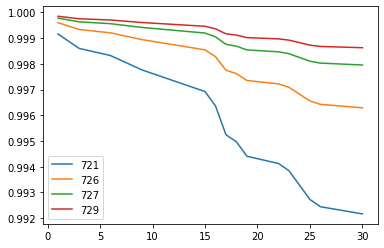

In [124]:
# cph_urti_no_abs_incdt.predict_survival_function(data_urti_no_abs_incdt)#_train, conditional_after=data_urti_no_abs_incdt_train.duration_urti_admitted)
survival_func_plot = cph_urti_no_abs_incdt.predict_survival_function(data_urti_no_abs_incdt)
plt.plot(survival_func_plot.loc[:, 720:729])
plt.legend(labels=survival_func_plot.loc[:, 720:729].columns, loc ="lower left")

In [125]:
# cph_urti_no_abs_incdt.plot_partial_effects_on_outcome(data_urti_no_abs_incdt.event_urti_admitted, values=[0, 2, 4, 6, 8, 10], cmap='coolwarm')

In [126]:
a = cph_urti_no_abs_incdt.baseline_hazard_
# cph_urti_no_abs_incdt.baseline_survival_
# cph_urti_no_abs_incdt.predict_cumulative_hazard(data_urti_no_abs_incdt, data_urti_no_abs_incdt['duration_urti_admitted']<=30)
# cph_urti_no_abs_incdt.predict_survival_function(data_urti_no_abs_incdt)

# save 
np.savetxt('../output/hospitalisation_prediction_urti/betas_cph_urti_no_abs_incdt.txt', a, delimiter=',')

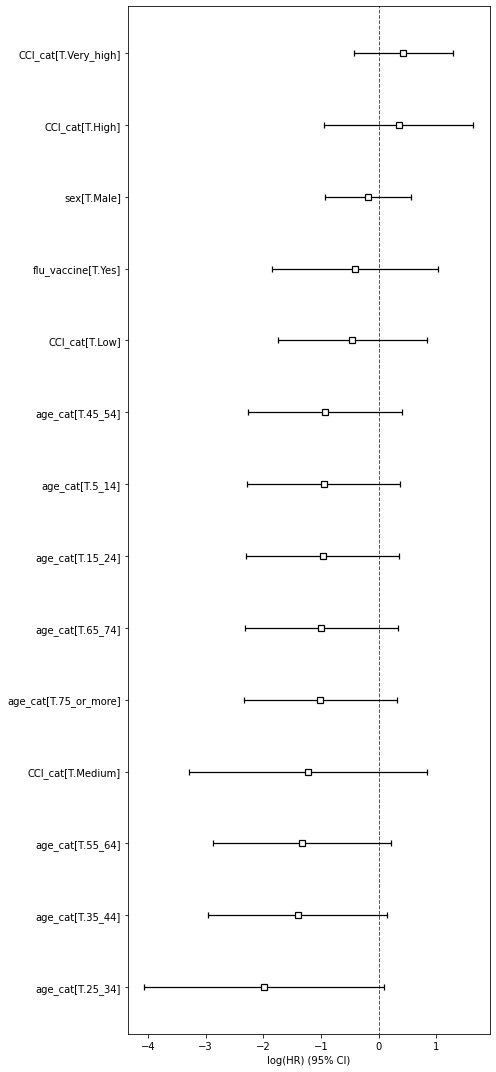

In [127]:
fig, ax = plt.subplots(figsize=(7, 15)
                        )
cph_urti_no_abs_incdt.plot()
# plt.suptitle('Coefficients of CPH model for incident hospital admission \n related to URTI with no antibiotics', fontsize=16)
#_ = ax.set_yticklabels(['Age', 'BMI', 'GP consultations', 'CCI', 'IMD', 'Flu vaccine', 'Antibacterial prescriptions'], 
#                        rotation=45, fontsize=12, ha='right')
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/coef_cph_urti_no_abs_incdt.jpg', bbox_inches='tight')
plt.show()

In [128]:
# concordance index of cph model with training data
concord_index_urti_no_abs_incdt_train = concordance_index(data_urti_no_abs_incdt_train['duration_urti_admitted'], -cph_urti_no_abs_incdt.predict_partial_hazard(data_urti_no_abs_incdt_train), data_urti_no_abs_incdt_train['event_urti_admitted'])
print(f'Concordance index for urti_no_abs_incdt with training data: {concord_index_urti_no_abs_incdt_train}')

# concordance index of cph model with testing data
concord_index_urti_no_abs_incdt_test = concordance_index(data_urti_no_abs_incdt_test['duration_urti_admitted'], -cph_urti_no_abs_incdt.predict_partial_hazard(data_urti_no_abs_incdt_test), data_urti_no_abs_incdt_test['event_urti_admitted'])
print(f'Concordance index for urti_no_abs_incdt with testing data: {concord_index_urti_no_abs_incdt_test}')
# print(concordance_index(data_urti_no_abs_incdt_test['event_urti_admitted'], -cph_urti_no_abs_incdt.predict_partial_hazard(data_urti_no_abs_incdt_test), data_urti_no_abs_incdt_test['duration_urti_admitted']))

Concordance index for urti_no_abs_incdt with training data: 0.6845891412418365
Concordance index for urti_no_abs_incdt with testing data: 0.5138843381389253


<AxesSubplot:>

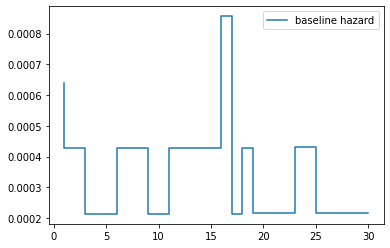

In [129]:
cph_urti_no_abs_incdt.baseline_hazard_.plot(drawstyle="steps")
# baseline hazard: the baseline hazard evaluated at the observed times. Estimated using Breslow’s method.

<AxesSubplot:>

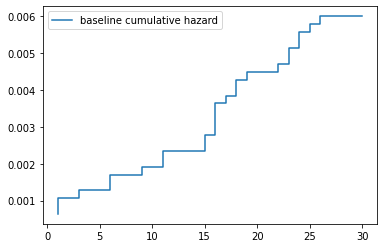

In [130]:
cph_urti_no_abs_incdt.baseline_cumulative_hazard_.plot(drawstyle="steps")
# baseline cumulative hazard: the baseline cumulative hazard evaluated at the observed times. Estimated using Breslow’s method.

<AxesSubplot:>

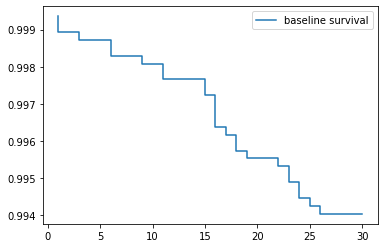

In [131]:
cph_urti_no_abs_incdt.baseline_survival_.plot(drawstyle="steps")
# baseline survival: the baseline survival evaluated at the observed times. Estimated using Breslow’s method

In [132]:
# cph_urti_no_abs_incdt.predict_cumulative_hazard(data_urti_no_abs_incdt, data_urti_no_abs_incdt['duration_urti_admitted']<=30)

In [133]:
# cph_urti_no_abs_incdt.predict_survival_function(data_urti_no_abs_incdt)

In [134]:
# # cph_urti_no_abs_incdt.predict_survival_function(data_urti_no_abs_incdt).mean()

# cph_urti_no_abs_incdt.predict_survival_function(data_urti_no_abs_incdt).loc[[30]]#.mean()

In [135]:
# fig, ax = plt.subplots(figsize=(5, 5)
#                         )
# cph_urti_no_abs_incdt.baseline_survival_.plot(drawstyle="steps", ax=ax)
# # cph_urti_no_abs_incdt.baseline_survival_.plot(ax=ax)
# plt.suptitle('Baseline survival of CPH model for incident hospital\n admission related to URTI with no antibiotics', fontsize=16)
# plt.tight_layout()
# # plt.savefig('../output/hospitalisation_prediction_urti/coef_cph_urti_no_abs_incdt.jpg', bbox_inches='tight')
# plt.show()

In [136]:
# a = [concord_index_urti_no_abs_incdt_test]
# np.savetxt('../output/hospitalisation_prediction_urti/concord_index_urti_no_abs_incdt_test.txt', a, delimiter=',')

In [137]:
# fig, ax = plt.subplots(figsize=(8, 5)
#                         )
# survival_probability_calibration(cph_urti_no_abs_incdt, data_urti_no_abs_incdt_train, t0=30)
# # plt.suptitle('Calibration of CPH model for incident hospital admission related to urti with no antibiotics', fontsize=16)
# plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_no_abs_incdt_train.jpg', bbox_inches='tight')
# plt.show()

# # t0 (float) – the time to evaluate the probability of event occurring prior at.
# # ICI – mean absolute difference between predicted and observed
# # E50 – median absolute difference between predicted and observed

In [138]:
# fig, ax = plt.subplots(figsize=(8, 5)
#                         )
# survival_probability_calibration(cph_urti_no_abs_incdt, data_urti_no_abs_incdt_test, t0=30)
# # plt.suptitle('Calibration of CPH model for incident hospital admission related to URTI with no antibiotics', fontsize=16)
# plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_no_abs_incdt_test.jpg', bbox_inches='tight')
# plt.show()

In [139]:
cph_urti_no_abs_incdt_train_cumulative_hazard = cph_urti_no_abs_incdt.predict_cumulative_hazard(data_urti_no_abs_incdt_train)

cph_urti_no_abs_incdt_train_cumulative_hazard = cph_urti_no_abs_incdt_train_cumulative_hazard.loc[[30]].T

cph_urti_no_abs_incdt_train_cumulative_hazard['event_urti_admitted'] = data_urti_no_abs_incdt_train['event_urti_admitted']

cph_urti_no_abs_incdt_train_cumulative_hazard = cph_urti_no_abs_incdt_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, 
                                                inplace=False)

cph_urti_no_abs_incdt_train_cumulative_hazard

,cumulative_hazard,event_urti_admitted
1107,0.010379,0.0
2141,0.021646,0.0
7129,0.021272,0.0
2901,0.002426,0.0
4357,0.004394,0.0
...,...,...
6539,0.011143,0.0
689,0.012837,0.0
4564,0.001914,0.0
5598,0.001654,0.0


In [140]:
cph_urti_no_abs_incdt_test_cumulative_hazard = cph_urti_no_abs_incdt.predict_cumulative_hazard(data_urti_no_abs_incdt_test)

cph_urti_no_abs_incdt_test_cumulative_hazard = cph_urti_no_abs_incdt_test_cumulative_hazard.loc[[30]].T

cph_urti_no_abs_incdt_test_cumulative_hazard['event_urti_admitted'] = data_urti_no_abs_incdt_test['event_urti_admitted']

cph_urti_no_abs_incdt_test_cumulative_hazard = cph_urti_no_abs_incdt_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, 
                                                inplace=False)

cph_urti_no_abs_incdt_test_cumulative_hazard

,cumulative_hazard,event_urti_admitted
6869,0.001537,0.0
5243,0.012527,0.0
1353,0.001537,0.0
4177,0.007133,0.0
4582,0.008388,0.0
...,...,...
776,0.005183,0.0
5444,0.007257,0.0
55,0.004329,0.0
4183,0.004136,0.0


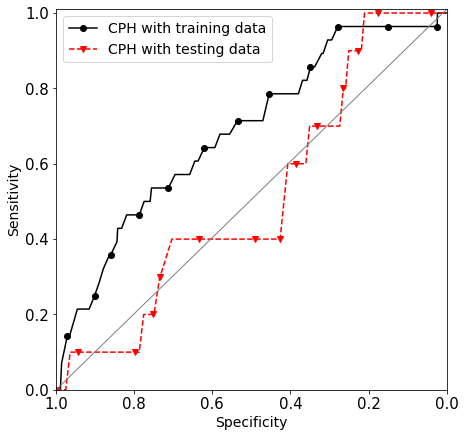

In [141]:
r_fpr1, r_tpr1, _ = roc_curve(cph_urti_no_abs_incdt_train_cumulative_hazard.event_urti_admitted, cph_urti_no_abs_incdt_train_cumulative_hazard.cumulative_hazard)
r_fpr2, r_tpr2, _ = roc_curve(cph_urti_no_abs_incdt_test_cumulative_hazard.event_urti_admitted, cph_urti_no_abs_incdt_test_cumulative_hazard.cumulative_hazard)

fig, ax1 = pyplot.subplots(figsize=(7, 7))

line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='CPH with training data')
line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='CPH with testing data')

squares = [0,1.01]
plt.plot(squares,linewidth=1, color='grey')
plt.ylim(0,1.01)
plt.xlim(0,1)
plt.xlabel('Specificity', fontsize=14)
plt.ylabel('Sensitivity', fontsize=14)

#reversing xticks
xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
x = np.arange(len(xticks))
ax1.set(xticklabels=xticks)
ax1.legend(fontsize=14)
# plt.title('ROC curve of CPH for hospital admission related to incident \nURTI with no antibiotics', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15, rotation=0)
# plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/roc_cph_urti_no_abs_incdt.jpg', bbox_inches='tight')
plt.show()

In [142]:
r_auc1 = roc_auc_score(cph_urti_no_abs_incdt_train_cumulative_hazard.event_urti_admitted, cph_urti_no_abs_incdt_train_cumulative_hazard.cumulative_hazard)
r_auc2 = roc_auc_score(cph_urti_no_abs_incdt_test_cumulative_hazard.event_urti_admitted, cph_urti_no_abs_incdt_test_cumulative_hazard.cumulative_hazard)
brier1 = brier_score_loss(cph_urti_no_abs_incdt_train_cumulative_hazard.event_urti_admitted, cph_urti_no_abs_incdt_train_cumulative_hazard.cumulative_hazard)
brier2 = brier_score_loss(cph_urti_no_abs_incdt_test_cumulative_hazard.event_urti_admitted, cph_urti_no_abs_incdt_test_cumulative_hazard.cumulative_hazard)

print('AUROC of CPH with training data of hospital admission related to incident URTI with no antibiotics = %.4f' % (r_auc1))
print('AUROC of CPH with testing data of hospital admission related to incident URTI with no antibiotics = %.4f' % (r_auc2))
print('Brier score of CPH with training data of hospital admission related to incident URTI with no antibiotics = %.4f' % (brier1))
print('Brier score of CPH with testing data of hospital admission related to incident URTI with no antibiotics = %.4f' % (brier2))

AUROC of CPH with training data of hospital admission related to incident URTI with no antibiotics = 0.6850
AUROC of CPH with testing data of hospital admission related to incident URTI with no antibiotics = 0.5139
Brier score of CPH with training data of hospital admission related to incident URTI with no antibiotics = 0.0075
Brier score of CPH with testing data of hospital admission related to incident URTI with no antibiotics = 0.0081


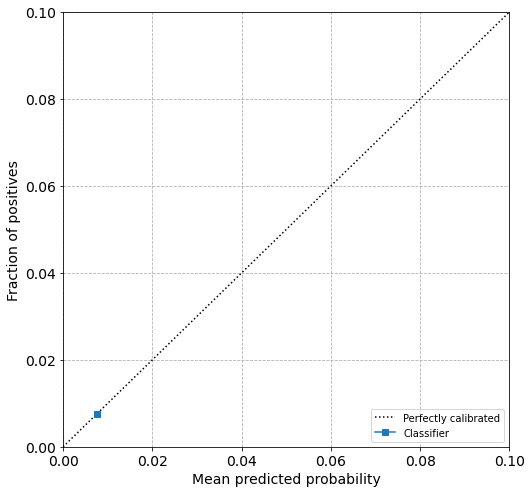

In [143]:
fig, axe = plt.subplots(figsize=(8, 8)
                        )

calib_cph_urti_no_abs_incdt_train = CalibrationDisplay.from_predictions(cph_urti_no_abs_incdt_train_cumulative_hazard.event_urti_admitted, cph_urti_no_abs_incdt_train_cumulative_hazard.cumulative_hazard, ax = axe)
# plt.suptitle('Calibration of CPH model with training data of incident hospital admission \n related to URTI with no antibiotics', fontsize=16)
plt.xlabel('Mean predicted probability', fontsize=14)
plt.ylabel('Fraction of positives', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(visible=bool, linestyle='--')
plt.xlim(0, 0.1)
plt.ylim(0, 0.1)
# plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/calib_cph_urti_no_abs_incdt_train.jpg', bbox_inches='tight')
plt.show()

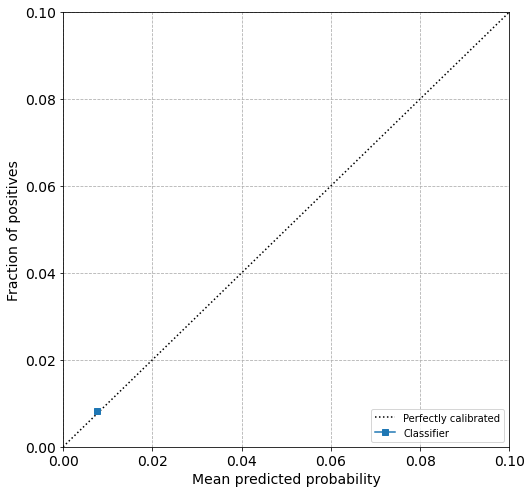

In [144]:
fig, axe = plt.subplots(figsize=(8, 8)
                        )

calib_cph_urti_no_abs_incdt_test = CalibrationDisplay.from_predictions(cph_urti_no_abs_incdt_test_cumulative_hazard.event_urti_admitted, cph_urti_no_abs_incdt_test_cumulative_hazard.cumulative_hazard, ax = axe)
# plt.suptitle('Calibration of CPH model with testing data of incident hospital admission \n related to URTI with no antibiotics', fontsize=16)
plt.xlabel('Mean predicted probability', fontsize=14)
plt.ylabel('Fraction of positives', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(visible=bool, linestyle='--')
plt.xlim(0, 0.1)
plt.ylim(0, 0.1)
# plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/calib_cph_urti_no_abs_incdt_test.jpg', bbox_inches='tight')
plt.show()

In [145]:
# save model outputs
a = open("../output/hospitalisation_prediction_urti/cph_urti_no_abs_incdt_output.txt", "w")
a.write("")
a.writelines(['Concordance index for urti_no_abs_incdt with testing data: %.4f' % (concord_index_urti_no_abs_incdt_test), 
              '\nConcordance index for urti_no_abs_incdt with training data: %.4f' % (concord_index_urti_no_abs_incdt_train),
              '\nAUROC of CPH with training data of hospital admission related to incident URTI with no antibiotics = %.4f' % (r_auc1),
              '\nAUROC of CPH with testing data of hospital admission related to incident URTI with no antibiotics = %.4f' % (r_auc2),
              '\nBrier score of CPH with training data of hospital admission related to incident URTI with no antibiotics = %.4f' % (brier1),
              '\nBrier score of CPH with testing data of hospital admission related to incident URTI with no antibiotics = %.4f' % (brier2)])

#### 4-1-2- Incident hospital admission related to URTI with antibiotics

In [156]:
data_urti_abs_incdt.columns

Index(['age_cat', 'sex', 'CCI_cat', 'gp_count_cat', 'flu_vaccine', 'bmi_cat',
       'region', 'imd', 'ethnicity', 'smoking_status', 'season',
       'antibacterial_brit_cat', 'meds_nonabs_cat', 'hx_hosp_cat',
       'event_urti_admitted', 'duration_urti_admitted', 'gp_cons_urti_ab',
       'incdt_urti_date'],
      dtype='object')

In [157]:
data_urti_abs_incdt.shape

(562, 18)

In [158]:
#keep relevant variables
data_urti_abs_incdt = data_urti_abs_incdt[['age_cat', 'sex', 'CCI_cat', 'gp_count_cat', 'flu_vaccine', 'bmi_cat', 'region', 
                                           'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit_cat', 
                                           'meds_nonabs_cat', 'hx_hosp_cat', 'event_urti_admitted', 'duration_urti_admitted']]

In [159]:
# printing number of missing values in each variable 
data_urti_abs_incdt.isnull().sum()

age_cat                   0
sex                       0
CCI_cat                   0
gp_count_cat              0
flu_vaccine               0
bmi_cat                   0
region                    0
imd                       0
ethnicity                 0
smoking_status            0
season                    0
antibacterial_brit_cat    0
meds_nonabs_cat           0
hx_hosp_cat               0
event_urti_admitted       0
duration_urti_admitted    0
dtype: int64

In [160]:
# encoding categorical data for CPH
data = data_urti_abs_incdt[['age_cat', 'sex', 'CCI_cat', 'gp_count_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit_cat', 'meds_nonabs_cat', 'hx_hosp_cat', 'event_urti_admitted', 'duration_urti_admitted']].reset_index()
# data

# creating instance of one-hot-encoder
enc = OneHotEncoder()
results = enc.fit_transform(data)
# passing bridge-types-cat column (label encoded values of bridge_types)
data_urti_abs_incdt_enc = pd.DataFrame(enc.fit_transform(data[['age_cat', 'sex', 'CCI_cat', 'gp_count_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit_cat', 'meds_nonabs_cat', 'hx_hosp_cat']]).toarray())
data_urti_abs_incdt_enc.columns = enc.get_feature_names(data[['age_cat', 'sex', 'CCI_cat', 'gp_count_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit_cat', 'meds_nonabs_cat', 'hx_hosp_cat']].columns)
# data_urti_abs_incdt_enc = data[['event_urti_admitted', 'duration_urti_admitted']].join(data_urti_abs_incdt_enc)
# data_urti_abs_incdt_enc = data_urti_abs_incdt_enc.drop(columns=['index', ])

data_urti_abs_incdt_enc.head()

,age_cat_0_4,age_cat_15_24,age_cat_25_34,age_cat_35_44,age_cat_45_54,age_cat_5-14,age_cat_55_64,age_cat_65_74,age_cat_75_or_more,sex_Female,...,antibacterial_brit_cat_Very_low,meds_nonabs_cat_High,meds_nonabs_cat_Low,meds_nonabs_cat_Medium,meds_nonabs_cat_Very_high,meds_nonabs_cat_Very_low,hx_hosp_cat_High,hx_hosp_cat_Low,hx_hosp_cat_Medium,hx_hosp_cat_Very_low
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [161]:
#randomly splitting data into training (%75) and testing (%25)
data_urti_abs_incdt_train, data_urti_abs_incdt_test = train_test_split(data_urti_abs_incdt, test_size=0.25, random_state=42)

print(f'shape of data_urti_abs_incdt for training: {data_urti_abs_incdt_train.shape}')
print(f'shape of data_urti_abs_incdt for testing: {data_urti_abs_incdt_test.shape}')

shape of data_urti_abs_incdt for training: (421, 16)
shape of data_urti_abs_incdt for testing: (141, 16)


In [165]:
cph_urti_abs_incdt = CoxPHFitter().fit(data_urti_abs_incdt_train,
        duration_col='duration_urti_admitted',
        event_col='event_urti_admitted',
        formula="age_cat + sex + CCI_cat + flu_vaccine + region"# + gp_count_cat + bmi_cat + region + imd"# + ethnicity + smoking_status + season + antibacterial_brit_cat + meds_nonabs_cat + hx_hosp_cat"
        )
cph_urti_abs_incdt.print_summary()

In [ ]:
output = GetPrintSummary(cph_urti_abs_incdt)

with open('../output/hospitalisation_prediction_urti/cph_urti_abs_incdt_summary.html', "w") as fo:
    print(fo.write(output))
    fo.close()

16050


In [164]:
a = cph_urti_abs_incdt.baseline_hazard_

# save 
np.savetxt('../output/hospitalisation_prediction_urti/betas_cph_urti_abs_incdt.txt', a, delimiter=',')

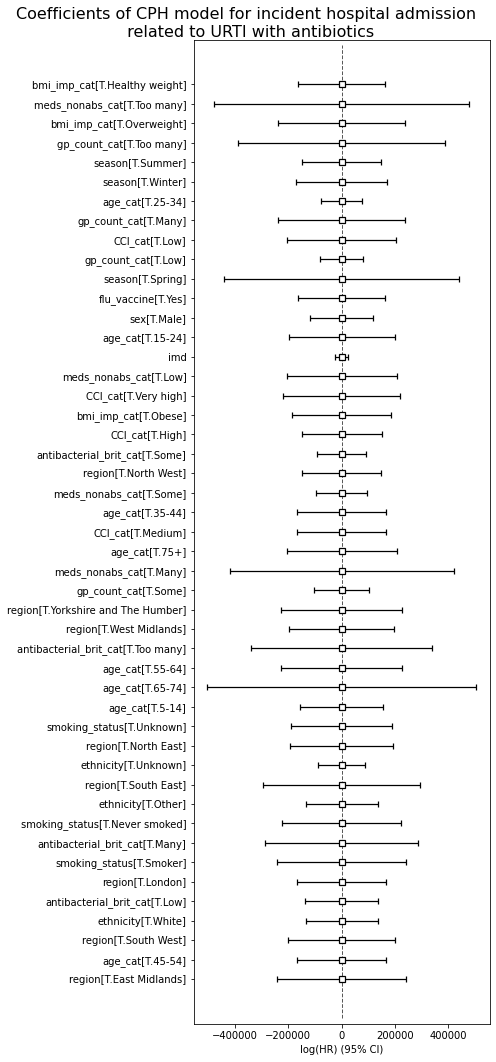

In [413]:
fig, ax = plt.subplots(figsize=(7, 15)
                        )
cph_urti_abs_incdt.plot()
plt.suptitle('Coefficients of CPH model for incident hospital admission \n related to URTI with antibiotics', fontsize=16)
#_ = ax.set_yticklabels(['Age', 'BMI', 'GP consultations', 'CCI', 'IMD', 'Flu vaccine', 'Antibacterial prescriptions'], 
#                        rotation=45, fontsize=12, ha='right')
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/coef_cph_urti_abs_incdt.jpg', bbox_inches='tight')
plt.show()

In [414]:
# concordance index of cph model with training data
concord_index_urti_abs_incdt_train = concordance_index(data_urti_abs_incdt_train['duration_urti_admitted'], -cph_urti_abs_incdt.predict_partial_hazard(data_urti_abs_incdt_train), data_urti_abs_incdt_train['event_urti_admitted'])
print(f'Concordance index for urti_abs_incdt with training data: {concord_index_urti_abs_incdt_train}')

# concordance index of cph model with testing data
concord_index_urti_abs_incdt_test = concordance_index(data_urti_abs_incdt_test['duration_urti_admitted'], -cph_urti_abs_incdt.predict_partial_hazard(data_urti_abs_incdt_test), data_urti_abs_incdt_test['event_urti_admitted'])
print(f'Concordance index for urti_abs_incdt with testing data: {concord_index_urti_abs_incdt_test}')

Concordance index for urti_abs_incdt with training data: 1.0
Concordance index for urti_abs_incdt with testing data: 0.37065637065637064


In [ ]:
# cleaning up covariates to make them compatible with the encoded data
covariates = cph_urti_abs_incdt.params_.reset_index()#.covariate
covariates.covariate = covariates.covariate.str.replace("[","")
covariates.covariate = covariates.covariate.str.replace("]","")
covariates.covariate = covariates.covariate.str.replace("T.","_")
covariates

In [ ]:
# further cleaning up covariates to make them compatible with the encoded data
mylist = ["'" + item + "'" for item in covariates.covariate] #adds single quotation mark
mylist = [value.replace("'", "") for value in mylist] #removes double quotation mark 
data = data_urti_abs_incdt_enc[data_urti_abs_incdt_enc.columns.intersection(mylist)] #match mylist (covariates of cox model) with encoded data
data = data.sort_index(axis = 1) #sort 
data

In [ ]:
# transpose and sort covariates and coefficients
covariatesT = covariates.T
# covariatesT.covariate = covariates
header = covariatesT.iloc[0]
covariatesT = covariatesT[1:]
covariatesT.columns = header
covariatesT = covariatesT.sort_index(axis = 1) #sort covariates to match data
covariatesT

In [ ]:
# #calculate sum of betas by multiplying coefs by each column
# dataT = data.T
# betas = dataT.multiply(dataT["coef"], axis=0)
# sum_betas = betas.sum()
# sum_betas#.head(10)

In [ ]:
# transpose transposed and sorted covariates and coefficients
covariates = covariatesT.T.reset_index()
covariates

In [ ]:
# multiply betas and encoded data
betas = data.multiply(np.array(covariatesT), axis='columns')
betas

In [ ]:
# sum up betas of each row to calculate sum of betas 
sum_betas = betas.sum(axis=1)
sum_betas

In [ ]:
# predict cumulative hazard values at day 30 and match them with sum of betas
sum_betas_hazard = cph_urti_abs_incdt.predict_cumulative_hazard(data_urti_abs_incdt).loc[[30]].T.reset_index(drop=True)
sum_betas_hazard['sum_betas'] = sum_betas
sum_betas_hazard

In [ ]:
# sort values of sum of betas
sum_betas_hazard = sum_betas_hazard.sort_values(by=['sum_betas'])
sum_betas_hazard

In [ ]:
# binning sum of betas into 100 bins
sum_betas_hazard['bins'] = pd.cut(sum_betas_hazard['sum_betas'], 50) #50 intervals between min and max of sum_betas
sum_betas_hazard

In [ ]:
#calculate mean of cumulative hazar at day 30 by groupby 
sum_betas_hazard_groupby = sum_betas_hazard.groupby(['bins'])[30.0].describe().reset_index()
sum_betas_hazard_groupby

In [ ]:
sum_betas_hazard_groupby['mean_interpolate'] = sum_betas_hazard_groupby['mean'].interpolate(method='linear')
sum_betas_hazard_groupby['bin_lower'] = sum_betas_hazard_groupby['bins'].map(attrgetter('left'))
sum_betas_hazard_groupby['bin_upper'] = sum_betas_hazard_groupby['bins'].map(attrgetter('right'))
sum_betas_hazard_groupby

In [ ]:
# calculate interpolation of missing mean values 
sum_betas = sum_betas_hazard_groupby[['bin_lower', 'bin_upper', 'mean', 'mean_interpolate']]

# separate upper and lower boundries of bins
sum_betas.to_csv('../output/hospitalisation_prediction_urti/sum_betas_cph_urti_abs_incdt.csv', index=False)
np.savetxt('../output/hospitalisation_prediction_urti/sum_betas_cph_urti_abs_incdt.txt', sum_betas, delimiter=',')

In [143]:
# a = [concord_index_urti_abs_incdt_test]
# np.savetxt('../output/hospitalisation_prediction_urti/concord_index_urti_abs_incdt_test.txt', a, delimiter=',')

In [144]:
# fig, ax = plt.subplots(figsize=(8, 5)
#                         )
# survival_probability_calibration(cph_urti_abs_incdt, data_urti_abs_incdt_train, t0=30)
# # plt.suptitle('Calibration of CPH model for incident hospital admission related to URTI with antibiotics', fontsize=16)
# plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_abs_incdt_train.jpg', bbox_inches='tight')
# plt.show()

In [145]:
# survival_probability_calibration(cph_urti_abs_incdt, data_urti_abs_incdt, t0=30)

In [146]:
# survival_probability_calibration(cph_urti_abs_incdt, data_urti_abs_incdt_train, t0=30)

In [147]:
# fig, ax = plt.subplots(figsize=(8, 5)
#                         )
# survival_probability_calibration(cph_urti_abs_incdt, data_urti_abs_incdt_test, t0=30)
# # plt.suptitle('Calibration of CPH model for incident hospital admission related to urti with antibiotics', fontsize=16)
# plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_abs_incdt_test.jpg', bbox_inches='tight')
# plt.show()

In [415]:
cph_urti_abs_incdt_train_cumulative_hazard = cph_urti_abs_incdt.predict_cumulative_hazard(data_urti_abs_incdt_train)

cph_urti_abs_incdt_train_cumulative_hazard = cph_urti_abs_incdt_train_cumulative_hazard.loc[[30]].T

cph_urti_abs_incdt_train_cumulative_hazard['event_urti_admitted'] = data_urti_abs_incdt_train['event_urti_admitted']

cph_urti_abs_incdt_train_cumulative_hazard = cph_urti_abs_incdt_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, 
                                                inplace=False)

cph_urti_abs_incdt_train_cumulative_hazard

,cumulative_hazard,event_urti_admitted
238,2.303899e-58,0.0
4855,3.170519e-84,0.0
857,4.896160e-31,0.0
5057,2.691161e-44,0.0
4949,2.760694e-58,0.0
...,...,...
1078,2.420672e-11,0.0
1586,1.740721e-55,0.0
3763,7.778710e-10,0.0
5938,3.282876e-56,0.0


In [416]:
cph_urti_abs_incdt_test_cumulative_hazard = cph_urti_abs_incdt.predict_cumulative_hazard(data_urti_abs_incdt_test)

cph_urti_abs_incdt_test_cumulative_hazard = cph_urti_abs_incdt_test_cumulative_hazard.loc[[30]].T

cph_urti_abs_incdt_test_cumulative_hazard['event_urti_admitted'] = data_urti_abs_incdt_test['event_urti_admitted']

cph_urti_abs_incdt_test_cumulative_hazard = cph_urti_abs_incdt_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, 
                                                inplace=False)

cph_urti_abs_incdt_test_cumulative_hazard

,cumulative_hazard,event_urti_admitted
7210,3.029335e-32,0.0
5294,3.546022e-50,0.0
105,2.516353e-28,0.0
2586,1.213393e-15,0.0
1197,6.136255e-60,0.0
...,...,...
4956,7.014151e-49,0.0
1262,5.282242e-19,0.0
6260,1.193807e-39,0.0
2774,3.881340e-56,0.0


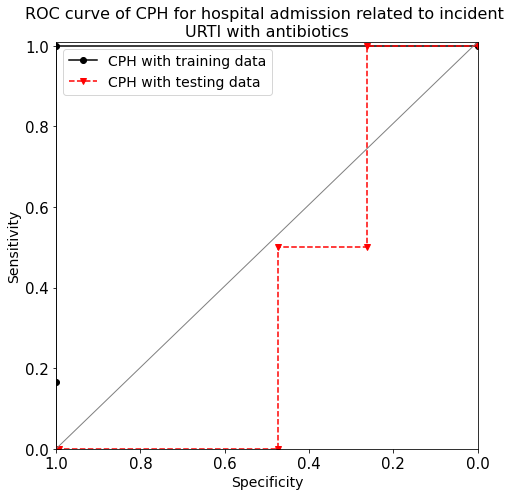

In [417]:
r_fpr1, r_tpr1, _ = roc_curve(cph_urti_abs_incdt_train_cumulative_hazard.event_urti_admitted, cph_urti_abs_incdt_train_cumulative_hazard.cumulative_hazard)
r_fpr2, r_tpr2, _ = roc_curve(cph_urti_abs_incdt_test_cumulative_hazard.event_urti_admitted, cph_urti_abs_incdt_test_cumulative_hazard.cumulative_hazard)

fig, ax1 = pyplot.subplots(figsize=(7, 7))

line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='CPH with training data')
line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='CPH with testing data')

squares = [0,1.01]
plt.plot(squares,linewidth=1, color='grey')
plt.ylim(0,1.01)
plt.xlim(0,1)
plt.xlabel('Specificity', fontsize=14)
plt.ylabel('Sensitivity', fontsize=14)

#reversing xticks
xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
x = np.arange(len(xticks))
ax1.set(xticklabels=xticks)
ax1.legend(fontsize=14)
plt.title('ROC curve of CPH for hospital admission related to incident \nURTI with antibiotics', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15, rotation=0)
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/roc_cph_urti_abs_incdt.jpg', bbox_inches='tight')
plt.show()

In [418]:
cph_urti_abs_incdt_test_cumulative_hazard.cumulative_hazard.max()

6.824949744368739e+20

In [419]:
# cph_urti_abs_incdt_train_cumulative_hazard.describe()
cph_urti_abs_incdt_train_cumulative_hazard.cumulative_hazard.max()

5.806123413222461e+30

In [420]:
cph_urti_abs_incdt_train_cumulative_hazard.shape

(392, 2)

In [421]:
cph_urti_abs_incdt_train_cumulative_hazard = cph_urti_abs_incdt_train_cumulative_hazard[cph_urti_abs_incdt_train_cumulative_hazard.cumulative_hazard <= 1]
cph_urti_abs_incdt_train_cumulative_hazard.max()

cumulative_hazard      7.125602e-09
event_urti_admitted    0.000000e+00
dtype: float64

In [422]:
cph_urti_abs_incdt_train_cumulative_hazard.shape

(386, 2)

In [424]:
r_auc1 = roc_auc_score(cph_urti_abs_incdt_train_cumulative_hazard.event_urti_admitted, cph_urti_abs_incdt_train_cumulative_hazard.cumulative_hazard)
r_auc2 = roc_auc_score(cph_urti_abs_incdt_test_cumulative_hazard.event_urti_admitted, cph_urti_abs_incdt_test_cumulative_hazard.cumulative_hazard)
brier1 = brier_score_loss(cph_urti_abs_incdt_train_cumulative_hazard.event_urti_admitted, cph_urti_abs_incdt_train_cumulative_hazard.cumulative_hazard)
brier2 = brier_score_loss(cph_urti_abs_incdt_test_cumulative_hazard.event_urti_admitted, cph_urti_abs_incdt_test_cumulative_hazard.cumulative_hazard)

print('AUROC of CPH with training data of hospital admission related to incident URTI with antibiotics = %.4f' % (r_auc1))
print('AUROC of CPH with testing data of hospital admission related to incident URTI with antibiotics = %.4f' % (r_auc2))
print('Brier score of CPH with training data of hospital admission related to incident URTI with antibiotics = %.4f' % (brier1))
print('Brier score of CPH with testing data of hospital admission related to incident URTI with antibiotics = %.4f' % (brier2))

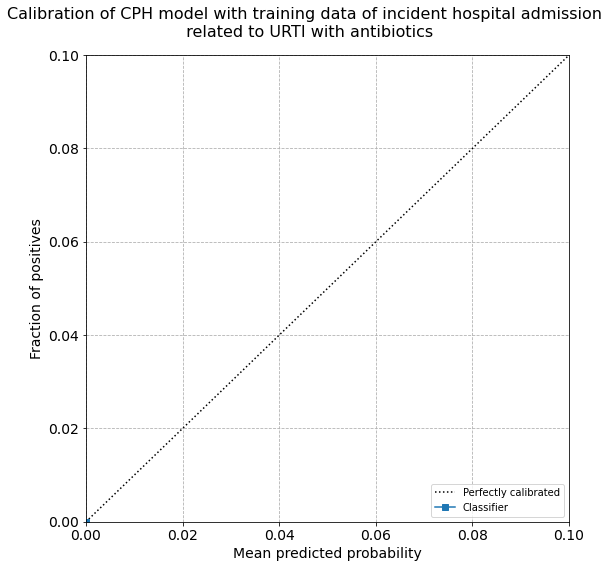

In [428]:
fig, axe = plt.subplots(figsize=(8, 8)
                        )

calib_cph_urti_abs_incdt_train = CalibrationDisplay.from_predictions(cph_urti_abs_incdt_train_cumulative_hazard.event_urti_admitted, cph_urti_abs_incdt_train_cumulative_hazard.cumulative_hazard, ax = axe)
plt.suptitle('Calibration of CPH model with training data of incident hospital admission \n related to URTI with antibiotics', fontsize=16)
plt.xlabel('Mean predicted probability', fontsize=14)
plt.ylabel('Fraction of positives', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(visible=bool, linestyle='--')
plt.xlim(0, 0.1)
plt.ylim(0, 0.1)
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/calib_cph_urti_abs_incdt_train.jpg', bbox_inches='tight')
plt.show()

In [430]:
fig, axe = plt.subplots(figsize=(8, 8)
                        )

calib_cph_urti_abs_incdt_train = CalibrationDisplay.from_predictions(cph_urti_abs_incdt_test_cumulative_hazard.event_urti_admitted, cph_urti_abs_incdt_test_cumulative_hazard.cumulative_hazard, ax = axe)
plt.suptitle('Calibration of CPH model with testing data of incident hospital admission \n related to URTI with antibiotics', fontsize=16)
plt.xlabel('Mean predicted probability', fontsize=14)
plt.ylabel('Fraction of positives', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(visible=bool, linestyle='--')
plt.xlim(0, 0.3)
plt.ylim(0, 0.3)
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/calib_cph_urti_abs_incdt_test.jpg', bbox_inches='tight')
plt.show()

In [431]:
# save model outputs
a = open("../output/hospitalisation_prediction_urti/cph_urti_abs_incdt_output.txt", "w")
a.write("")
a.writelines(['Concordance index for urti_abs_incdt with testing data: %.4f' % (concord_index_urti_abs_incdt_test), 
              '\nConcordance index for urti_abs_incdt with training data: %.4f' % (concord_index_urti_abs_incdt_train),
              '\nAUROC of CPH with training data of hospital admission related to incident URTI with antibiotics = %.4f' % (r_auc1),
              '\nAUROC of CPH with testing data of hospital admission related to incident URTI with antibiotics = %.4f' % (r_auc2),
              '\nBrier score of CPH with training data of hospital admission related to incident URTI with antibiotics = %.4f' % (brier1),
              '\nBrier score of CPH with testing data of hospital admission related to incident URTI with antibiotics = %.4f' % (brier2)])

#### 4-1-3- Prevalent hospital admission related to URTI with no antibiotics

In [432]:
#keep relevant variables
data_urti_no_abs_prevl = data_urti_no_abs_prevl[['age_cat', 'sex', 'CCI_cat', 'gp_count_cat', 'flu_vaccine', 'bmi_cat', 'region', 
                                           'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit_cat', 
                                           'meds_nonabs_cat', 'hx_hosp_cat', 'event_urti_admitted', 'duration_urti_admitted']]

In [433]:
# printing number of missing values in each variable 
data_urti_no_abs_prevl.isnull().sum()

age_cat                   0
sex                       0
CCI_cat                   0
gp_count_cat              0
flu_vaccine               0
bmi_imp_cat               0
region                    0
imd                       0
ethnicity                 0
smoking_status            0
season                    0
antibacterial_brit_cat    0
meds_nonabs_cat           0
event_urti_admitted       0
duration_urti_admitted    0
dtype: int64

In [591]:
# encoding categorical data for CPH
data = data_urti_no_abs_prevl[['age_cat', 'sex', 'CCI_cat', 'gp_count_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit_cat', 'meds_nonabs_cat', 'hx_hosp_cat', 'event_urti_admitted', 'duration_urti_admitted']].reset_index()
# data

# creating instance of one-hot-encoder
enc = OneHotEncoder()
results = enc.fit_transform(data)
# passing bridge-types-cat column (label encoded values of bridge_types)
data_urti_no_abs_prevl_enc = pd.DataFrame(enc.fit_transform(data[['age_cat', 'sex', 'CCI_cat', 'gp_count_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit_cat', 'meds_nonabs_cat', 'hx_hosp_cat']]).toarray())
data_urti_no_abs_prevl_enc.columns = enc.get_feature_names(data[['age_cat', 'sex', 'CCI_cat', 'gp_count_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit_cat', 'meds_nonabs_cat', 'hx_hosp_cat']].columns)
# data_urti_no_abs_prevl_enc = data[['event_urti_admitted', 'duration_urti_admitted']].join(data_urti_no_abs_prevl_enc)
# data_urti_no_abs_prevl_enc = data_urti_no_abs_prevl_enc.drop(columns=['index', ])

data_urti_no_abs_prevl_enc.head()

,age_cat_0_4,age_cat_15_24,age_cat_25_34,age_cat_35_44,age_cat_45_54,age_cat_5-14,age_cat_55_64,age_cat_65_74,age_cat_75_or_more,sex_Female,...,antibacterial_brit_cat_Very_low,meds_nonabs_cat_High,meds_nonabs_cat_Low,meds_nonabs_cat_Medium,meds_nonabs_cat_Very_high,meds_nonabs_cat_Very_low,hx_hosp_cat_High,hx_hosp_cat_Low,hx_hosp_cat_Medium,hx_hosp_cat_Very_low
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [434]:
#randomly splitting data into training (%75) and testing (%25)
data_urti_no_abs_prevl_train, data_urti_no_abs_prevl_test = train_test_split(data_urti_no_abs_prevl, test_size=0.25, random_state=42)

print(f'shape of data_urti_no_abs_prevl for training: {data_urti_no_abs_prevl_train.shape}')
print(f'shape of data_urti_no_abs_prevl for testing: {data_urti_no_abs_prevl_test.shape}')

shape of data_urti_no_abs_prevl for training: (405, 15)
shape of data_urti_no_abs_prevl for testing: (135, 15)


In [435]:
cph_urti_no_abs_prevl = CoxPHFitter().fit(data_urti_no_abs_prevl_train,
        duration_col='duration_urti_admitted',
        event_col='event_urti_admitted',
        formula="age_cat + sex + CCI_cat + flu_vaccine + region"# + gp_count_cat + bmi_cat + imd"# + ethnicity + smoking_status + season + antibacterial_brit_cat + meds_nonabs_cat + hx_hosp_cat"
        )
cph_urti_no_abs_prevl.print_summary()

<lifelines.CoxPHFitter: fitted with 405 total observations, 403 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 405
number of events observed = 2
   partial log-likelihood = -0.00
         time fit was run = 2022-05-19 18:44:11 UTC

---
                                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                  
CCI_cat[T.Low]                       2.68      14.65   25875.84        -50713.03         50718.40                 0.00                  inf
CCI_cat[T.Medium]                    0.51       1.66   37038.19        -72593.01         72594.02                 0.00                  inf
CCI_cat[T.High]                      7.66    2123.44   33054.84        -64778.63         64793.95                 0.00                  inf
CCI_cat[T.Very high]                 5.63     279.46   15095.74        -29581.48         29592.75                 0.00                  inf
age_cat[T.15-24]                     3.77      43.51   42496.04        -83286.93         83294.47                 0.00                  inf
age_cat[T.25-34]                   -12.64       0.00   47018.58        -92167.38         92142.09                 0.00                  inf
age_cat[T.35-44]                     5.87     354.22   36316.10        -71172.38         71184.12                 0.00                  inf
age_cat[T.45-54]                    -1.90       0.15   48182.70        -94438.26         94434.46                 0.00                  inf
age_cat[T.5-14]                      0.72       2.06   45663.82        -89498.72         89500.16                 0.00                  inf
age_cat[T.55-64]                    -2.12       0.12   46911.71        -91947.38         91943.14                 0.00                  inf
age_cat[T.65-74]                    -0.35       0.70   40248.94        -78886.82         78886.12                 0.00                  inf
age_cat[T.75+]                      -2.85       0.06   40483.67        -79349.38         79343.68                 0.00                  inf
antibacterial_brit_cat[T.Low]       -3.15       0.04   24686.90        -48388.59         48382.28                 0.00                  inf
antibacterial_brit_cat[T.Some]      -1.08       0.34   28991.39        -56823.15         56821.00                 0.00                  inf
antibacterial_brit_cat[T.Many]       0.13       1.13   31699.01        -62128.79         62129.04                 0.00                  inf
antibacterial_brit_cat[T.Too many]  -3.18       0.04  115060.80       -225518.20        225511.84                 0.00                  inf
bmi_imp_cat[T.Healthy weight]       -8.99       0.00   38983.04        -76414.34         76396.37                 0.00                  inf
bmi_imp_cat[T.Overweight]          -20.00       0.00   34824.86        -68275.46         68235.47                 0.00                  inf
bmi_imp_cat[T.Obese]               -14.99       0.00   21817.68        -42776.86         42746.87                 0.00                  inf
ethnicity[T.Other]                   6.21     500.13   22274.33        -43650.68         43663.11                 0.00                  inf
ethnicity[T.Unknown]                -6.22       0.00   23356.10        -45783.33         45770.89                 0.00                  inf
ethnicity[T.White]                  -6.27       0.00   20184.06        -39566.30         39553.76                 0.00                  inf
flu_vaccine[T.Yes]                   1.98       7.25   30533.87        -59843.31         59847.27                 0.00                  inf
gp_count_cat[T.Low]                 -5.11       0.01   31872.73        -62474.51         62464.28                 0

In [436]:
output = GetPrintSummary(cph_urti_no_abs_prevl)

with open('../output/hospitalisation_prediction_urti/cph_urti_no_abs_prevl_summary.html', "w") as fo:
    print(fo.write(output))
    fo.close()

15897


In [437]:
a = cph_urti_no_abs_prevl.baseline_hazard_
# cph_urti_no_abs_prevl.baseline_survival_
# cph_urti_no_abs_prevl.predict_cumulative_hazard(data_urti_no_abs_prevl, data_urti_no_abs_prevl['duration_urti_admitted']<=30)
# cph_urti_no_abs_prevl.predict_survival_function(data_urti_no_abs_prevl)

# save 
np.savetxt('../output/hospitalisation_prediction_urti/betas_cph_urti_no_abs_prevl.txt', a, delimiter=',')

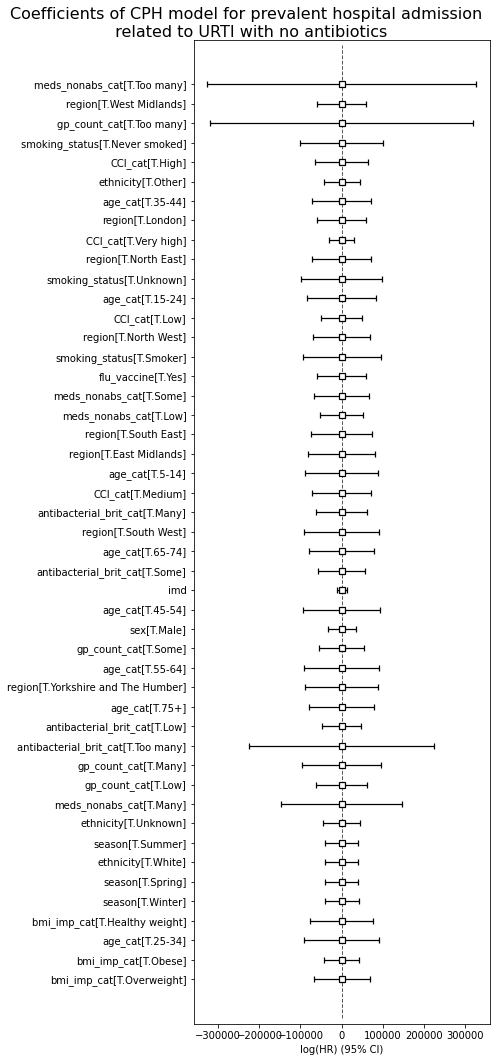

In [439]:
fig, ax = plt.subplots(figsize=(7, 15)
                        )
cph_urti_no_abs_prevl.plot()
plt.suptitle('Coefficients of CPH model for prevalent hospital admission \n related to URTI with no antibiotics', fontsize=16)
#_ = ax.set_yticklabels(['Age', 'BMI', 'GP consultations', 'CCI', 'IMD', 'Flu vaccine', 'Antibacterial prescriptions'], 
#                        rotation=45, fontsize=12, ha='right')
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/coef_cph_urti_no_abs_prevl.jpg', bbox_inches='tight')
plt.show()

In [442]:
# concordance index of cph model with training data
concord_index_urti_no_abs_prevl_train = concordance_index(data_urti_no_abs_prevl_train['duration_urti_admitted'], -cph_urti_no_abs_prevl.predict_partial_hazard(data_urti_no_abs_prevl_train), data_urti_no_abs_prevl_train['event_urti_admitted'])
print(f'Concordance index for cph_urti_no_abs_prevl with training data: {concord_index_urti_no_abs_prevl_train}')

# concordance index of cph model with testing data
concord_index_urti_no_abs_prevl_test = concordance_index(data_urti_no_abs_prevl_test['duration_urti_admitted'], -cph_urti_no_abs_prevl.predict_partial_hazard(data_urti_no_abs_prevl_test), data_urti_no_abs_prevl_test['event_urti_admitted'])
print(f'Concordance index for cph_urti_no_abs_prevl with testing data: {concord_index_urti_no_abs_prevl_test}')

In [ ]:
# cleaning up covariates to make them compatible with the encoded data
covariates = cph_urti_no_abs_prevl.params_.reset_index()#.covariate
covariates.covariate = covariates.covariate.str.replace("[","")
covariates.covariate = covariates.covariate.str.replace("]","")
covariates.covariate = covariates.covariate.str.replace("T.","_")
covariates

In [ ]:
# further cleaning up covariates to make them compatible with the encoded data
mylist = ["'" + item + "'" for item in covariates.covariate] #adds single quotation mark
mylist = [value.replace("'", "") for value in mylist] #removes double quotation mark 
data = data_urti_no_abs_incdt_enc[data_urti_no_abs_incdt_enc.columns.intersection(mylist)] #match mylist (covariates of cox model) with encoded data
data = data.sort_index(axis = 1) #sort 
data

In [ ]:
# transpose and sort covariates and coefficients
covariatesT = covariates.T
# covariatesT.covariate = covariates
header = covariatesT.iloc[0]
covariatesT = covariatesT[1:]
covariatesT.columns = header
covariatesT = covariatesT.sort_index(axis = 1) #sort covariates to match data
covariatesT

In [ ]:
# #calculate sum of betas by multiplying coefs by each column
# dataT = data.T
# betas = dataT.multiply(dataT["coef"], axis=0)
# sum_betas = betas.sum()
# sum_betas#.head(10)

In [ ]:
# transpose transposed and sorted covariates and coefficients
covariates = covariatesT.T.reset_index()
covariates

In [ ]:
# multiply betas and encoded data
betas = data.multiply(np.array(covariatesT), axis='columns')
betas

In [ ]:
# sum up betas of each row to calculate sum of betas 
sum_betas = betas.sum(axis=1)
sum_betas

In [ ]:
# predict cumulative hazard values at day 30 and match them with sum of betas
sum_betas_hazard = cph_urti_no_abs_prevl.predict_cumulative_hazard(data_urti_no_abs_prevl).loc[[30]].T.reset_index(drop=True)
sum_betas_hazard['sum_betas'] = sum_betas
sum_betas_hazard

In [ ]:
# sort values of sum of betas
sum_betas_hazard = sum_betas_hazard.sort_values(by=['sum_betas'])
sum_betas_hazard

In [ ]:
# binning sum of betas into 100 bins
sum_betas_hazard['bins'] = pd.cut(sum_betas_hazard['sum_betas'], 50) #50 intervals between min and max of sum_betas
sum_betas_hazard

In [ ]:
# calculate mean of cumulative hazar at day 30 by groupby 
sum_betas_hazard_groupby = sum_betas_hazard.groupby(['bins'])[30.0].describe().reset_index()
sum_betas_hazard_groupby

In [ ]:
# calculate interpolation of missing mean values 
sum_betas_hazard_groupby['mean_interpolate'] = sum_betas_hazard_groupby['mean'].interpolate(method='linear')

# separate upper and lower boundries of bins
sum_betas_hazard_groupby['bin_lower'] = sum_betas_hazard_groupby['bins'].map(attrgetter('left'))
sum_betas_hazard_groupby['bin_upper'] = sum_betas_hazard_groupby['bins'].map(attrgetter('right'))

sum_betas_hazard_groupby

In [ ]:
# select relevant columns including mean of cumulative hazard for each bin and the interpolation of means of cumulative hazard
sum_betas = sum_betas_hazard_groupby[['bin_lower', 'bin_upper', 'mean', 'mean_interpolate']]
# save relevant columns of sum_betas
sum_betas.to_csv('../output/hospitalisation_prediction_urti/sum_betas_cph_urti_no_abs_prevl.csv', index=False)
np.savetxt('../output/hospitalisation_prediction_urti/sum_betas_cph_urti_no_abs_prevl.txt', sum_betas, delimiter=',')

In [441]:
# a = [concord_index_urti_no_abs_prevl_test]
# np.savetxt('../output/hospitalisation_prediction_urti/concord_index_urti_no_abs_prevl_test.txt', a, delimiter=',')

In [ ]:
# fig, ax = plt.subplots(figsize=(8, 5)
#                         )
# survival_probability_calibration(cph_urti_no_abs_prevl, data_urti_no_abs_prevl_train, t0=30)
# # plt.suptitle('Calibration of CPH model for prevalent hospital admission related to URTI with no antibiotics', fontsize=16)
# plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_no_abs_prevl_train.jpg', bbox_inches='tight')
# plt.show()

In [ ]:
# fig, ax = plt.subplots(figsize=(8, 5)
#                         )
# survival_probability_calibration(cph_urti_no_abs_prevl, data_urti_no_abs_prevl_test, t0=30)
# plt.suptitle('Calibration of CPH model for prevalent hospital admission related to URTI with no antibiotics', fontsize=16)
# plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_no_abs_prevl_test.jpg', bbox_inches='tight')
# plt.show()

In [443]:
cph_urti_no_abs_prevl_train_cumulative_hazard = cph_urti_no_abs_prevl.predict_cumulative_hazard(data_urti_no_abs_prevl_train)

cph_urti_no_abs_prevl_train_cumulative_hazard = cph_urti_no_abs_prevl_train_cumulative_hazard.loc[[30]].T

cph_urti_no_abs_prevl_train_cumulative_hazard['event_urti_admitted'] = data_urti_no_abs_prevl_train['event_urti_admitted']

cph_urti_no_abs_prevl_train_cumulative_hazard = cph_urti_no_abs_prevl_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, 
                                                inplace=False)

cph_urti_no_abs_prevl_train_cumulative_hazard

,cumulative_hazard,event_urti_admitted
5230,8.915153e-14,0.0
6814,1.043153e-15,0.0
6404,6.152071e-13,0.0
3015,3.500932e-19,0.0
4040,2.042923e-13,0.0
...,...,...
1120,2.314488e-10,0.0
1678,2.660248e-11,0.0
3709,5.118561e-13,0.0
5805,8.198187e-13,0.0


In [444]:
cph_urti_no_abs_prevl_test_cumulative_hazard = cph_urti_no_abs_prevl.predict_cumulative_hazard(data_urti_no_abs_prevl_test)

cph_urti_no_abs_prevl_test_cumulative_hazard = cph_urti_no_abs_prevl_test_cumulative_hazard.loc[[30]].T

cph_urti_no_abs_prevl_test_cumulative_hazard['event_urti_admitted'] = data_urti_no_abs_prevl_test['event_urti_admitted']

cph_urti_no_abs_prevl_test_cumulative_hazard = cph_urti_no_abs_prevl_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, 
                                                inplace=False)

cph_urti_no_abs_prevl_test_cumulative_hazard

,cumulative_hazard,event_urti_admitted
3199,1.332826e-14,0.0
1148,1.846460e-15,0.0
6927,1.010035e-02,0.0
1472,7.679531e-16,0.0
6285,9.726546e-20,0.0
...,...,...
1852,1.830415e-14,0.0
5055,1.215099e-18,0.0
2968,3.206120e-20,0.0
2467,1.639591e-10,0.0


In [445]:
# cph_urti_no_abs_prevl.predict_cumulative_hazard(data_urti_no_abs_prevl_test)[[1103, 188, 6651]]

In [447]:
r_fpr1, r_tpr1, _ = roc_curve(cph_urti_no_abs_prevl_train_cumulative_hazard.event_urti_admitted, cph_urti_no_abs_prevl_train_cumulative_hazard.cumulative_hazard)
r_fpr2, r_tpr2, _ = roc_curve(cph_urti_no_abs_prevl_test_cumulative_hazard.event_urti_admitted, cph_urti_no_abs_prevl_test_cumulative_hazard.cumulative_hazard)

fig, ax1 = pyplot.subplots(figsize=(7, 7))

line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='CPH with training data')
line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='CPH with testing data')

squares = [0,1.01]
plt.plot(squares,linewidth=1, color='grey')
plt.ylim(0,1.01)
plt.xlim(0,1)
plt.xlabel('Specificity', fontsize=14)
plt.ylabel('Sensitivity', fontsize=14)

#reversing xticks
xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
x = np.arange(len(xticks))
ax1.set(xticklabels=xticks)
ax1.legend(fontsize=14)
plt.title('ROC curve of CPH for hospital admission related to prevalent \nURTI with no antibiotics', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15, rotation=0)
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/roc_cph_urti_no_abs_prevl.jpg', bbox_inches='tight')
plt.show()

In [169]:
cph_urti_no_abs_prevl_train_cumulative_hazard.shape

(429, 2)

In [170]:
cph_urti_no_abs_prevl_train_cumulative_hazard.max()

cumulative_hazard      7.106619
event_urti_admitted    1.000000
dtype: float64

In [171]:
cph_urti_no_abs_prevl_train_cumulative_hazard = cph_urti_no_abs_prevl_train_cumulative_hazard[cph_urti_no_abs_prevl_train_cumulative_hazard.cumulative_hazard <= 1]
cph_urti_no_abs_prevl_train_cumulative_hazard.max()

cumulative_hazard      0.669541
event_urti_admitted    1.000000
dtype: float64

In [172]:
cph_urti_no_abs_prevl_train_cumulative_hazard.shape

(426, 2)

In [318]:
r_auc1 = roc_auc_score(cph_urti_no_abs_prevl_train_cumulative_hazard.event_urti_admitted, cph_urti_no_abs_prevl_train_cumulative_hazard.cumulative_hazard)
r_auc2 = roc_auc_score(cph_urti_no_abs_prevl_test_cumulative_hazard.event_urti_admitted, cph_urti_no_abs_prevl_test_cumulative_hazard.cumulative_hazard)
brier1 = brier_score_loss(cph_urti_no_abs_prevl_train_cumulative_hazard.event_urti_admitted, cph_urti_no_abs_prevl_train_cumulative_hazard.cumulative_hazard)
brier2 = brier_score_loss(cph_urti_no_abs_prevl_test_cumulative_hazard.event_urti_admitted, cph_urti_no_abs_prevl_test_cumulative_hazard.cumulative_hazard)

print('AUROC of CPH with training data of hospital admission related to prevalent URTI with no antibiotics = %.4f' % (r_auc1))
print('AUROC of CPH with testing data of hospital admission related to prevalent URTI with no antibiotics = %.4f' % (r_auc2))
print('Brier score of CPH with training data of hospital admission related to prevalent URTI with no antibiotics = %.4f' % (brier1))
print('Brier score of CPH with testing data of hospital admission related to prevalent URTI with no antibiotics = %.4f' % (brier2))

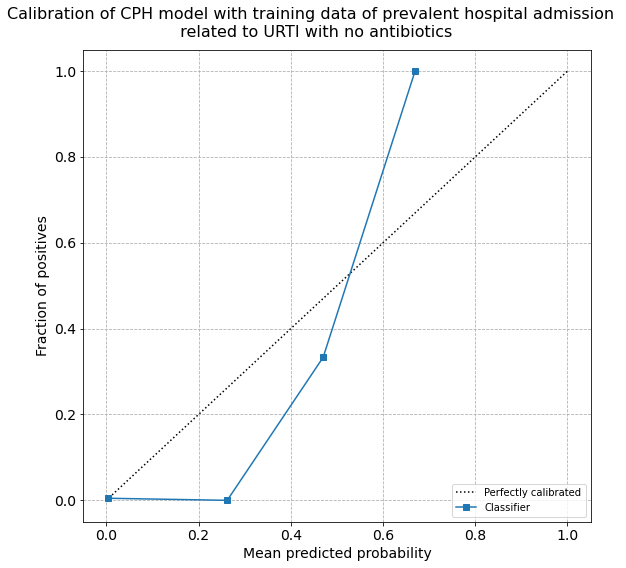

In [173]:
fig, axe = plt.subplots(figsize=(8, 8)
                        )

calib_cph_urti_no_abs_incdt_train = CalibrationDisplay.from_predictions(cph_urti_no_abs_prevl_train_cumulative_hazard.event_urti_admitted, cph_urti_no_abs_prevl_train_cumulative_hazard.cumulative_hazard, ax = axe)
plt.suptitle('Calibration of CPH model with training data of prevalent hospital admission \n related to URTI with no antibiotics', fontsize=16)
plt.xlabel('Mean predicted probability', fontsize=14)
plt.ylabel('Fraction of positives', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(visible=bool, linestyle='--')
plt.xlim(0, 0.5)
plt.ylim(0, 0.5)
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/calib_cph_urti_no_abs_prevl_train.jpg', bbox_inches='tight')
plt.show()

In [174]:
cph_urti_no_abs_prevl_test_cumulative_hazard.shape

(143, 2)

In [175]:
cph_urti_no_abs_prevl_test_cumulative_hazard.max()

cumulative_hazard      1681.396122
event_urti_admitted       0.000000
dtype: float64

In [341]:
# a = cph_urti_no_abs_prevl.predict_cumulative_hazard(data_urti_no_abs_prevl_train)
# a.loc[[188]]

In [176]:
cph_urti_no_abs_prevl_test_cumulative_hazard = cph_urti_no_abs_prevl_test_cumulative_hazard[cph_urti_no_abs_prevl_test_cumulative_hazard.cumulative_hazard <= 1]
cph_urti_no_abs_prevl_test_cumulative_hazard.max()

cumulative_hazard      0.61289
event_urti_admitted    0.00000
dtype: float64

In [177]:
cph_urti_no_abs_prevl_test_cumulative_hazard.shape

(139, 2)

In [350]:
fig, axe = plt.subplots(figsize=(8, 8)
                        )

calib_cph_urti_no_abs_incdt_test = CalibrationDisplay.from_predictions(cph_urti_no_abs_prevl_test_cumulative_hazard.event_urti_admitted, cph_urti_no_abs_prevl_test_cumulative_hazard.cumulative_hazard, ax = axe)
plt.suptitle('Calibration of CPH model with testing data of prevalent hospital admission \n related to URTI with no antibiotics', fontsize=16)
plt.xlabel('Mean predicted probability', fontsize=14)
plt.ylabel('Fraction of positives', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(visible=bool, linestyle='--')
plt.xlim(0, 0.5)
plt.ylim(0, 0.5)
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/calib_cph_urti_no_abs_prevl_test.jpg', bbox_inches='tight')
plt.show()

In [ ]:
# save model outputs
a = open("../output/hospitalisation_prediction_urti/cph_urti_no_abs_prevl_output.txt", "w")
a.write("")
a.writelines(['Concordance index for urti_no_abs_prevl with testing data: %.4f' % (concord_index_urti_no_abs_prevl_test), 
              '\nConcordance index for urti_no_abs_prevl with training data: %.4f' % (concord_index_urti_no_abs_prevl_train),
              '\nAUROC of CPH with training data of hospital admission related to prevalent URTI with no antibiotics = %.4f' % (r_auc1),
              '\nAUROC of CPH with testing data of hospital admission related to prevalent URTI with no antibiotics = %.4f' % (r_auc2),
              '\nBrier score of CPH with training data of hospital admission related to prevalent URTI with no antibiotics = %.4f' % (brier1),
              '\nBrier score of CPH with testing data of hospital admission related to prevalent URTI with no antibiotics = %.4f' % (brier2)])

#### 4-1-4- Prevalent hospital admission related to URTI with antibiotics

In [360]:
# data_urti_abs_prevl.columns

In [361]:
# #keep relevant variables
# data_urti_abs_prevl = data_urti_abs_prevl[['age_cat', 'sex', 'CCI_cat', 'age', 'bmi_imp', 'bmi_imp_cat', 
#                                            'gp_count_imp', 'gp_count_imp_cat', 'flu_vaccine', 'region_imp', 'season', 
#                                            'imd_imp', 'antibacterial_brit_imp', 'ethnicity_imp', 'antibacterial_brit_cat',
#                                            'smoking_status_imp', 'meds_nonabs', 'meds_nonabs_cat',
#                                            'event_urti_admitted', 'duration_urti_admitted']]

In [362]:
# # print number of missing values in each variable 
# data_urti_abs_prevl.isnull().sum()

In [363]:
# #randomly splitting data into training (%75) and testing (%25)
# data_urti_abs_prevl_train, data_urti_abs_prevl_test = train_test_split(data_urti_abs_prevl, test_size=0.2)

# print(f'shape of data_urti_abs_prevl for training: {data_urti_abs_prevl_train.shape}')
# print(f'shape of data_urti_abs_prevl for testing: {data_urti_abs_prevl_test.shape}')

In [364]:
# cph_urti_abs_prevl = CoxPHFitter().fit(data_urti_abs_prevl_train,
#         duration_col='duration_urti_admitted',
#         event_col='event_urti_admitted',
#         formula="age_cat + sex + CCI_cat + gp_count_imp_cat + flu_vaccine + bmi_imp_cat + region_imp + imd_imp + ethnicity_imp + smoking_status_imp + season"# + antibacterial_brit_imp + ethnicity_imp + smoking_status_imp + meds_nonabs" # season +
#         )
# cph_urti_abs_prevl.print_summary()

In [365]:
# output = GetPrintSummary(cph_urti_abs_prevl)

# with open('../output/hospitalisation_prediction_urti/cph_urti_abs_prevl_summary.html', "w") as fo:
#     print(fo.write(output))
#     fo.close()

In [366]:
# a = cph_urti_abs_prevl.baseline_hazard_

# # save 
# np.savetxt('../output/hospitalisation_prediction_urti/betas_cph_urti_abs_prevl.txt', a, delimiter=',')

In [367]:
# fig, ax = plt.subplots(figsize=(5, 9)
#                         )
# cph_urti_no_abs_prevl.plot()
# plt.suptitle('Coefficients of CPH model for prevalent hospital admission \n related to URTI with antibiotics', fontsize=16)
# #_ = ax.set_yticklabels(['Age', 'BMI', 'GP consultations', 'CCI', 'IMD', 'Flu vaccine', 'Antibacterial prescriptions'], 
# #                        rotation=45, fontsize=12, ha='right')
# plt.savefig('../output/hospitalisation_prediction_urti/coef_cph_urti_abs_prevl.jpg', bbox_inches='tight')
# plt.show()

In [368]:
# # concordance index of cph model with testing data
# concord_index_urti_abs_prevl_test = concordance_index(data_urti_abs_prevl_test['duration_urti_admitted'], -cph_urti_abs_prevl.predict_partial_hazard(data_urti_abs_prevl_test), data_urti_abs_prevl_test['event_urti_admitted'])
# print(f'Concordance index for cph_urti_abs_prevl with testing data: {concord_index_urti_abs_prevl_test}')

In [369]:
# a = [concord_index_urti_abs_prevl_test]
# np.savetxt('../output/hospitalisation_prediction_urti/concord_index_urti_abs_prevl_test.txt', a, delimiter=',')

In [370]:
# fig, ax = plt.subplots(figsize=(8, 5)
#                         )
# survival_probability_calibration(cph_urti_no_abs_prevl, data_urti_abs_prevl_train, t0=30)
# # plt.suptitle('Calibration of CPH model for prevalent hospital admission related to URTI with antibiotics', fontsize=16)
# plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_abs_prevl_train.jpg', bbox_inches='tight')
# plt.show()

In [ ]:
# fig, ax = plt.subplots(figsize=(8, 5)
#                         )
# survival_probability_calibration(cph_urti_no_abs_prevl, data_urti_abs_prevl_test, t0=30)
# plt.suptitle('Calibration of CPH model for prevalent hospital admission related to URTI with antibiotics', fontsize=16)
# plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_abs_prevl_test.jpg', bbox_inches='tight')
# plt.show()

## 5- Logistic regression
### 5-1- URTI
#### 5-1-1- Incident hospital admission related to URTI with no antibiotics

In [146]:
data_urti_no_abs_incdt.head()

,age_cat,sex,CCI_cat,gp_count_cat,flu_vaccine,bmi_cat,region,imd,ethnicity,smoking_status,season,antibacterial_brit_cat,meds_nonabs_cat,hx_hosp_cat,event_urti_admitted,duration_urti_admitted
1,25_34,Male,Very_high,Medium,No,Unknown,London,Medium,Unknown,Ex_smoker,Winter,Low,Very_low,Very_low,0.0,30.0
3,45_54,Female,Very_low,Low,No,Obese,South_East,Very_affluent,White,Unknown,Autumn,Very_low,Low,Very_low,0.0,30.0
4,75_or_more,Female,Very_low,Medium,No,Obese,East,Medium,Unknown,Smoker,Autumn,Very_low,Low,Very_low,0.0,30.0
5,5_14,Male,Very_high,Very_low,No,Obese,South_West,Very_affluent,White,Unknown,Winter,Very_low,Very_low,Very_low,0.0,30.0
6,65_74,Female,Very_low,Low,No,Obese,West_Midlands,Unaffluent,Unknown,Ex_smoker,Spring,High,Very_low,High,0.0,30.0


In [147]:
data_urti_no_abs_incdt.shape

(4906, 16)

In [149]:
# encoding categorical data for LR

# data = data_urti_abs_incdt[['event_urti_admitted', 'duration_urti_admitted', 'age', 'sex', 'CCI_cat', 'bmi_imp', 'bmi_imp_cat', 'gp_count_imp', 'gp_count_imp_cat', 'region_imp', 'season', 'imd_imp', 'ethnicity_imp', 'antibacterial_brit_imp', 'antibacterial_brit_cat', 'smoking_status_imp', 'meds_nonabs', 'meds_nonabs_cat']].reset_index()
data = data_urti_no_abs_incdt[['age_cat', 'sex', 'CCI_cat', 'gp_count_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit_cat', 'meds_nonabs_cat', 'hx_hosp_cat']].reset_index()
# data

# creating instance of one-hot-encoder
enc = OneHotEncoder()
results = enc.fit_transform(data)
# passing bridge-types-cat column (label encoded values of bridge_types)
data_urti_no_abs_incdt_enc = pd.DataFrame(enc.fit_transform(data[['age_cat', 'sex', 'CCI_cat', 'gp_count_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit_cat', 'meds_nonabs_cat', 'hx_hosp_cat']]).toarray())
data_urti_no_abs_incdt_enc.columns = enc.get_feature_names(data[['age_cat', 'sex', 'CCI_cat', 'gp_count_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit_cat', 'meds_nonabs_cat', 'hx_hosp_cat']].columns)
# data_urti_abs_incdt_enc = data.join(data_urti_abs_incdt_enc)
# data_urti_abs_incdt_enc = data_urti_abs_incdt_enc.drop(columns=['index', ])

data_urti_no_abs_incdt_enc.head()

,age_cat_0_4,age_cat_15_24,age_cat_25_34,age_cat_35_44,age_cat_45_54,age_cat_55_64,age_cat_5_14,age_cat_65_74,age_cat_75_or_more,sex_Female,...,meds_nonabs_cat_High,meds_nonabs_cat_Low,meds_nonabs_cat_Medium,meds_nonabs_cat_Very_high,meds_nonabs_cat_Very_low,hx_hosp_cat_High,hx_hosp_cat_Low,hx_hosp_cat_Medium,hx_hosp_cat_Very_high,hx_hosp_cat_Very_low
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [150]:
data_urti_no_abs_incdt_enc.shape

(4906, 70)

In [151]:
data_urti_no_abs_incdt_enc.columns

Index(['age_cat_0_4', 'age_cat_15_24', 'age_cat_25_34', 'age_cat_35_44',
       'age_cat_45_54', 'age_cat_55_64', 'age_cat_5_14', 'age_cat_65_74',
       'age_cat_75_or_more', 'sex_Female', 'sex_Male', 'CCI_cat_High',
       'CCI_cat_Low', 'CCI_cat_Medium', 'CCI_cat_Very_high',
       'CCI_cat_Very_low', 'gp_count_cat_High', 'gp_count_cat_Low',
       'gp_count_cat_Medium', 'gp_count_cat_Very_high',
       'gp_count_cat_Very_low', 'flu_vaccine_No', 'flu_vaccine_Yes',
       'bmi_cat_Healthy_weight', 'bmi_cat_Obese', 'bmi_cat_Overweight',
       'bmi_cat_Underweight', 'bmi_cat_Unknown', 'region_East',
       'region_East_Midlands', 'region_London', 'region_North_East',
       'region_North_West', 'region_South_East', 'region_South_West',
       'region_West_Midlands', 'region_Yorkshire_and_Humber', 'imd_Affluent',
       'imd_Medium', 'imd_Unaffluent', 'imd_Unknown', 'imd_Very_affluent',
       'imd_Very_unUnaffluent', 'ethnicity_Asian', 'ethnicity_Other',
       'ethnicity_Unknown', 'e

In [152]:
#randomly splitting data into training (%75) and testing (%25)
data_urti_no_abs_incdt_lr_X_train, data_urti_no_abs_incdt_lr_X_test, data_urti_no_abs_incdt_lr_y_train, data_urti_no_abs_incdt_lr_y_test = train_test_split(data_urti_no_abs_incdt_enc, data_urti_no_abs_incdt.event_urti_admitted, test_size=0.25, random_state=42)

print(f'shape of data_urti_no_abs_incdt_lr_X for training: {data_urti_no_abs_incdt_lr_X_train.shape}')
print(f'shape of data_urti_no_abs_incdt_lr_X for testing: {data_urti_no_abs_incdt_lr_X_test.shape}')
print(f'shape of data_urti_no_abs_incdt_lr_y for training: {data_urti_no_abs_incdt_lr_y_train.shape}')
print(f'shape of data_urti_no_abs_incdt_lr_y for testing: {data_urti_no_abs_incdt_lr_y_test.shape}')

shape of data_urti_no_abs_incdt_lr_X for training: (3679, 70)
shape of data_urti_no_abs_incdt_lr_X for testing: (1227, 70)
shape of data_urti_no_abs_incdt_lr_y for training: (3679,)
shape of data_urti_no_abs_incdt_lr_y for testing: (1227,)


In [153]:
#build LR model
lr_urti_no_abs_incdt = LogisticRegression().fit(data_urti_no_abs_incdt_lr_X_train, data_urti_no_abs_incdt_lr_y_train)

#prediction of hsopital admission related to urti of training data using lr
pred_proba_urti_no_abs_incdt_train = lr_urti_no_abs_incdt.predict_proba(data_urti_no_abs_incdt_lr_X_train)
# pred_proba_urti_no_abs_incdt_train

#calculate score of lr_urti_no_abs_incdt with training data
lr_urti_no_abs_incdt_training_score = lr_urti_no_abs_incdt.score(data_urti_no_abs_incdt_lr_X_train, data_urti_no_abs_incdt_lr_y_train)
print(f'score of lr_urti_no_abs_incdt with training data: {lr_urti_no_abs_incdt_training_score}')

#prediction of hsopital admission related to urti of testing data using lr
pred_proba_urti_no_abs_incdt_test = lr_urti_no_abs_incdt.predict_proba(data_urti_no_abs_incdt_lr_X_test)
# pred_proba_urti_no_abs_incdt_test

#calculate score of lr_urti_no_abs_incdt with testing data
lr_urti_no_abs_incdt_testing_score = lr_urti_no_abs_incdt.score(data_urti_no_abs_incdt_lr_X_test, data_urti_no_abs_incdt_lr_y_test)
print(f'score of lr_urti_no_abs_incdt with testing data: {lr_urti_no_abs_incdt_testing_score}')


score of lr_urti_no_abs_incdt with training data: 0.9923892362054906
score of lr_urti_no_abs_incdt with testing data: 0.9918500407497962


In [154]:
data_urti_no_abs_incdt_lr_X_test.shape

(1227, 70)

In [155]:
data_urti_no_abs_incdt_enc

,age_cat_0_4,age_cat_15_24,age_cat_25_34,age_cat_35_44,age_cat_45_54,age_cat_55_64,age_cat_5_14,age_cat_65_74,age_cat_75_or_more,sex_Female,...,meds_nonabs_cat_High,meds_nonabs_cat_Low,meds_nonabs_cat_Medium,meds_nonabs_cat_Very_high,meds_nonabs_cat_Very_low,hx_hosp_cat_High,hx_hosp_cat_Low,hx_hosp_cat_Medium,hx_hosp_cat_Very_high,hx_hosp_cat_Very_low
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4901,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4902,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4903,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4904,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [156]:
lr_urti_no_abs_incdt.decision_function(data_urti_no_abs_incdt_enc)

array([-4.73575696, -5.12603044, -5.93908397, ..., -3.93377749,
       -5.0932536 , -4.84598937])

In [157]:
lr_urti_no_abs_incdt.coef_

array([[ 8.63362119e-01, -8.14822458e-04, -5.55445806e-01,
        -2.14489680e-01,  1.16102556e-02, -2.01094090e-01,
         9.27990769e-02,  2.43545130e-03,  1.49322296e-03,
         6.73871347e-02, -6.75314075e-02,  1.90698151e-01,
        -2.12140131e-01, -5.92894529e-01,  4.90370029e-01,
         1.23822207e-01,  5.89819685e-01,  1.45970567e-01,
        -8.33364906e-01, -4.13961257e-02,  1.38826507e-01,
         1.51582699e-01, -1.51726971e-01, -3.04729045e-02,
         1.59866217e-01, -1.51525771e-02, -4.54798757e-01,
         3.40413749e-01, -2.17037497e-01, -9.37986030e-01,
         7.14434493e-01, -7.58707170e-02,  2.14537526e-01,
        -4.80694730e-01,  7.04087789e-01, -8.33840616e-02,
         1.61768954e-01, -9.17618617e-01, -1.85564169e-01,
        -1.69808381e-01,  2.13162956e-01,  3.06533762e-01,
         7.53150177e-01,  1.31490630e-01,  2.37281153e-01,
        -8.90622544e-03, -3.60009830e-01,  4.25864813e-01,
         2.97090703e-01, -3.34681859e-01, -3.88417930e-0

In [158]:
lr_urti_no_abs_incdt.feature_names_in_

array(['age_cat_0_4', 'age_cat_15_24', 'age_cat_25_34', 'age_cat_35_44',
       'age_cat_45_54', 'age_cat_55_64', 'age_cat_5_14', 'age_cat_65_74',
       'age_cat_75_or_more', 'sex_Female', 'sex_Male', 'CCI_cat_High',
       'CCI_cat_Low', 'CCI_cat_Medium', 'CCI_cat_Very_high',
       'CCI_cat_Very_low', 'gp_count_cat_High', 'gp_count_cat_Low',
       'gp_count_cat_Medium', 'gp_count_cat_Very_high',
       'gp_count_cat_Very_low', 'flu_vaccine_No', 'flu_vaccine_Yes',
       'bmi_cat_Healthy_weight', 'bmi_cat_Obese', 'bmi_cat_Overweight',
       'bmi_cat_Underweight', 'bmi_cat_Unknown', 'region_East',
       'region_East_Midlands', 'region_London', 'region_North_East',
       'region_North_West', 'region_South_East', 'region_South_West',
       'region_West_Midlands', 'region_Yorkshire_and_Humber',
       'imd_Affluent', 'imd_Medium', 'imd_Unaffluent', 'imd_Unknown',
       'imd_Very_affluent', 'imd_Very_unUnaffluent', 'ethnicity_Asian',
       'ethnicity_Other', 'ethnicity_Unknown', 'e

In [159]:
feature_names = lr_urti_no_abs_incdt.feature_names_in_
coef = np.squeeze(lr_urti_no_abs_incdt.coef_)

coef_lr = pd.DataFrame({'Coefficients':coef}, index = feature_names)
coef_lr = coef_lr.Coefficients.sort_values()
# coef_lr

# save 
np.savetxt('../output/hospitalisation_prediction_urti/coef_lr_urti_no_abs_incdt.txt', coef_lr, delimiter=',')

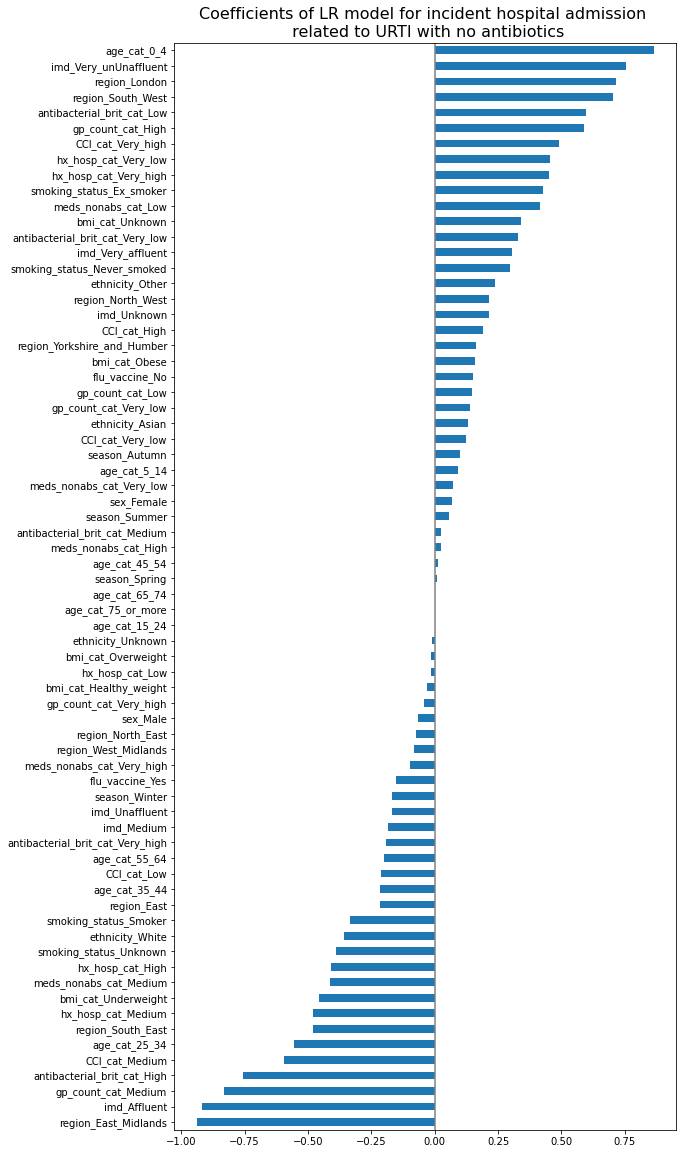

In [160]:
# feature_names = lr_urti_no_abs_incdt.feature_names_in_
# coef = np.squeeze(lr_urti_no_abs_incdt.coef_)

# coef_lr = pd.DataFrame({'Coefficients':coef}, index = feature_names)
# coef_lr = coef_lr.Coefficients.sort_values()
# # coef_lr

coef_lr.plot(kind="barh", figsize=(9, 20))
plt.title('Coefficients of LR model for incident hospital admission \n related to URTI with no antibiotics', fontsize=16)
plt.axvline(x=0, color=".5")
# plt.subplots_adjust(left=0.3)
# plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/coef_lr_urti_no_abs_incdt.jpg', bbox_inches='tight')
plt.show()

In [161]:
a = lr_urti_no_abs_incdt.intercept_

# save 
np.savetxt('../output/hospitalisation_prediction_urti/intercept_urti_no_abs_incdt.txt', a, delimiter=',')

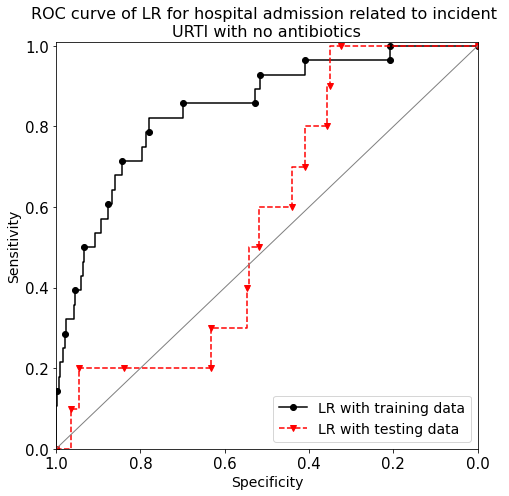

In [162]:
r_fpr1, r_tpr1, _ = roc_curve(data_urti_no_abs_incdt_lr_y_train, pred_proba_urti_no_abs_incdt_train[:,1])
r_fpr2, r_tpr2, _ = roc_curve(data_urti_no_abs_incdt_lr_y_test, pred_proba_urti_no_abs_incdt_test[:,1])

fig, ax1 = pyplot.subplots(figsize=(7, 7))

line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='LR with training data')
line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='LR with testing data')


squares = [0,1]
plt.plot(squares,linewidth=1, color='grey')
plt.ylim(0,1.01)
plt.xlim(0,1)

#plt.title('ROC Curve')
plt.xlabel('Specificity', fontsize=14)
plt.ylabel('Sensitivity', fontsize=14)

#reversing xticks
xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
x = np.arange(len(xticks))
ax1.set(xticklabels=xticks)
ax1.legend(fontsize=14)
plt.title('ROC curve of LR for hospital admission related to incident \nURTI with no antibiotics', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15, rotation=0)
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/roc_lr_urti_no_abs_incdt.jpg', bbox_inches='tight')
plt.show()

In [163]:
r_auc1 = roc_auc_score(data_urti_no_abs_incdt_lr_y_train, pred_proba_urti_no_abs_incdt_train[:,1])
r_auc2 = roc_auc_score(data_urti_no_abs_incdt_lr_y_test, pred_proba_urti_no_abs_incdt_test[:,1])
brier1 = brier_score_loss(data_urti_no_abs_incdt_lr_y_train, pred_proba_urti_no_abs_incdt_train[:,1])
brier2 = brier_score_loss(data_urti_no_abs_incdt_lr_y_test, pred_proba_urti_no_abs_incdt_test[:,1])

print('AUROC of LR with training data of hospital admission related to incident URTI with no antibiotics = %.4f' % (r_auc1))
print('AUROC of LR with testing data of hospital admission related to incident URTI with no antibiotics = %.4f' % (r_auc2))
print('Brier score of LR with training data of hospital admission related to incident URTI with no antibiotics = %.4f' % (brier1))
print('Brier score of LR with testing data of hospital admission related to incident URTI with no antibiotics = %.4f' % (brier2))

AUROC of LR with training data of hospital admission related to incident URTI with no antibiotics = 0.8434
AUROC of LR with testing data of hospital admission related to incident URTI with no antibiotics = 0.5711
Brier score of LR with training data of hospital admission related to incident URTI with no antibiotics = 0.0073
Brier score of LR with testing data of hospital admission related to incident URTI with no antibiotics = 0.0082


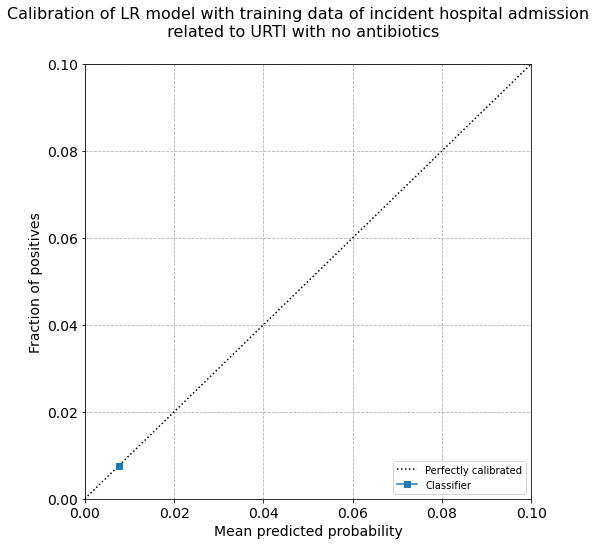

In [164]:
fig, axe = plt.subplots(figsize=(8, 8)
                        )

calib_lr_urti_no_abs_incdt_train = CalibrationDisplay.from_predictions(data_urti_no_abs_incdt_lr_y_train, pred_proba_urti_no_abs_incdt_train[:,1], ax = axe)
plt.suptitle('Calibration of LR model with training data of incident hospital admission \n related to URTI with no antibiotics', fontsize=16)
plt.xlabel('Mean predicted probability', fontsize=14)
plt.ylabel('Fraction of positives', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(visible=bool, linestyle='--')
plt.xlim(0, 0.1)
plt.ylim(0, 0.1)
# plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/calib_lr_urti_no_abs_incdt_train.jpg', bbox_inches='tight')
plt.show()

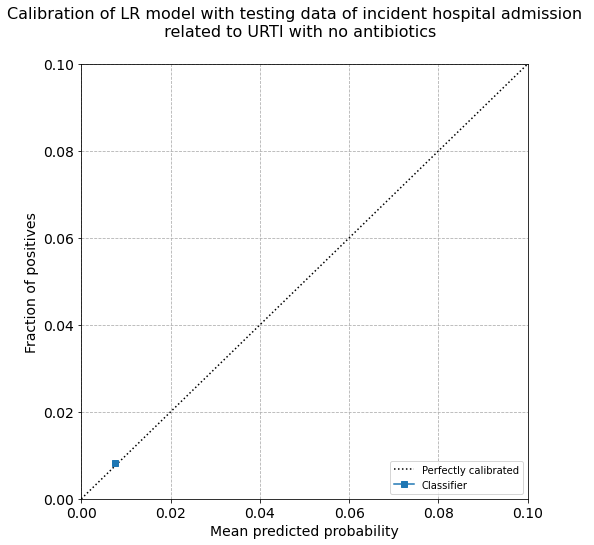

In [165]:
fig, axe = plt.subplots(figsize=(8, 8)
                        )

calib_lr_urti_no_abs_incdt_train = CalibrationDisplay.from_predictions(data_urti_no_abs_incdt_lr_y_test, pred_proba_urti_no_abs_incdt_test[:,1], ax = axe)
plt.suptitle('Calibration of LR model with testing data of incident hospital admission \n related to URTI with no antibiotics', fontsize=16)
plt.xlabel('Mean predicted probability', fontsize=14)
plt.ylabel('Fraction of positives', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(visible=bool, linestyle='--')
plt.xlim(0, 0.1)
plt.ylim(0, 0.1)
# plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/calib_lr_urti_no_abs_incdt_test.jpg', bbox_inches='tight')
plt.show()

In [166]:
# save model outputs
a = open("../output/hospitalisation_prediction_urti/lr_urti_no_abs_incdt_output.txt", "w")
a.write("")
a.writelines(['AUROC of LR with training data of hospital admission related to incident URTI with no antibiotics = %.4f' % (r_auc1),
              '\nAUROC of LR with testing data of hospital admission related to incident URTI with no antibiotics = %.4f' % (r_auc2),
              '\nBrier score of LR with training data of hospital admission related to incident URTI with no antibiotics = %.4f' % (brier1),
              '\nBrier score of LR with testing data of hospital admission related to incident URTI with no antibiotics = %.4f' % (brier2)])

### 5-1-2- Incident hospital admission related to URTI with antibiotics

In [469]:
data_urti_abs_incdt.head()

,age_cat,sex,CCI_cat,gp_count_cat,flu_vaccine,bmi_imp_cat,region,imd,ethnicity,smoking_status,season,antibacterial_brit_cat,meds_nonabs_cat,event_urti_admitted,duration_urti_admitted
3,35-44,Female,Medium,Low,No,Healthy weight,Yorkshire and The Humber,1,Asian,Unknown,Winter,Many,Very low,0.0,30.0
27,45-54,Female,Very high,Very low,No,Obese,East,2,Other,Smoker,Summer,Very low,Very low,0.0,30.0
56,75+,Male,Very high,Some,No,Obese,East Midlands,3,Other,Unknown,Winter,Very low,Very low,0.0,30.0
82,45-54,Male,Low,Low,No,Obese,South East,1,Other,Unknown,Spring,Low,Low,0.0,30.0
85,35-44,Female,High,Some,Yes,Obese,East Midlands,3,White,Unknown,Winter,Low,Very low,0.0,30.0


In [470]:
data_urti_abs_incdt.shape

(523, 15)

In [472]:
# encoding categorical data for LR

data = data_urti_abs_incdt[['age_cat', 'sex', 'CCI_cat', 'gp_count_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit_cat', 'meds_nonabs_cat', 'hx_hosp_cat']].reset_index()
# data

# creating instance of one-hot-encoder
enc = OneHotEncoder()
results = enc.fit_transform(data)
# passing bridge-types-cat column (label encoded values of bridge_types)
data_urti_abs_incdt_enc = pd.DataFrame(enc.fit_transform(data[['age_cat', 'sex', 'CCI_cat', 'gp_count_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit_cat', 'meds_nonabs_cat', 'hx_hosp_cat']]).toarray())
data_urti_abs_incdt_enc.columns = enc.get_feature_names(data[['age_cat', 'sex', 'CCI_cat', 'gp_count_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit_cat', 'meds_nonabs_cat', 'hx_hosp_cat']].columns)
# data_urti_abs_incdt_enc = data.join(data_urti_abs_incdt_enc)
# data_urti_abs_incdt_enc = data_urti_abs_incdt_enc.drop(columns=['index', ])

data_urti_abs_incdt_enc.head()

,age_cat_0-4,age_cat_15-24,age_cat_25-34,age_cat_35-44,age_cat_45-54,age_cat_5-14,age_cat_55-64,age_cat_65-74,age_cat_75+,sex_Female,...,antibacterial_brit_cat_Low,antibacterial_brit_cat_Many,antibacterial_brit_cat_Some,antibacterial_brit_cat_Too many,antibacterial_brit_cat_Very low,meds_nonabs_cat_Low,meds_nonabs_cat_Many,meds_nonabs_cat_Some,meds_nonabs_cat_Too many,meds_nonabs_cat_Very low
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [473]:
data_urti_abs_incdt_enc.columns

Index(['age_cat_0-4', 'age_cat_15-24', 'age_cat_25-34', 'age_cat_35-44',
       'age_cat_45-54', 'age_cat_5-14', 'age_cat_55-64', 'age_cat_65-74',
       'age_cat_75+', 'sex_Female', 'sex_Male', 'CCI_cat_High', 'CCI_cat_Low',
       'CCI_cat_Medium', 'CCI_cat_Very high', 'CCI_cat_Very low',
       'gp_count_cat_Low', 'gp_count_cat_Many', 'gp_count_cat_Some',
       'gp_count_cat_Too many', 'gp_count_cat_Very low', 'flu_vaccine_No',
       'flu_vaccine_Yes', 'bmi_imp_cat_Healthy weight', 'bmi_imp_cat_Obese',
       'bmi_imp_cat_Overweight', 'bmi_imp_cat_Underweight', 'region_East',
       'region_East Midlands', 'region_London', 'region_North East',
       'region_North West', 'region_South East', 'region_South West',
       'region_West Midlands', 'region_Yorkshire and The Humber', 'imd_0',
       'imd_1', 'imd_2', 'imd_3', 'imd_4', 'imd_5', 'ethnicity_Asian',
       'ethnicity_Other', 'ethnicity_Unknown', 'ethnicity_White',
       'smoking_status_Ex-smoker', 'smoking_status_Never smok

In [474]:
#randomly splitting data into training (%75) and testing (%25)
data_urti_abs_incdt_lr_X_train, data_urti_abs_incdt_lr_X_test, data_urti_abs_incdt_lr_y_train, data_urti_abs_incdt_lr_y_test = train_test_split(data_urti_abs_incdt_enc, data_urti_abs_incdt.event_urti_admitted, test_size=0.25, random_state=42)

print(f'shape of data_urti_abs_incdt_lr_X for training: {data_urti_abs_incdt_lr_X_train.shape}')
print(f'shape of data_urti_abs_incdt_lr_X for testing: {data_urti_abs_incdt_lr_X_test.shape}')
print(f'shape of data_urti_abs_incdt_lr_y for training: {data_urti_abs_incdt_lr_y_train.shape}')
print(f'shape of data_urti_abs_incdt_lr_y for testing: {data_urti_abs_incdt_lr_y_test.shape}')

shape of data_urti_abs_incdt_lr_X for training: (392, 64)
shape of data_urti_abs_incdt_lr_X for testing: (131, 64)
shape of data_urti_abs_incdt_lr_y for training: (392,)
shape of data_urti_abs_incdt_lr_y for testing: (131,)


In [475]:
#build LR model
lr_urti_abs_incdt = LogisticRegression().fit(data_urti_abs_incdt_lr_X_train, data_urti_abs_incdt_lr_y_train)

#prediction of hsopital admission related to urti of training data using lr
pred_proba_urti_abs_incdt_train = lr_urti_abs_incdt.predict_proba(data_urti_abs_incdt_lr_X_train)
# pred_proba_urti_abs_incdt_train

#calculate score of lr_urti_abs_incdt with training data
lr_urti_abs_incdt_training_score = lr_urti_abs_incdt.score(data_urti_abs_incdt_lr_X_train, data_urti_abs_incdt_lr_y_train)
print(f'score of lr_urti_abs_incdt with training data: {lr_urti_abs_incdt_training_score}')

#prediction of hsopital admission related to urti of testing data using lr
pred_proba_urti_abs_incdt_test = lr_urti_abs_incdt.predict_proba(data_urti_abs_incdt_lr_X_test)
# pred_proba_urti_abs_incdt_test

#calculate score of lr_urti_abs_incdt with testing data
lr_urti_abs_incdt_testing_score = lr_urti_abs_incdt.score(data_urti_abs_incdt_lr_X_test, data_urti_abs_incdt_lr_y_test)
print(f'score of lr_urti_abs_incdt with testing data: {lr_urti_abs_incdt_testing_score}')

score of lr_urti_abs_incdt with training data: 0.9846938775510204
score of lr_urti_abs_incdt with testing data: 0.9847328244274809


In [476]:
lr_urti_abs_incdt.coef_

array([[ 0.24377071,  0.66588036,  0.84634253,  0.33778275, -0.54988023,
        -0.39881244, -0.35771873, -0.34191925, -0.44546239, -0.11274075,
         0.11272406,  0.31177177,  0.01344101, -0.36760215,  0.07471259,
        -0.03233991,  0.13817483,  0.39550754, -0.13271779, -0.03086197,
        -0.37011929, -0.2114721 ,  0.21145541,  1.31241214, -1.01757575,
         0.03988778, -0.33474085,  0.50119352, -0.3483454 , -0.61154684,
         0.57719172,  0.29009562, -0.41157716, -0.29900814, -0.22607682,
         0.5280568 ,  0.5121238 , -0.0946237 ,  0.36013422, -0.12439726,
        -0.00492803, -0.64832571,  0.78668756, -0.30371299,  0.12994968,
        -0.61294094,  0.46735326, -0.33170599, -0.17757072,  0.04190677,
        -0.68699978, -0.2101975 ,  0.42290711,  0.47427349, -0.30279656,
        -0.17035238,  0.41841902, -0.09959029,  0.15430353, -0.3058095 ,
        -0.07139674,  0.31457066, -0.00304433,  0.06566323]])

In [477]:
lr_urti_abs_incdt.feature_names_in_

array(['age_cat_0-4', 'age_cat_15-24', 'age_cat_25-34', 'age_cat_35-44',
       'age_cat_45-54', 'age_cat_5-14', 'age_cat_55-64', 'age_cat_65-74',
       'age_cat_75+', 'sex_Female', 'sex_Male', 'CCI_cat_High',
       'CCI_cat_Low', 'CCI_cat_Medium', 'CCI_cat_Very high',
       'CCI_cat_Very low', 'gp_count_cat_Low', 'gp_count_cat_Many',
       'gp_count_cat_Some', 'gp_count_cat_Too many',
       'gp_count_cat_Very low', 'flu_vaccine_No', 'flu_vaccine_Yes',
       'bmi_imp_cat_Healthy weight', 'bmi_imp_cat_Obese',
       'bmi_imp_cat_Overweight', 'bmi_imp_cat_Underweight', 'region_East',
       'region_East Midlands', 'region_London', 'region_North East',
       'region_North West', 'region_South East', 'region_South West',
       'region_West Midlands', 'region_Yorkshire and The Humber', 'imd_0',
       'imd_1', 'imd_2', 'imd_3', 'imd_4', 'imd_5', 'ethnicity_Asian',
       'ethnicity_Other', 'ethnicity_Unknown', 'ethnicity_White',
       'smoking_status_Ex-smoker', 'smoking_status_Nev

In [478]:
feature_names = lr_urti_abs_incdt.feature_names_in_
coef = np.squeeze(lr_urti_abs_incdt.coef_)

coef_lr = pd.DataFrame({'Coefficients':coef}, index = feature_names)
coef_lr = coef_lr.Coefficients.sort_values()
# coef_lr

# save 
np.savetxt('../output/hospitalisation_prediction_urti/coef_lr_urti_abs_incdt.txt', coef_lr, delimiter=',')

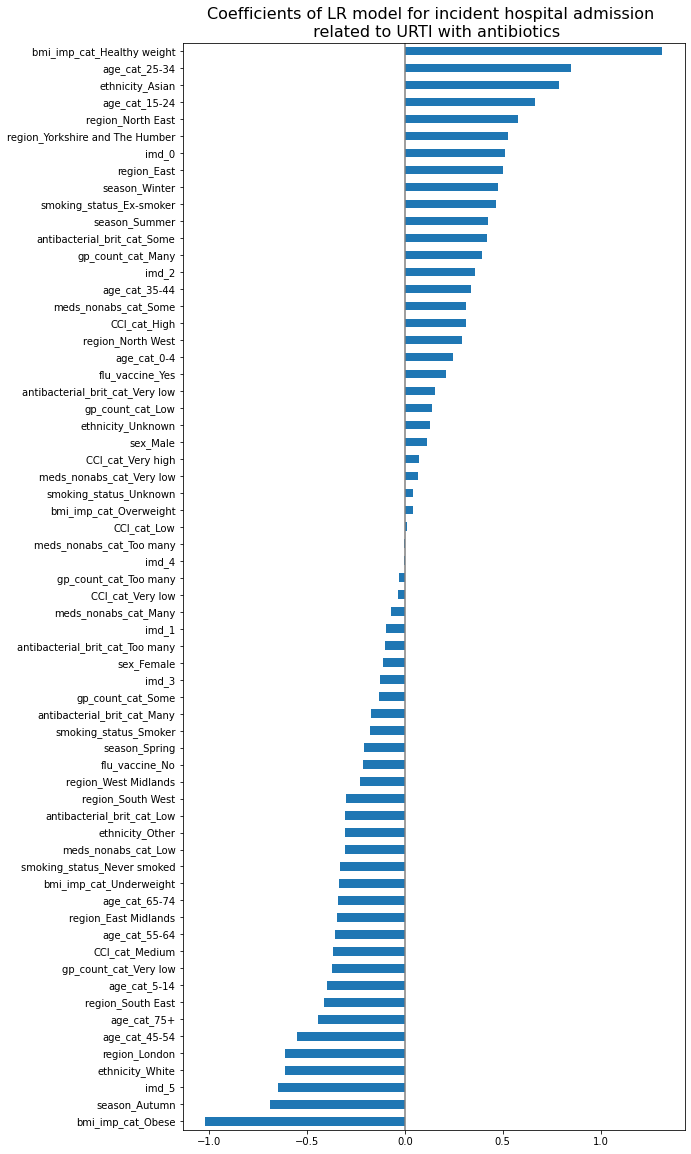

In [479]:
coef_lr.plot(kind="barh", figsize=(9, 20))
plt.title('Coefficients of LR model for incident hospital admission \n related to URTI with antibiotics', fontsize=16)
plt.axvline(x=0, color=".5")
# plt.subplots_adjust(left=0.3)
# plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/coef_lr_urti_abs_incdt.jpg', bbox_inches='tight')
plt.show()

In [480]:
a = lr_urti_abs_incdt.intercept_

# save 
np.savetxt('../output/hospitalisation_prediction_urti/intercept_urti_abs_incdt.txt', a, delimiter=',')

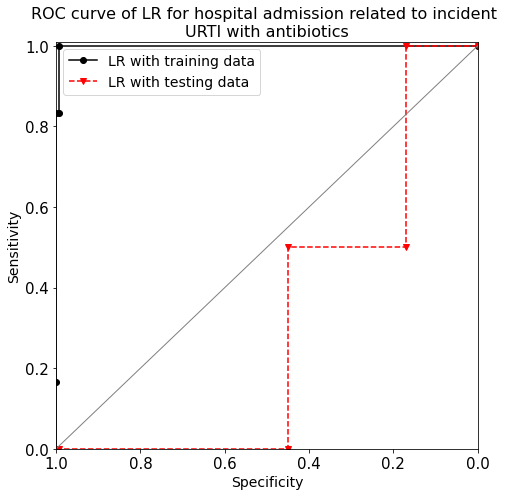

In [481]:
r_fpr1, r_tpr1, _ = roc_curve(data_urti_abs_incdt_lr_y_train, pred_proba_urti_abs_incdt_train[:,1])
r_fpr2, r_tpr2, _ = roc_curve(data_urti_abs_incdt_lr_y_test, pred_proba_urti_abs_incdt_test[:,1])

fig, ax1 = pyplot.subplots(figsize=(7, 7))

line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='LR with training data')
line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='LR with testing data')


squares = [0,1]
plt.plot(squares,linewidth=1, color='grey')
plt.ylim(0,1.01)
plt.xlim(0,1)

#plt.title('ROC Curve')
plt.xlabel('Specificity', fontsize=14)
plt.ylabel('Sensitivity', fontsize=14)

#reversing xticks
xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
x = np.arange(len(xticks))
ax1.set(xticklabels=xticks)
ax1.legend(fontsize=14)
plt.title('ROC curve of LR for hospital admission related to incident \nURTI with antibiotics', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15, rotation=0)
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/roc_lr_urti_abs_incdt.jpg', bbox_inches='tight')
plt.show()

In [482]:
r_auc1 = roc_auc_score(data_urti_abs_incdt_lr_y_train, pred_proba_urti_abs_incdt_train[:,1])
r_auc2 = roc_auc_score(data_urti_abs_incdt_lr_y_test, pred_proba_urti_abs_incdt_test[:,1])
brier1 = brier_score_loss(data_urti_abs_incdt_lr_y_train, pred_proba_urti_abs_incdt_train[:,1])
brier2 = brier_score_loss(data_urti_abs_incdt_lr_y_test, pred_proba_urti_abs_incdt_test[:,1])

print('AUROC of LR with training data of hospital admission related to incident URTI with antibiotics = %.4f' % (r_auc1))
print('AUROC of LR with testing data of hospital admission related to incident URTI with antibiotics = %.4f' % (r_auc2))
print('Brier score of LR with training data of hospital admission related to incident URTI with antibiotics = %.4f' % (brier1))
print('Brier score of LR with testing data of hospital admission related to incident URTI with antibiotics = %.4f' % (brier2))

AUROC of LR with training data of hospital admission related to incident URTI with antibiotics = 0.9987
AUROC of LR with testing data of hospital admission related to incident URTI with antibiotics = 0.3101
Brier score of LR with training data of hospital admission related to incident URTI with antibiotics = 0.0097
Brier score of LR with testing data of hospital admission related to incident URTI with antibiotics = 0.0175


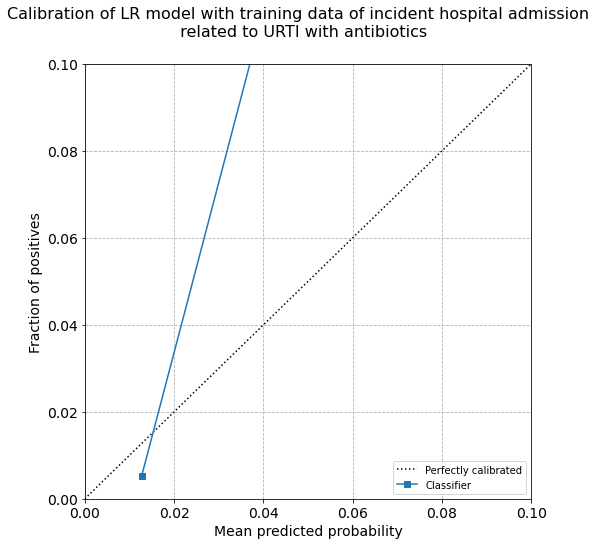

In [483]:
fig, axe = plt.subplots(figsize=(8, 8)
                        )

calib_lr_urti_abs_incdt_train = CalibrationDisplay.from_predictions(data_urti_abs_incdt_lr_y_train, pred_proba_urti_abs_incdt_train[:,1], ax = axe)
plt.suptitle('Calibration of LR model with training data of incident hospital admission \n related to URTI with antibiotics', fontsize=16)
plt.xlabel('Mean predicted probability', fontsize=14)
plt.ylabel('Fraction of positives', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(visible=bool, linestyle='--')
plt.xlim(0, 0.1)
plt.ylim(0, 0.1)
# plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/calib_lr_urti_abs_incdt_train.jpg', bbox_inches='tight')
plt.show()

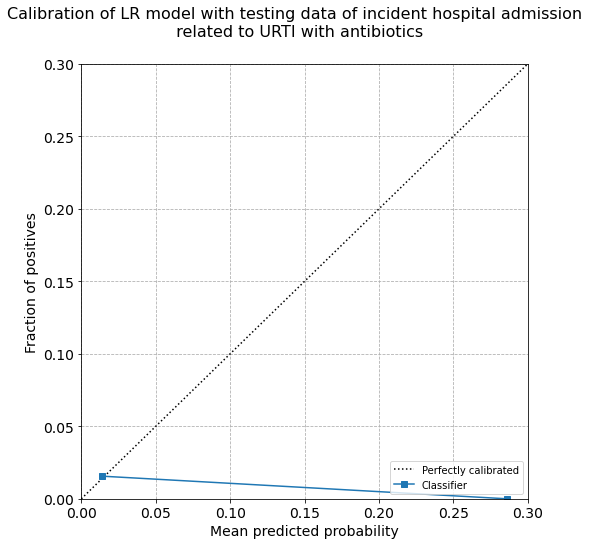

In [486]:
fig, axe = plt.subplots(figsize=(8, 8)
                        )

calib_lr_urti_abs_incdt_train = CalibrationDisplay.from_predictions(data_urti_abs_incdt_lr_y_test, pred_proba_urti_abs_incdt_test[:,1], ax = axe)
plt.suptitle('Calibration of LR model with testing data of incident hospital admission \n related to URTI with antibiotics', fontsize=16)
plt.xlabel('Mean predicted probability', fontsize=14)
plt.ylabel('Fraction of positives', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(visible=bool, linestyle='--')
plt.xlim(0, 0.3)
plt.ylim(0, 0.3)
# plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/calib_lr_urti_abs_incdt_test.jpg', bbox_inches='tight')
plt.show()

In [487]:
# save model outputs
a = open("../output/hospitalisation_prediction_urti/lr_urti_abs_incdt_output.txt", "w")
a.write("")
a.writelines(['AUROC of LR with training data of hospital admission related to incident URTI with antibiotics = %.4f' % (r_auc1),
              '\nAUROC of LR with testing data of hospital admission related to incident URTI with antibiotics = %.4f' % (r_auc2),
              '\nBrier score of LR with training data of hospital admission related to incident URTI with antibiotics = %.4f' % (brier1),
              '\nBrier score of LR with testing data of hospital admission related to incident URTI with antibiotics = %.4f' % (brier2)])

### 5-1-3- Prevalent hospital admission related to URTI with no antibiotics

In [488]:
data_urti_no_abs_prevl.head()

,age_cat,sex,CCI_cat,gp_count_cat,flu_vaccine,bmi_imp_cat,region,imd,ethnicity,smoking_status,season,antibacterial_brit_cat,meds_nonabs_cat,event_urti_admitted,duration_urti_admitted
5,15-24,Male,Very low,Low,No,Obese,North East,2,Other,Smoker,Spring,Very low,Many,0.0,30.0
8,25-34,Female,Very low,Very low,No,Overweight,East,2,Unknown,Unknown,Spring,Very low,Very low,0.0,30.0
39,45-54,Female,Very low,Very low,No,Obese,North West,2,Unknown,Never smoked,Spring,Low,Very low,0.0,30.0
68,0-4,Female,Very low,Very low,No,Overweight,East Midlands,1,White,Smoker,Autumn,Very low,Low,0.0,30.0
86,5-14,Female,Very low,Very low,No,Obese,West Midlands,5,Asian,Smoker,Winter,Very low,Very low,0.0,30.0


In [489]:
data_urti_no_abs_prevl.shape

(540, 15)

In [490]:
# encoding categorical data for LR

data = data_urti_no_abs_prevl[['age_cat', 'sex', 'CCI_cat', 'gp_count_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit_cat', 'meds_nonabs_cat', 'hx_hosp_cat']].reset_index()
# data

# creating instance of one-hot-encoder
enc = OneHotEncoder()
results = enc.fit_transform(data)
# passing bridge-types-cat column (label encoded values of bridge_types)
data_urti_no_abs_prevl_enc = pd.DataFrame(enc.fit_transform(data[['age_cat', 'sex', 'CCI_cat', 'gp_count_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit_cat', 'meds_nonabs_cat', 'hx_hosp_cat']]).toarray())
data_urti_no_abs_prevl_enc.columns = enc.get_feature_names(data[['age_cat', 'sex', 'CCI_cat', 'gp_count_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit_cat', 'meds_nonabs_cat', 'hx_hosp_cat']].columns)
# data_urti_no_abs_prevl_enc = data.join(data_urti_no_abs_prevl_enc)
# data_urti_no_abs_prevl_enc = data_urti_no_abs_prevl_enc.drop(columns=['index', ])

data_urti_no_abs_prevl_enc.head()

,age_cat_0-4,age_cat_15-24,age_cat_25-34,age_cat_35-44,age_cat_45-54,age_cat_5-14,age_cat_55-64,age_cat_65-74,age_cat_75+,sex_Female,...,antibacterial_brit_cat_Low,antibacterial_brit_cat_Many,antibacterial_brit_cat_Some,antibacterial_brit_cat_Too many,antibacterial_brit_cat_Very low,meds_nonabs_cat_Low,meds_nonabs_cat_Many,meds_nonabs_cat_Some,meds_nonabs_cat_Too many,meds_nonabs_cat_Very low
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [491]:
data_urti_no_abs_prevl_enc.columns

Index(['age_cat_0-4', 'age_cat_15-24', 'age_cat_25-34', 'age_cat_35-44',
       'age_cat_45-54', 'age_cat_5-14', 'age_cat_55-64', 'age_cat_65-74',
       'age_cat_75+', 'sex_Female', 'sex_Male', 'CCI_cat_High', 'CCI_cat_Low',
       'CCI_cat_Medium', 'CCI_cat_Very high', 'CCI_cat_Very low',
       'gp_count_cat_Low', 'gp_count_cat_Many', 'gp_count_cat_Some',
       'gp_count_cat_Too many', 'gp_count_cat_Very low', 'flu_vaccine_No',
       'flu_vaccine_Yes', 'bmi_imp_cat_Healthy weight', 'bmi_imp_cat_Obese',
       'bmi_imp_cat_Overweight', 'bmi_imp_cat_Underweight', 'region_East',
       'region_East Midlands', 'region_London', 'region_North East',
       'region_North West', 'region_South East', 'region_South West',
       'region_West Midlands', 'region_Yorkshire and The Humber', 'imd_0',
       'imd_1', 'imd_2', 'imd_3', 'imd_4', 'imd_5', 'ethnicity_Asian',
       'ethnicity_Other', 'ethnicity_Unknown', 'ethnicity_White',
       'smoking_status_Ex-smoker', 'smoking_status_Never smok

In [492]:
#randomly splitting data into training (%75) and testing (%25)
data_urti_no_abs_prevl_lr_X_train, data_urti_no_abs_prevl_lr_X_test, data_urti_no_abs_prevl_lr_y_train, data_urti_no_abs_prevl_lr_y_test = train_test_split(data_urti_no_abs_prevl_enc, data_urti_no_abs_prevl.event_urti_admitted, test_size=0.25, random_state=42)

print(f'shape of data_urti_no_abs_prevl_lr_X for training: {data_urti_no_abs_prevl_lr_X_train.shape}')
print(f'shape of data_urti_no_abs_prevl_lr_X for testing: {data_urti_no_abs_prevl_lr_X_test.shape}')
print(f'shape of data_urti_no_abs_prevl_lr_y for training: {data_urti_no_abs_prevl_lr_y_train.shape}')
print(f'shape of data_urti_no_abs_prevl_lr_y for testing: {data_urti_no_abs_prevl_lr_y_test.shape}')

shape of data_urti_no_abs_prevl_lr_X for training: (405, 64)
shape of data_urti_no_abs_prevl_lr_X for testing: (135, 64)
shape of data_urti_no_abs_prevl_lr_y for training: (405,)
shape of data_urti_no_abs_prevl_lr_y for testing: (135,)


In [493]:
#build LR model
lr_urti_no_abs_prevl = LogisticRegression().fit(data_urti_no_abs_prevl_lr_X_train, data_urti_no_abs_prevl_lr_y_train)

#prediction of hsopital admission related to urti of training data using lr
pred_proba_urti_no_abs_prevl_train = lr_urti_no_abs_prevl.predict_proba(data_urti_no_abs_prevl_lr_X_train)
# pred_proba_urti_no_abs_prevl_train

#calculate score of lr_urti_no_abs_prevl with training data
lr_urti_no_abs_prevl_training_score = lr_urti_no_abs_prevl.score(data_urti_no_abs_prevl_lr_X_train, data_urti_no_abs_prevl_lr_y_train)
print(f'score of lr_urti_no_abs_prevl with training data: {lr_urti_no_abs_prevl_training_score}')

#prediction of hsopital admission related to urti of testing data using lr
pred_proba_urti_no_abs_prevl_test = lr_urti_no_abs_prevl.predict_proba(data_urti_no_abs_prevl_lr_X_test)
# pred_proba_urti_no_abs_prevl_test

#calculate score of lr_urti_no_abs_prevl with testing data
lr_urti_no_abs_prevl_testing_score = lr_urti_no_abs_prevl.score(data_urti_no_abs_prevl_lr_X_test, data_urti_no_abs_prevl_lr_y_test)
print(f'score of lr_urti_no_abs_prevl with testing data: {lr_urti_no_abs_prevl_testing_score}')

score of lr_urti_no_abs_prevl with training data: 0.9950617283950617
score of lr_urti_no_abs_prevl with testing data: 1.0


In [494]:
lr_urti_no_abs_prevl.coef_

array([[-0.1369711 ,  0.41019918, -0.14171454,  0.57589494, -0.10411875,
        -0.15918319, -0.16035756, -0.12230283, -0.16143452,  0.07978114,
        -0.07976951, -0.0453854 , -0.14295974, -0.1453321 ,  0.63468589,
        -0.30099703, -0.23254242, -0.04294392, -0.17393118, -0.00209511,
         0.45152427,  0.10996773, -0.1099561 , -0.09281585, -0.25302018,
        -0.20130614,  0.54715381, -0.14476515, -0.13321799, -0.18552726,
        -0.12535692, -0.12468182, -0.11966071, -0.10195438,  1.02498959,
        -0.08981374, -0.04481904,  0.44528885,  0.17272981, -0.18724489,
        -0.19008682, -0.19585628,  0.51023469,  0.44087473, -0.36811488,
        -0.58298291, -0.07210079,  0.38407953, -0.40887949,  0.09691237,
         0.82649116, -0.29261388, -0.22767063, -0.30619502, -0.24132449,
        -0.10050896,  0.31829514, -0.00499585,  0.02854579, -0.0967857 ,
        -0.02224721, -0.08661544, -0.00263363,  0.20829361]])

In [495]:
lr_urti_no_abs_prevl.feature_names_in_

array(['age_cat_0-4', 'age_cat_15-24', 'age_cat_25-34', 'age_cat_35-44',
       'age_cat_45-54', 'age_cat_5-14', 'age_cat_55-64', 'age_cat_65-74',
       'age_cat_75+', 'sex_Female', 'sex_Male', 'CCI_cat_High',
       'CCI_cat_Low', 'CCI_cat_Medium', 'CCI_cat_Very high',
       'CCI_cat_Very low', 'gp_count_cat_Low', 'gp_count_cat_Many',
       'gp_count_cat_Some', 'gp_count_cat_Too many',
       'gp_count_cat_Very low', 'flu_vaccine_No', 'flu_vaccine_Yes',
       'bmi_imp_cat_Healthy weight', 'bmi_imp_cat_Obese',
       'bmi_imp_cat_Overweight', 'bmi_imp_cat_Underweight', 'region_East',
       'region_East Midlands', 'region_London', 'region_North East',
       'region_North West', 'region_South East', 'region_South West',
       'region_West Midlands', 'region_Yorkshire and The Humber', 'imd_0',
       'imd_1', 'imd_2', 'imd_3', 'imd_4', 'imd_5', 'ethnicity_Asian',
       'ethnicity_Other', 'ethnicity_Unknown', 'ethnicity_White',
       'smoking_status_Ex-smoker', 'smoking_status_Nev

In [496]:
feature_names = lr_urti_no_abs_prevl.feature_names_in_
coef = np.squeeze(lr_urti_no_abs_prevl.coef_)

coef_lr = pd.DataFrame({'Coefficients':coef}, index = feature_names)
coef_lr = coef_lr.Coefficients.sort_values()
# coef_lr

# save 
np.savetxt('../output/hospitalisation_prediction_urti/coef_lr_urti_no_abs_prevl.txt', coef_lr, delimiter=',')

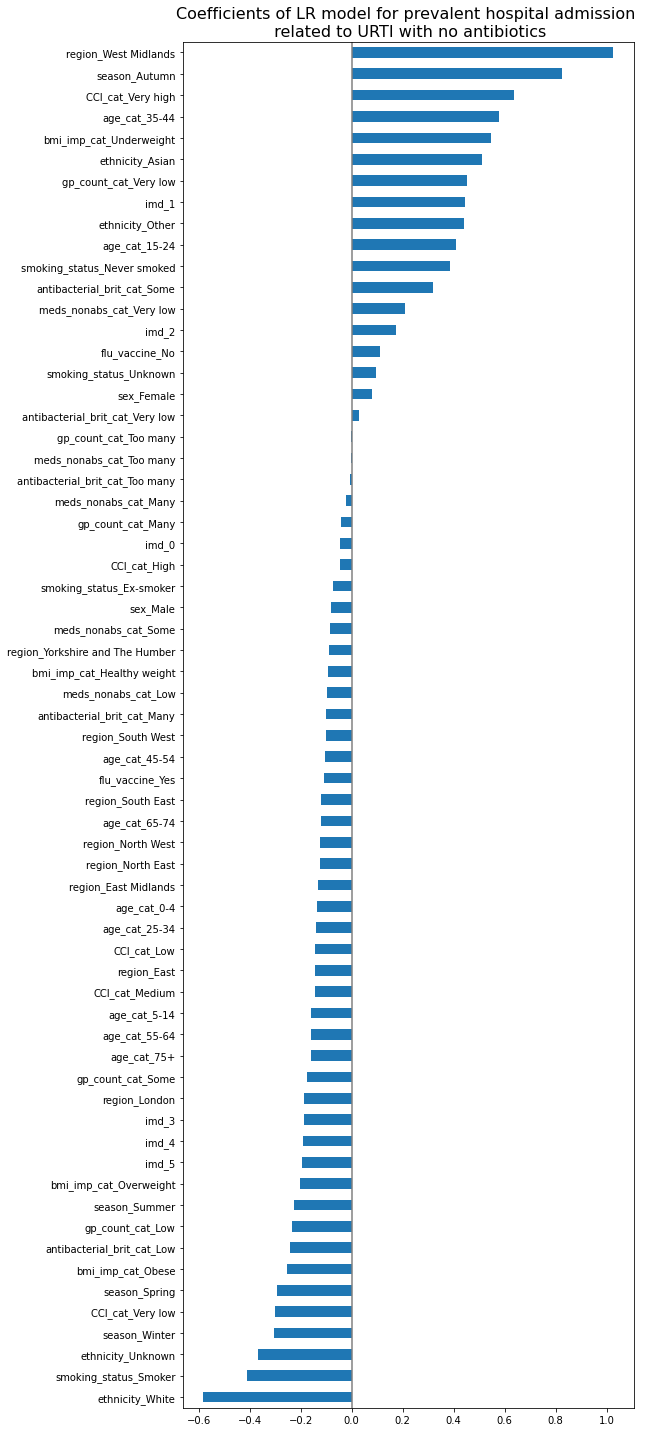

In [497]:
coef_lr.plot(kind="barh", figsize=(9, 20))
plt.title('Coefficients of LR model for prevalent hospital admission \n related to URTI with no antibiotics', fontsize=16)
plt.axvline(x=0, color=".5")
# plt.subplots_adjust(left=0.3)
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/coef_lr_urti_no_abs_prevl.jpg', bbox_inches='tight')
plt.show()


In [498]:
a = lr_urti_no_abs_prevl.intercept_

# save 
np.savetxt('../output/hospitalisation_prediction_urti/intercept_urti_no_abs_prevl.txt', a, delimiter=',')

In [500]:
r_fpr1, r_tpr1, _ = roc_curve(data_urti_no_abs_prevl_lr_y_train, pred_proba_urti_no_abs_prevl_train[:,1])
r_fpr2, r_tpr2, _ = roc_curve(data_urti_no_abs_prevl_lr_y_test, pred_proba_urti_no_abs_prevl_test[:,1])

fig, ax1 = pyplot.subplots(figsize=(7, 7))

line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='LR with training data')
line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='LR with testing data')


squares = [0,1]
plt.plot(squares,linewidth=1, color='grey')
plt.ylim(0,1.01)
plt.xlim(0,1)

#plt.title('ROC Curve')
plt.xlabel('Specificity', fontsize=14)
plt.ylabel('Sensitivity', fontsize=14)

#reversing xticks
xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
x = np.arange(len(xticks))
ax1.set(xticklabels=xticks)
ax1.legend(fontsize=14)
plt.title('ROC curve of LR for hospital admission related to prevalent \nURTI with no antibiotics', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15, rotation=0)
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/roc_lr_urti_no_abs_prevl.jpg', bbox_inches='tight')
plt.show()

In [250]:
r_auc1 = roc_auc_score(data_urti_no_abs_prevl_lr_y_train, pred_proba_urti_no_abs_prevl_train[:,1])
r_auc2 = roc_auc_score(data_urti_no_abs_prevl_lr_y_test, pred_proba_urti_no_abs_prevl_test[:,1])
brier1 = brier_score_loss(data_urti_no_abs_prevl_lr_y_train, pred_proba_urti_no_abs_prevl_train[:,1])
brier2 = brier_score_loss(data_urti_no_abs_prevl_lr_y_test, pred_proba_urti_no_abs_prevl_test[:,1])

print('AUROC of LR with training data of hospital admission related to prevalent URTI with no antibiotics = %.4f' % (r_auc1))
print('AUROC of LR with testing data of hospital admission related to prevalent URTI with no antibiotics = %.4f' % (r_auc2))
print('Brier score of LR with training data of hospital admission related to prevalent URTI with no antibiotics = %.4f' % (brier1))
print('Brier score of LR with testing data of hospital admission related to prevalent URTI with no antibiotics = %.4f' % (brier2))

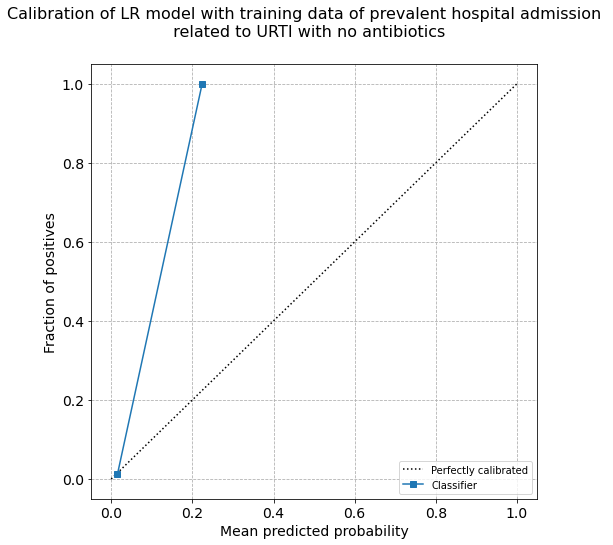

In [251]:
fig, axe = plt.subplots(figsize=(8, 8)
                        )

calib_lr_urti_no_abs_prevl_train = CalibrationDisplay.from_predictions(data_urti_no_abs_prevl_lr_y_train, pred_proba_urti_no_abs_prevl_train[:,1], ax = axe)
plt.suptitle('Calibration of LR model with training data of prevalent hospital admission \n related to URTI with no antibiotics', fontsize=16)
plt.xlabel('Mean predicted probability', fontsize=14)
plt.ylabel('Fraction of positives', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(visible=bool, linestyle='--')
plt.xlim(0, 0.5)
plt.ylim(0, 0.5)
# plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/calib_lr_urti_no_abs_prevl_train.jpg', bbox_inches='tight')
plt.show()

In [ ]:
fig, axe = plt.subplots(figsize=(8, 8)
                        )

calib_lr_urti_no_abs_prevl_train = CalibrationDisplay.from_predictions(data_urti_no_abs_prevl_lr_y_test, pred_proba_urti_no_abs_prevl_test[:,1], ax = axe)
plt.suptitle('Calibration of LR model with testing data of prevalent hospital admission \n related to URTI with no antibiotics', fontsize=16)
plt.xlabel('Mean predicted probability', fontsize=14)
plt.ylabel('Fraction of positives', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(visible=bool, linestyle='--')
plt.xlim(0, 0.5)
plt.ylim(0, 0.5)
# plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/calib_lr_urti_no_abs_prevl_test.jpg', bbox_inches='tight')
plt.show()

In [ ]:
# save model outputs
a = open("../output/hospitalisation_prediction_urti/lr_urti_no_abs_prevl_output.txt", "w")
a.write("")
a.writelines(['AUROC of LR with training data of hospital admission related to prevalent URTI with no antibiotics = %.4f' % (r_auc1),
              '\nAUROC of LR with testing data of hospital admission related to prevalent URTI with no antibiotics = %.4f' % (r_auc2),
              '\nBrier score of LR with training data of hospital admission related to prevalent URTI with no antibiotics = %.4f' % (brier1),
              '\nBrier score of LR with testing data of hospital admission related to prevalent URTI with no antibiotics = %.4f' % (brier2)])